## 1. Introduction
This notebook analyzes the functional and sequence relationships from the study on bacteria from operational heating and cooling water systems, primarily in Germany. Using 16S rRNA data (bootstrap-validated from Notebook 5), this analysis employs PICRUSt2 to predict metabolic functions and compare functional profiles between different bacterial groups.

### Analysis Approaches
The notebook start by importing libraries, preparing the directories paths in section 1, section 2 prepares the data for the picrust pipeline on fasta, biom formates. Section 3-6 shows the process utilising directly algoritm for advance computer capabilities. The author approach utilises the Galaxy platform, where the original product files are found https://usegalaxy.eu/u/magicalex238/h/picrust2-functional. The results are imported on section 7 where a broad analysis is done on the global data exploring pathways,algoritm implementation, top general pathways and reactions. Section 8 involves retrieving the protein names for the granular data (EC contribution, ECcontri) from Galaxy results and for that utilises Uniprot Database. ECcontri_Uniprot data is analysed for the point of cutoff where the protein abundance has biological activity (Knee_abundance) for later use. Section 9 import several known and autoritative databases that are use to compile a new database (EC_records) comprising enzyme_names, mechanisms, pathways, metal_involved, protein hierarchi, reactions, amongst others. Then enriches the granular data with the newly created EC_records, put identifiers idx and introduce Sites and Categories. Section 10 is dedicated to the Filtering of protein-genus pairs pipeline on ECcontri_Uniprot_enriched. The data is classified by patterns, pathways (housekeeping, niche and mixed), separated between increasing, decreasing and mixed patterns, and the increasing patterns pairs are taken to the next step. The data is then prioritized by biological and statistical significance (prioritized_markers). Lastly is filtered with the knee abundance for biological activity (balanced_markers) and divided on marker_groups.
Then Section 11 visualise the results, made some clustering between related pairs and choses the top 10 markers to bring into the machine learning compendium repository where is join with the physicochemical data for a more comprensive prediction on corrosion by microbiologically induced corrosion.

### Directory Structure:
``` text
Sequence Analysis and Functional Prediction Pipeline
├── Introduction  
│   ├── 16S rRNA Data (bootstrap-validated)
│   └── imports, paths, preparation data
└── Analysis Approaches  
    ├── Direct Algorithm (Sections 3-6)  
    └── Galaxy Platform Analysis                             
         ├── Section 7: Broad Analysis (pathways, reactions)
         ├── Section 8: Protein Name Retrieval, data preparation
         ├── Section 9: Database Creation and Data enrichment
         │       ├──  EC_records: enzyme_names, mechanisms, pathways,
         │       └──  metal_involved, reactions, hierarchy...
         ├── Section 10: Filtering Protein-Genus Pairs pipeline
         │       ├── patterns_data, classified_results,
         │       └── prioritized_results...
         └── Section 11:Visualization & Machine Learning  
                 ├── Clustering related pairs  
                 ├── Top 10 markers  
                 └── further to ML (corrosion prediction)   

Picrust2 works using its reference database that was installed with the package   ~/miniconda3/envs/picrust2/lib/python3.9/site-packages/picrust2/default_files/prokaryotic/pro_ref

About picrust2  
https://evomics.org/wp-content/uploads/2015/01/presentation_evomics-05-picrust_01-18-15.pdf



# 2. Loading and Preparing the Data

## 2.1 Colab Initialisation

In [1]:
'''import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages
#os.path.exists('/content/drive/MyDrive')
from google.colab import drive
#drive.flush_and_unmount()

# Colab specific
from google.colab import files
drive.mount('/content/drive')
#change the path
os.chdir('/content/drive/MyDrive/MIC/data_picrust')'''

"import os\nos.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages\n#os.path.exists('/content/drive/MyDrive')\nfrom google.colab import drive\n#drive.flush_and_unmount()\n\n# Colab specific\nfrom google.colab import files\ndrive.mount('/content/drive')\n#change the path\nos.chdir('/content/drive/MyDrive/MIC/data_picrust')"

### Kaggle / Colab

In [2]:
'''
# Making sure to use same python version for compatibility
!sudo apt-get update -y
!sudo apt-get install python3.10
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
from IPython.display import display
%pip install umap-learn
!pip install lxml pandas
!pip install pyarrow
!pip install openpyxl
!pip install scipy
!pip install python-Levenshtein
!pip install -U kaleido
!pip install statsmodels
!pip install kneed
!pip install natsort
!python3 --version
!pip install adjustText
!pip install psutil
import psutil
!pip install biopython
!pip install biom-format
!pip install fuzzywuzzy'''

'\n# Making sure to use same python version for compatibility\n!sudo apt-get update -y\n!sudo apt-get install python3.10\n!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1\nfrom IPython.display import display\n%pip install umap-learn\n!pip install lxml pandas\n!pip install pyarrow\n!pip install openpyxl\n!pip install scipy\n!pip install python-Levenshtein\n!pip install -U kaleido\n!pip install statsmodels\n!pip install kneed\n!pip install natsort\n!python3 --version\n!pip install adjustText\n!pip install psutil\nimport psutil\n!pip install biopython\n!pip install biom-format\n!pip install fuzzywuzzy'

# 2.2. Importing Libraries,  Making Directories and Loading Data

In [3]:
# Standard library imports
import os
import sys
import ast
import subprocess
import logging
import time
from datetime import datetime
import shutil
from io import StringIO
from pathlib import Path
import re

# Data processing and analysis
import pandas as pd
import numpy as np
import openpyxl
import seaborn as sns
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from matplotlib.colors import to_rgba, LinearSegmentedColormap
import matplotlib.patches as mpatches
import ipywidgets as widgets
from IPython.display import display

# Machine learning and statistical analysis
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE
import umap
import scipy
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.cluster.hierarchy as sch
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr, kruskal, mannwhitneyu
from kneed import KneeLocator
from scipy.signal import savgol_filter
from community import community_louvain
from joblib import Parallel, delayed
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Bioinformatics
#from Bio import SeqIO
#from Bio.Seq import Seq
#from Bio.SeqRecord import SeqRecord
#from biom import Table, load_table
#from biom.util import biom_open
#import xml.etree.ElementTree as ET
#from lxml import etree
# Web and data retrieval
#import requests

# Utility libraries
import gzip
import random
from natsort import natsorted
from typing import Dict, List, Tuple, Set, Optional
import pickle
import gc
import joblib
import h5py
import os
import json
import pyarrow.parquet as pq

os.environ['DISPLAY'] = ':0'

# Dash
import dash
from dash import dcc, html, Input, Output, callback, State
import dash_bootstrap_components as dbc
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import umap
# Own Scoring system
import sys

# Import global terms
try:
    sys.path.append('/kaggle/input/corrosion-scoring')
    from global_terms import pathway_categories
    print("Successfully imported pathway_categories from Kaggle path")
except ImportError:
    try:
        sys.path.append('/home/beatriz/MIC/2_Micro/corrosion_scoring')
        from corrosion_scoring.global_terms import pathway_categories
        print("Successfully imported pathway_categories from local path")
    except ImportError as e:
        raise ImportError(f"Error: Could not import pathway_categories: {e}")
    from corrosion_scoring import scoring_system


Successfully imported pathway_categories from local path


In [4]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s')

# Base Paths
if "google.colab" in sys.modules:
    base_dir = Path("/content/drive/MyDrive/MIC/data_visual")
else:
    base_dir = Path("/home/beatriz/MIC/2_Micro/data_visual")

#base dir for small files to git
base_dir = Path("/home/beatriz/MIC/2_Micro/data_visual")
base_dir.mkdir(parents=True, exist_ok=True)

abundance_excel= Path("/home/beatriz/MIC/2_Micro/data_Ref/merged_to_sequence.xlsx")

# Create output directory if it doesn't exist
output_base = base_dir / "output_base"
output_base.mkdir(parents=True, exist_ok=True)
# large files hosted instead in kaggle
large_dir = Path("/home/beatriz/MIC")
large_dir.mkdir(parents=True, exist_ok=True)

# Directory to output large files 
output_large = large_dir / "output_large"
output_large.mkdir(parents=True, exist_ok=True)
'''
# for colab
# Create output directory if it doesn't exist
base_dir = Path("/content/drive/MyDrive/MIC/data_visual/")
base_dir.mkdir(parents=True, exist_ok=True)
abundance_excel= Path("/content/drive/MyDrive/MIC/data_picrust/merged_to_sequence.xlsx")

output_base = base_dir  # Separate output directory
output_base.mkdir(parents=True, exist_ok=True)
large_dir = Path("/content/drive/MyDrive/MIC/")
large_dir.mkdir(parents=True, exist_ok=True)

# Directory to output large files
output_large = large_dir / "output_large"
output_large.mkdir(parents=True, exist_ok=True)

# For Kaggle work
# Input datasets (read-only in Kaggle)
base_dir = Path("/kaggle/input/dataset_results_picrust") #base dir for small files to git /kaggle/input/new-picrust

# Files in small input directory
abundance_excel= base_dir / "merged_to_sequence.xlsx" # inside input small sizes input

# Output for small files has to be changed for vscode no to push it to git
output_base = Path("/kaggle/working/output_base")
output_base.mkdir(parents=True, exist_ok=True)

# Directory to output large files 
large_dir =  Path("/kaggle/working/")

# Directory to output large files 
output_large = large_dir / "output_large"
output_large.mkdir(parents=True, exist_ok=True)'''

'\n# for colab\n# Create output directory if it doesn\'t exist\nbase_dir = Path("/content/drive/MyDrive/MIC/data_visual/")\nbase_dir.mkdir(parents=True, exist_ok=True)\nabundance_excel= Path("/content/drive/MyDrive/MIC/data_picrust/merged_to_sequence.xlsx")\n\noutput_base = base_dir  # Separate output directory\noutput_base.mkdir(parents=True, exist_ok=True)\nlarge_dir = Path("/content/drive/MyDrive/MIC/")\nlarge_dir.mkdir(parents=True, exist_ok=True)\n\n# Directory to output large files\noutput_large = large_dir / "output_large"\noutput_large.mkdir(parents=True, exist_ok=True)\n\n# For Kaggle work\n# Input datasets (read-only in Kaggle)\nbase_dir = Path("/kaggle/input/dataset_results_picrust") #base dir for small files to git /kaggle/input/new-picrust\n\n# Files in small input directory\nabundance_excel= base_dir / "merged_to_sequence.xlsx" # inside input small sizes input\n\n# Output for small files has to be changed for vscode no to push it to git\noutput_base = Path("/kaggle/workin

In [5]:
# Integrated taxa from origin genus as headers with levels 6 for the genera, 7 for the GID, muss be cleaned
Integrated_T = pd.read_excel(abundance_excel, sheet_name='core_check_usual_taxa', header=[0,1,2,3,4,5,6,7], engine ='openpyxl')
# Drop first row (index 0) and first column in one chain
Integrated_T = Integrated_T.drop(index=0).drop(Integrated_T.columns[0], axis=1)
Integrated_T= Integrated_T.astype({'Sites': str})
Integrated_T['Sites'] = Integrated_T['Sites'].fillna('Source')
# Remove 'Unnamed' level names
Integrated_T.columns = Integrated_T.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
# Changing dtypes to category whiles respecting structure
Integrated_T["Category"] = Integrated_T["Category"].astype("Int64")
Integrated_T= Integrated_T.set_index("Sites")
pre_Integrated = Integrated_T.T

In [6]:
'''# Recomenzar
eccontri_path = output_large / 'ECcontri_Uniprot_enriched.parquet'
ECcontri_Uniprot_enriched = pd.read_parquet(eccontri_path)'''

"# Recomenzar\neccontri_path = output_large / 'ECcontri_Uniprot_enriched.parquet'\nECcontri_Uniprot_enriched = pd.read_parquet(eccontri_path)"

In [7]:
# Define category dict outside
category_dict = Integrated_T.T.iloc[0, 0:-1].to_dict()

# Define colors and categories
category_colors = {1: '#008800',  # Dark green
                   2: '#FF8C00',  # Dark orange
                   3: '#FF0000'}   # Red

categories_labels = {1: 'Normal Operation',
              2: 'Early Warning',
              3: 'System Failure'}

In [8]:
parquet_dir = Path(os.path.join(output_large, "corrosion_markers.parquet"))
# List all Parquet files in directory
parquet_files = list(parquet_dir.glob("*.parquet"))

# Load all files into a dictionary of DataFrames
corrosion_report= {file.stem: pd.read_parquet(file) for file in parquet_files}

# Check available DataFrames
for name, df in corrosion_report.items():
    print(f"{name}: {df.shape}")

group_mechanism_all: (637, 36)
group_top_markers: (162, 36)
integrated_results: (49213, 41)
group_metal_iron_sulfur: (491, 36)
group_high_synergy_markers: (516, 36)
group_significant_markers: (162, 36)
classified_results: (49213, 44)
prioritized_markers: (28616, 56)
inverse_markers: (20360, 44)
group_high_prevalence: (491, 36)
group_metals_consolidated: (647, 36)
balanced_markers: (647, 54)
group_high_metals_relevance: (171, 36)
group_high_mechanism_relevance: (174, 36)
group_high_biological_relevance: (165, 36)
group_pathways_all: (611, 36)
group_high_pathway_relevance: (280, 36)
group_corrosion_critical: (65, 36)
increasing_markers: (28616, 44)
group_functional_categories: (637, 36)
group_high_corrosion_relevance: (162, 36)
group_organic_metal_synergy: (599, 36)
group_high_tier_relevance: (213, 36)
group_very_high_specificity: (30, 36)
pattern_data: (49213, 20)


In [9]:
# Main analysis dataframes (core pipeline)
pattern_data = corrosion_report["pattern_data"] 
integrated_results = corrosion_report["integrated_results"]
classified_results = corrosion_report["classified_results"]
increasing_markers = corrosion_report["increasing_markers"]
prioritized_markers = corrosion_report["prioritized_markers"]
balanced_markers = corrosion_report["balanced_markers"]
inverse_markers = corrosion_report["inverse_markers"]

# Top marker groups (overall rankings)
top_markers = corrosion_report["group_top_markers"]
significant_markers = corrosion_report["group_significant_markers"]
high_prevalence = corrosion_report["group_high_prevalence"]
very_high_specificity = corrosion_report["group_very_high_specificity"]
# high_frequency = corrosion_report["group_high_frequency"]  # This key doesn't exist - commented out

# Relevance-based groups
high_metals_relevance = corrosion_report["group_high_metals_relevance"]
high_mechanism_relevance = corrosion_report["group_high_mechanism_relevance"]
high_pathway_relevance = corrosion_report["group_high_pathway_relevance"]
high_tier_relevance = corrosion_report["group_high_tier_relevance"]
high_corrosion_relevance = corrosion_report["group_high_corrosion_relevance"]
high_biological_relevance = corrosion_report["group_high_biological_relevance"]

# Consolidated groups
mechanism_all = corrosion_report["group_mechanism_all"]
metals_consolidated = corrosion_report["group_metals_consolidated"]
pathways_all = corrosion_report["group_pathways_all"]
functional_categories = corrosion_report["group_functional_categories"]

# Special groups
metal_iron_sulfur = corrosion_report["group_metal_iron_sulfur"]
high_synergy_markers = corrosion_report["group_high_synergy_markers"]
organic_metal_synergy = corrosion_report["group_organic_metal_synergy"]
corrosion_critical = corrosion_report["group_corrosion_critical"]

# 3. General Visualising Corrosion Protein-Genus Pairs Analysis

## 3.1. Multiple Visualizations of Functional Data across Risk Categories

In [10]:
def plot_multiview_functional_landscape(prioritized_markers, name, top_n=25):
    """
    Creates multiple visualizations of functional data across risk categories,
    using the 'Category' column for coloring.

    Args:    prioritized_markers (DataFrame): DataFrame containing marker data.
             top_n (int): Number of top markers to include.
    Returns:   matplotlib figure with multiple subplots showing different aspects of the data.
    """

    # Define colors and categories
    category_colors = {
        1: '#008800',  # Dark green - Normal Operation
        2: '#FF8C00',  # Dark orange - Early Warning
        3: '#FF0000'   # Red - System Failure
    }

    categories_labels = {
        1: 'Normal Operation',
        2: 'Early Warning',
        3: 'System Failure'
    }
    # Select top markers by score
    top_markers = prioritized_markers.sort_values('combined_score', ascending=False).head(top_n)
    
    # Ensure Category is integer type to prevent mapping issues
    top_markers['Category'] = top_markers['Category'].astype(int)

    # Create figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))

    # 1. Pathway abundance by category (top left)
    ax1 = plt.subplot2grid((2, 2), (0, 0))

    # Process mechanisms data for mean categories
    mech_by_mean = []
    for _, row in top_markers.iterrows():
        if isinstance(row.get('corrosion_mechanisms'), str) and row['corrosion_mechanisms'] and pd.notna(row['norm_abund_contri']):
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
            
            # Find highest mean category for this row
            mean_cat1 = row.get('mean_cat1', 0) 
            mean_cat2 = row.get('mean_cat2', 0)
            mean_cat3 = row.get('mean_cat3', 0)
            
            # Create entries for each category to ensure all three appear in legend
            for mech in mechanisms:
                if mech:  # Ensure mechanism is not empty
                    # Add entry for each category with its corresponding mean value
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat1',  # Normal Operation
                        'Abundance': mean_cat1 * row['norm_abund_contri']
                    })
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat2',  # Early Warning
                        'Abundance': mean_cat2 * row['norm_abund_contri']
                    })
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat3',  # System Failure
                        'Abundance': mean_cat3 * row['norm_abund_contri']
                    })
    
    # Convert to DataFrame
    mean_mech_df = pd.DataFrame(mech_by_mean)
    
    # Define colors for mean categories
    mean_colors = {
        'mean_cat1': '#008800',  # Dark green - Normal Operation
        'mean_cat2': '#FF8C00',  # Dark orange - Early Warning
        'mean_cat3': '#FF0000'   # Red - System Failure
    }
    
    # Define category labels for the legend
    mean_labels = {
        'mean_cat1': 'Normal Operation (Mean)',
        'mean_cat2': 'Early Warning (Mean)',
        'mean_cat3': 'System Failure (Mean)'
    }
    
    if not mean_mech_df.empty:
        # Aggregate by mechanism and mean category
        agg_mean_mech = mean_mech_df.groupby(['Mechanism', 'Mean_Category'])['Abundance'].sum().reset_index()
        
        # Get top mechanisms by total abundance across all categories
        top_mechanisms = agg_mean_mech.groupby('Mechanism')['Abundance'].sum().nlargest(10).index
        agg_mean_mech = agg_mean_mech[agg_mean_mech['Mechanism'].isin(top_mechanisms)]
        
        # Create the plot with mean category colors
        sns.barplot(
            data=agg_mean_mech,
            x='Abundance',
            y='Mechanism',
            hue='Mean_Category',
            palette=mean_colors,
            ax=ax1
        )
        
        # Update legend with readable mean category labels
        handles, labels = ax1.get_legend_handles_labels()
        ax1.legend(handles=handles, labels=[mean_labels[label] for label in labels])
        ax1.set_title(f"Top Corrosion Mechanisms \nBy Mean Categories", fontsize=14)
        ax1.set_xlabel('Abundance', fontsize=12)
        ax1.set_ylabel('Mechanism', fontsize=12)
    else:
        ax1.text(0.5, 0.5, "No mechanism data available", ha='center', va='center', fontsize=14)
        ax1.set_title('Top Corrosion Mechanisms by Mean Category', fontsize=14)

    # 2. Heatmap of top proteins across categories (top right)
    ax2 = plt.subplot2grid((2, 2), (0, 1))

    # Check if we have required columns for the heatmap
    required_cols = ['mean_cat1', 'mean_cat2', 'mean_cat3', 'Genus', 'protein_name', 'norm_abund_contri']
    has_required_cols = all(col in top_markers.columns for col in required_cols)

    if has_required_cols and not top_markers.empty:
        # Create descriptive row labels
        protein_labels = []
        for _, row in top_markers.iterrows():
            genus = row.get('Genus', 'Unknown')
            protein_name = row.get('protein_name', 'Unknown')
            label = f"{genus} - {protein_name[:20]}..." if (isinstance(protein_name, str) and len(protein_name) > 20) else f"{genus} - {protein_name}"
            protein_labels.append(label)

        # Initialize a DataFrame to hold continuous values per category
        # Use numeric categories (1, 2, 3) instead of descriptive labels
        heatmap_data = pd.DataFrame(index=top_markers.index, columns=[1, 2, 3])
        
        # For each marker, compute the contribution for each category
        for idx, row in top_markers.iterrows():
            # Sum the means to get total abundance for this marker across categories
            total = row['mean_cat1'] + row['mean_cat2'] + row['mean_cat3']
            if total > 0:
                # Proportionally distribute the overall normalized abundance contribution
                heatmap_data.at[idx, 1] = (row['mean_cat1'] / total) * row['norm_abund_contri']
                heatmap_data.at[idx, 2] = (row['mean_cat2'] / total) * row['norm_abund_contri']
                heatmap_data.at[idx, 3] = (row['mean_cat3'] / total) * row['norm_abund_contri']
            else:
                # If total is zero, use zeros to avoid division errors
                heatmap_data.at[idx, 1] = 0
                heatmap_data.at[idx, 2] = 0
                heatmap_data.at[idx, 3] = 0

        # Limit to first 50 proteins to avoid overcrowding
        n_rows = min(50, len(heatmap_data))
        heatmap_data = heatmap_data.iloc[:n_rows]
        protein_labels = protein_labels[:n_rows]

        # Replace any remaining NaN values with 0 to avoid matplotlib warnings
        heatmap_data = heatmap_data.fillna(0)

        # Optionally, scale each row to percentages if desired
        for idx in heatmap_data.index:
            row_max = heatmap_data.loc[idx].max()
            if row_max > 0:
                heatmap_data.loc[idx] = (heatmap_data.loc[idx] / row_max * 100).round(1)

        # Create the heatmap using the continuous (non-binary) data with numeric category labels
        sns.heatmap(
            heatmap_data,
            cmap='Blues',
            annot=True,
            fmt='.1f',
            linewidths=0.5,
            yticklabels=protein_labels,
            xticklabels=['Category 1', 'Category 2', 'Category 3'],  # Consistent numeric labeling
            ax=ax2,
            vmin=0,
            vmax=100 
        )

        ax2.set_title('Protein Normalized Abundance Contributions by Category', fontsize=14)
    else:
        ax2.text(0.5, 0.5, "Insufficient data for heatmap", ha='center', va='center', fontsize=14)
        ax2.set_title('Protein Normalized Abundance Contributions by Category', fontsize=14)

    # 3. Pattern alignment with risk categories (bottom left)
    ax3 = plt.subplot2grid((2, 2), (1, 0))

    # Check for required columns

    if all(col in top_markers.columns for col in ['mean_cat1', 'mean_cat2', 'mean_cat3', 'Genus', 'protein_name', 'specificity', 'prevalence']) and not top_markers.empty:
        # Use specificity or prevalence score instead of correlation
        # Choose the metric that better differentiates the data
        top_markers['Category_Alignment'] = top_markers['specificity'] * top_markers['prevalence']

        # Filter out rows with NaN values
        valid_metrics = top_markers.dropna(subset=['Category_Alignment']).copy()

        if not valid_metrics.empty:
            # Sort by alignment metric and select top + bottom 5 (or fewer if not enough data)
            n_to_select = min(5, len(valid_metrics) // 2)  # ensure we don't try to select more than available

            top_aligned = valid_metrics.sort_values('Category_Alignment', ascending=False).head(n_to_select)
            low_aligned = valid_metrics.sort_values('Category_Alignment').head(n_to_select)

            # Combine the high and low alignment metrics
            metric_markers = pd.concat([top_aligned, low_aligned])

            # Create new indices to avoid alignment issues
            metric_markers = metric_markers.reset_index(drop=True)

            # Create labels
            metric_labels = []
            for _, row in metric_markers.iterrows():
                genus = row.get('Genus', 'Unknown')
                protein_name = row.get('protein_name', 'Unknown')
                if isinstance(protein_name, str) and len(protein_name) > 15:
                    label = f"{genus} - {protein_name[:15]}..."
                else:
                    label = f"{genus} - {protein_name}"
                metric_labels.append(label)

            # Create a color map based on alignment values
            # Higher values (better category alignment) are blue
            colors = ['red' if c < metric_markers['Category_Alignment'].median() else 'blue' for c in metric_markers['Category_Alignment']]

            # Create a basic matplotlib horizontal bar plot
            bars = ax3.barh(
                range(len(metric_markers)),
                metric_markers['Category_Alignment'].values,
                color=colors
            )

            # Set the y-tick labels manually
            ax3.set_yticks(range(len(metric_labels)))
            ax3.set_yticklabels(metric_labels)

            ax3.axvline(x=metric_markers['Category_Alignment'].median(), color='gray', linestyle='--')
            ax3.set_title('Proteins with Strongest Category Alignment', fontsize=14)
            ax3.set_xlabel('Category Alignment Score (Specificity × Prevalence)', fontsize=12)
            ax3.set_ylabel('')
        else:
            ax3.text(0.5, 0.5, "No valid alignment data", ha='center', va='center', fontsize=14)
            ax3.set_title('Proteins with Strongest Category Alignment', fontsize=14)
    else:
        ax3.text(0.5, 0.5, "Insufficient data for pattern analysis", ha='center', va='center', fontsize=14)
        ax3.set_title('Proteins with Strongest Category Alignment', fontsize=14)
    # 4. Genus distribution across categories (bottom right)
    ax4 = plt.subplot2grid((2, 2), (1, 1))

    # Check for required columns
    if all(col in top_markers.columns for col in ['mean_cat1', 'mean_cat2', 'mean_cat3', 'Genus']) and not top_markers.empty:
        # Group by genus and calculate mean abundance in each category
        genus_abundance = top_markers.groupby('Genus').agg({
            'mean_cat1': 'mean',
            'mean_cat2': 'mean',
            'mean_cat3': 'mean'
        }).reset_index()

        # Rename columns for melting
        genus_abundance.columns = ['Genus', 'Category 1', 'Category 2', 'Category 3']

        # Calculate total abundance and get top genera
        genus_abundance['Total'] = genus_abundance['Category 1'] + genus_abundance['Category 2'] + genus_abundance['Category 3']
        n_genera = min(12, len(genus_abundance))
        top_genera = genus_abundance.sort_values('Total', ascending=False).head(n_genera)

        # Melt for plotting
        genera_plot = top_genera.melt(
            id_vars=['Genus'],
            value_vars=['Category 1', 'Category 2', 'Category 3'],
            var_name='Category',
            value_name='Abundance'
        )

        # Map categories to labels
        genera_plot['Category'] = genera_plot['Category'].map({
            'Category 1': categories_labels[1],
            'Category 2': categories_labels[2],
            'Category 3': categories_labels[3]
        })

        # Create the plot
        sns.barplot(
            data=genera_plot,
            x='Genus',
            y='Abundance',
            hue='Category',
            palette=[category_colors[1], category_colors[2], category_colors[3]],
            ax=ax4
        )

        ax4.set_title('Top Genera Abundance by Risk Category', fontsize=14)
        ax4.set_xlabel('Genus', fontsize=12)
        ax4.set_ylabel('Mean Abundance', fontsize=12)
        ax4.tick_params(axis='x', rotation=45)
    else:
        ax4.text(0.5, 0.5, "Insufficient genus data", ha='center', va='center', fontsize=14)
        ax4.set_title('Top Genera Abundance by Risk Category', fontsize=14)

    # Overall title
    plt.suptitle(f"Functional MIC Landscape on {name}", fontsize=18, y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    return fig

/tmp/ipykernel_27262/303566332.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_data = heatmap_data.fillna(0)
/tmp/ipykernel_27262/893407649.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


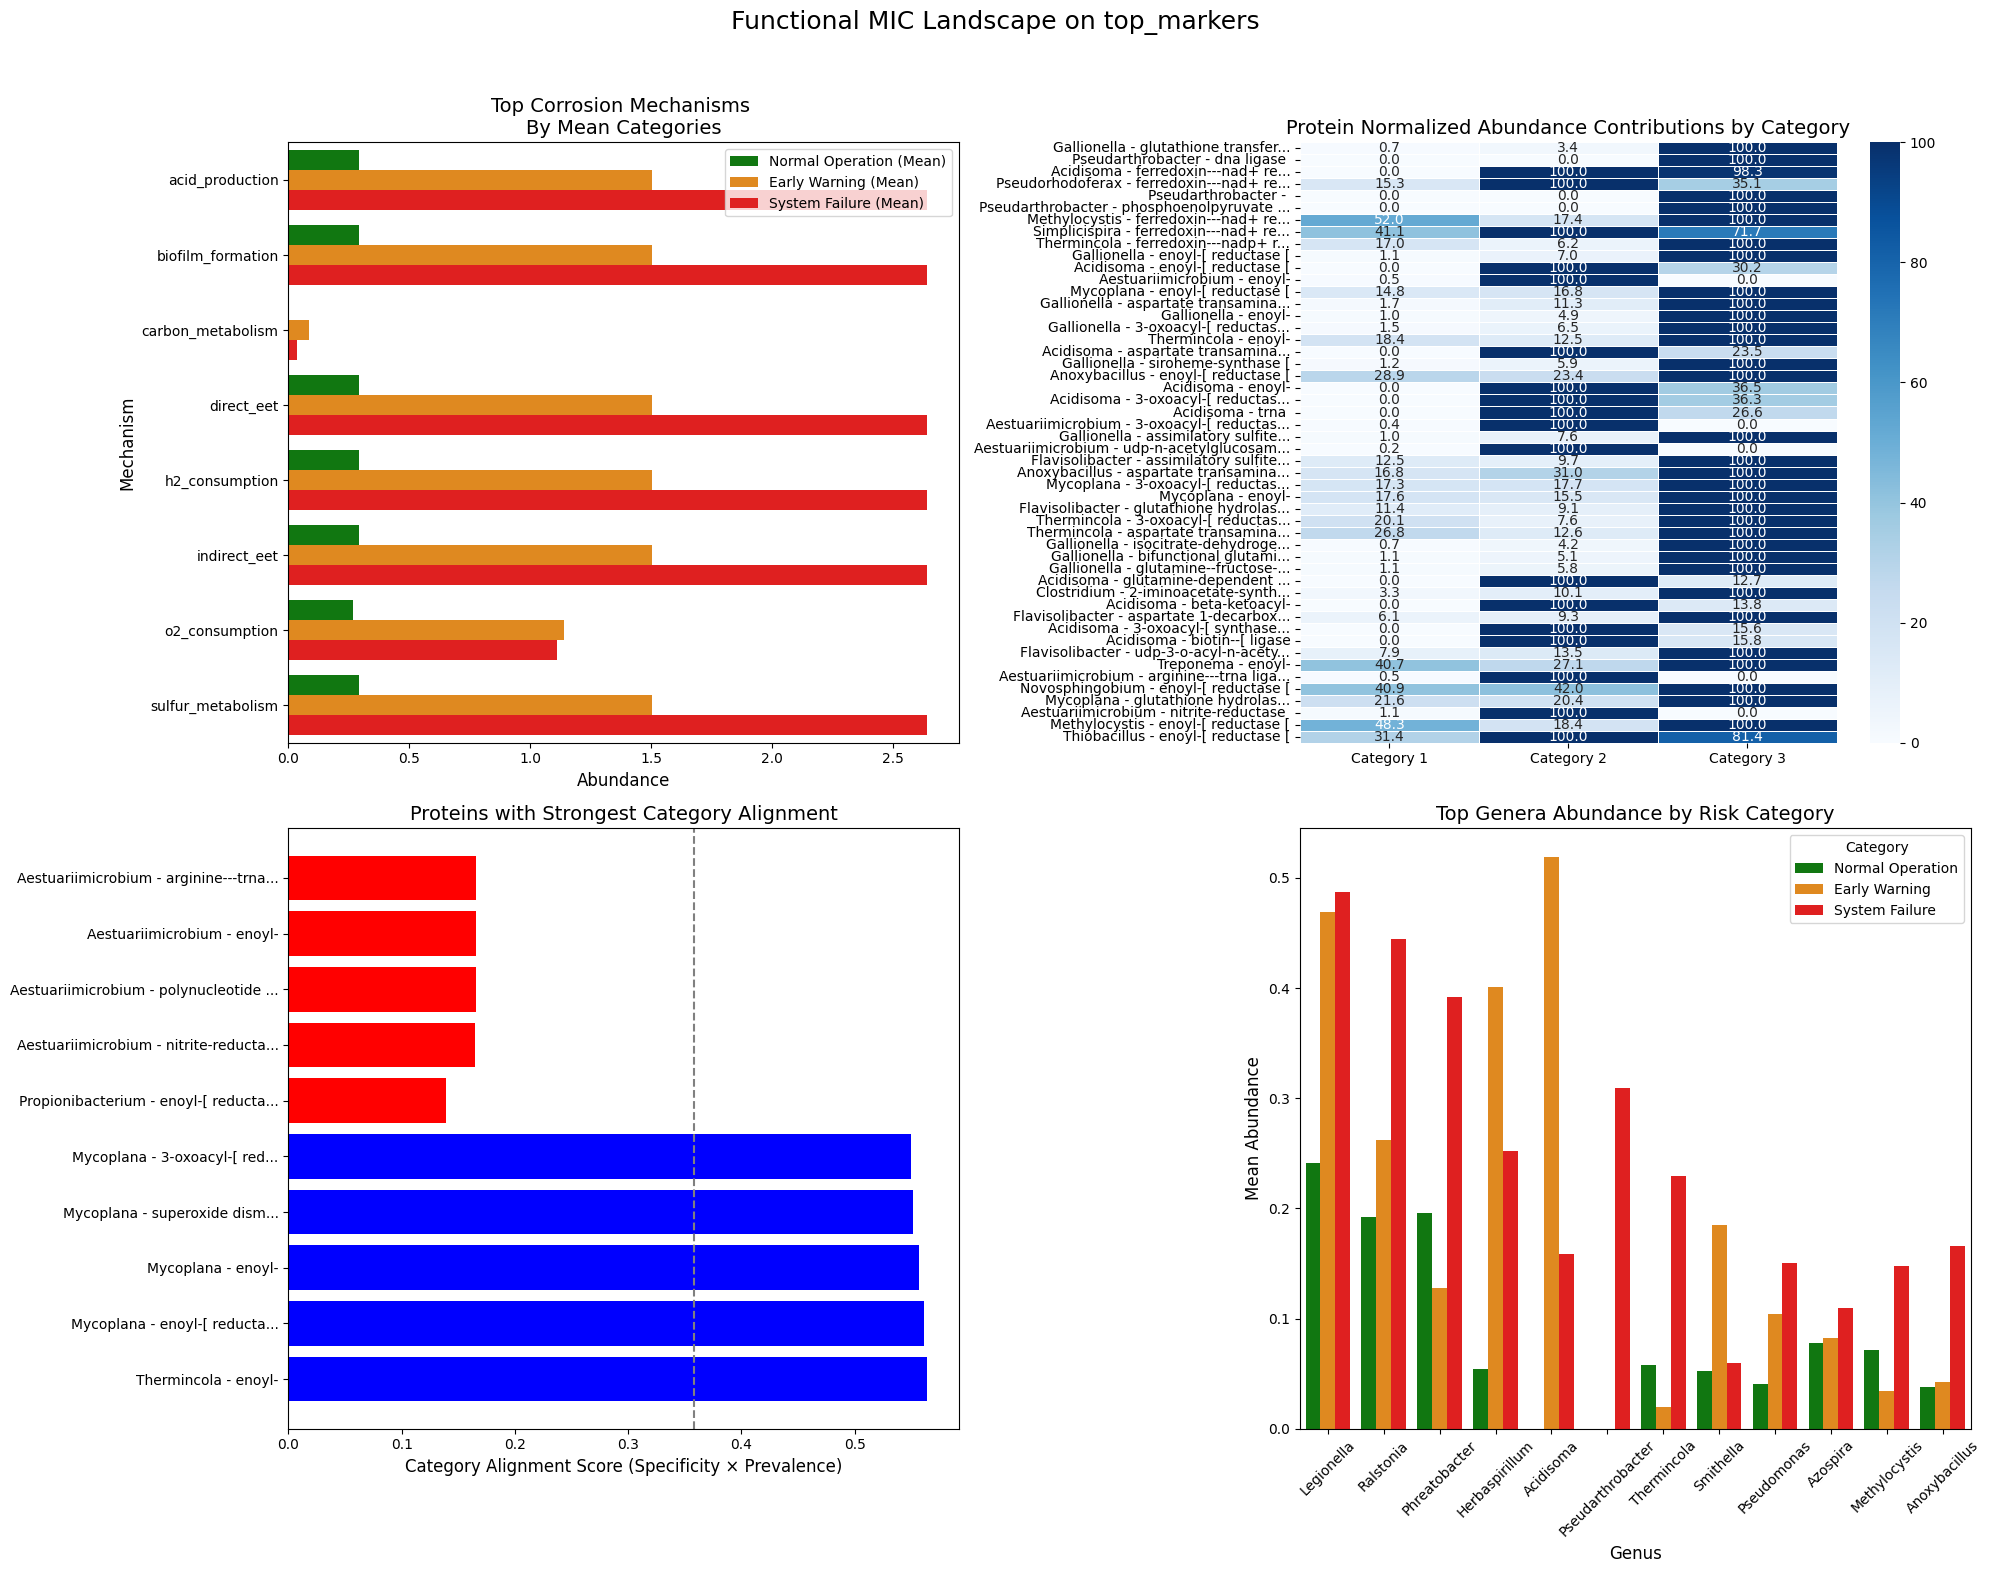

In [11]:
fig = plot_multiview_functional_landscape(top_markers, "top_markers", top_n=150)
fig.show()

/tmp/ipykernel_27262/303566332.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_data = heatmap_data.fillna(0)
/tmp/ipykernel_27262/2529648156.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


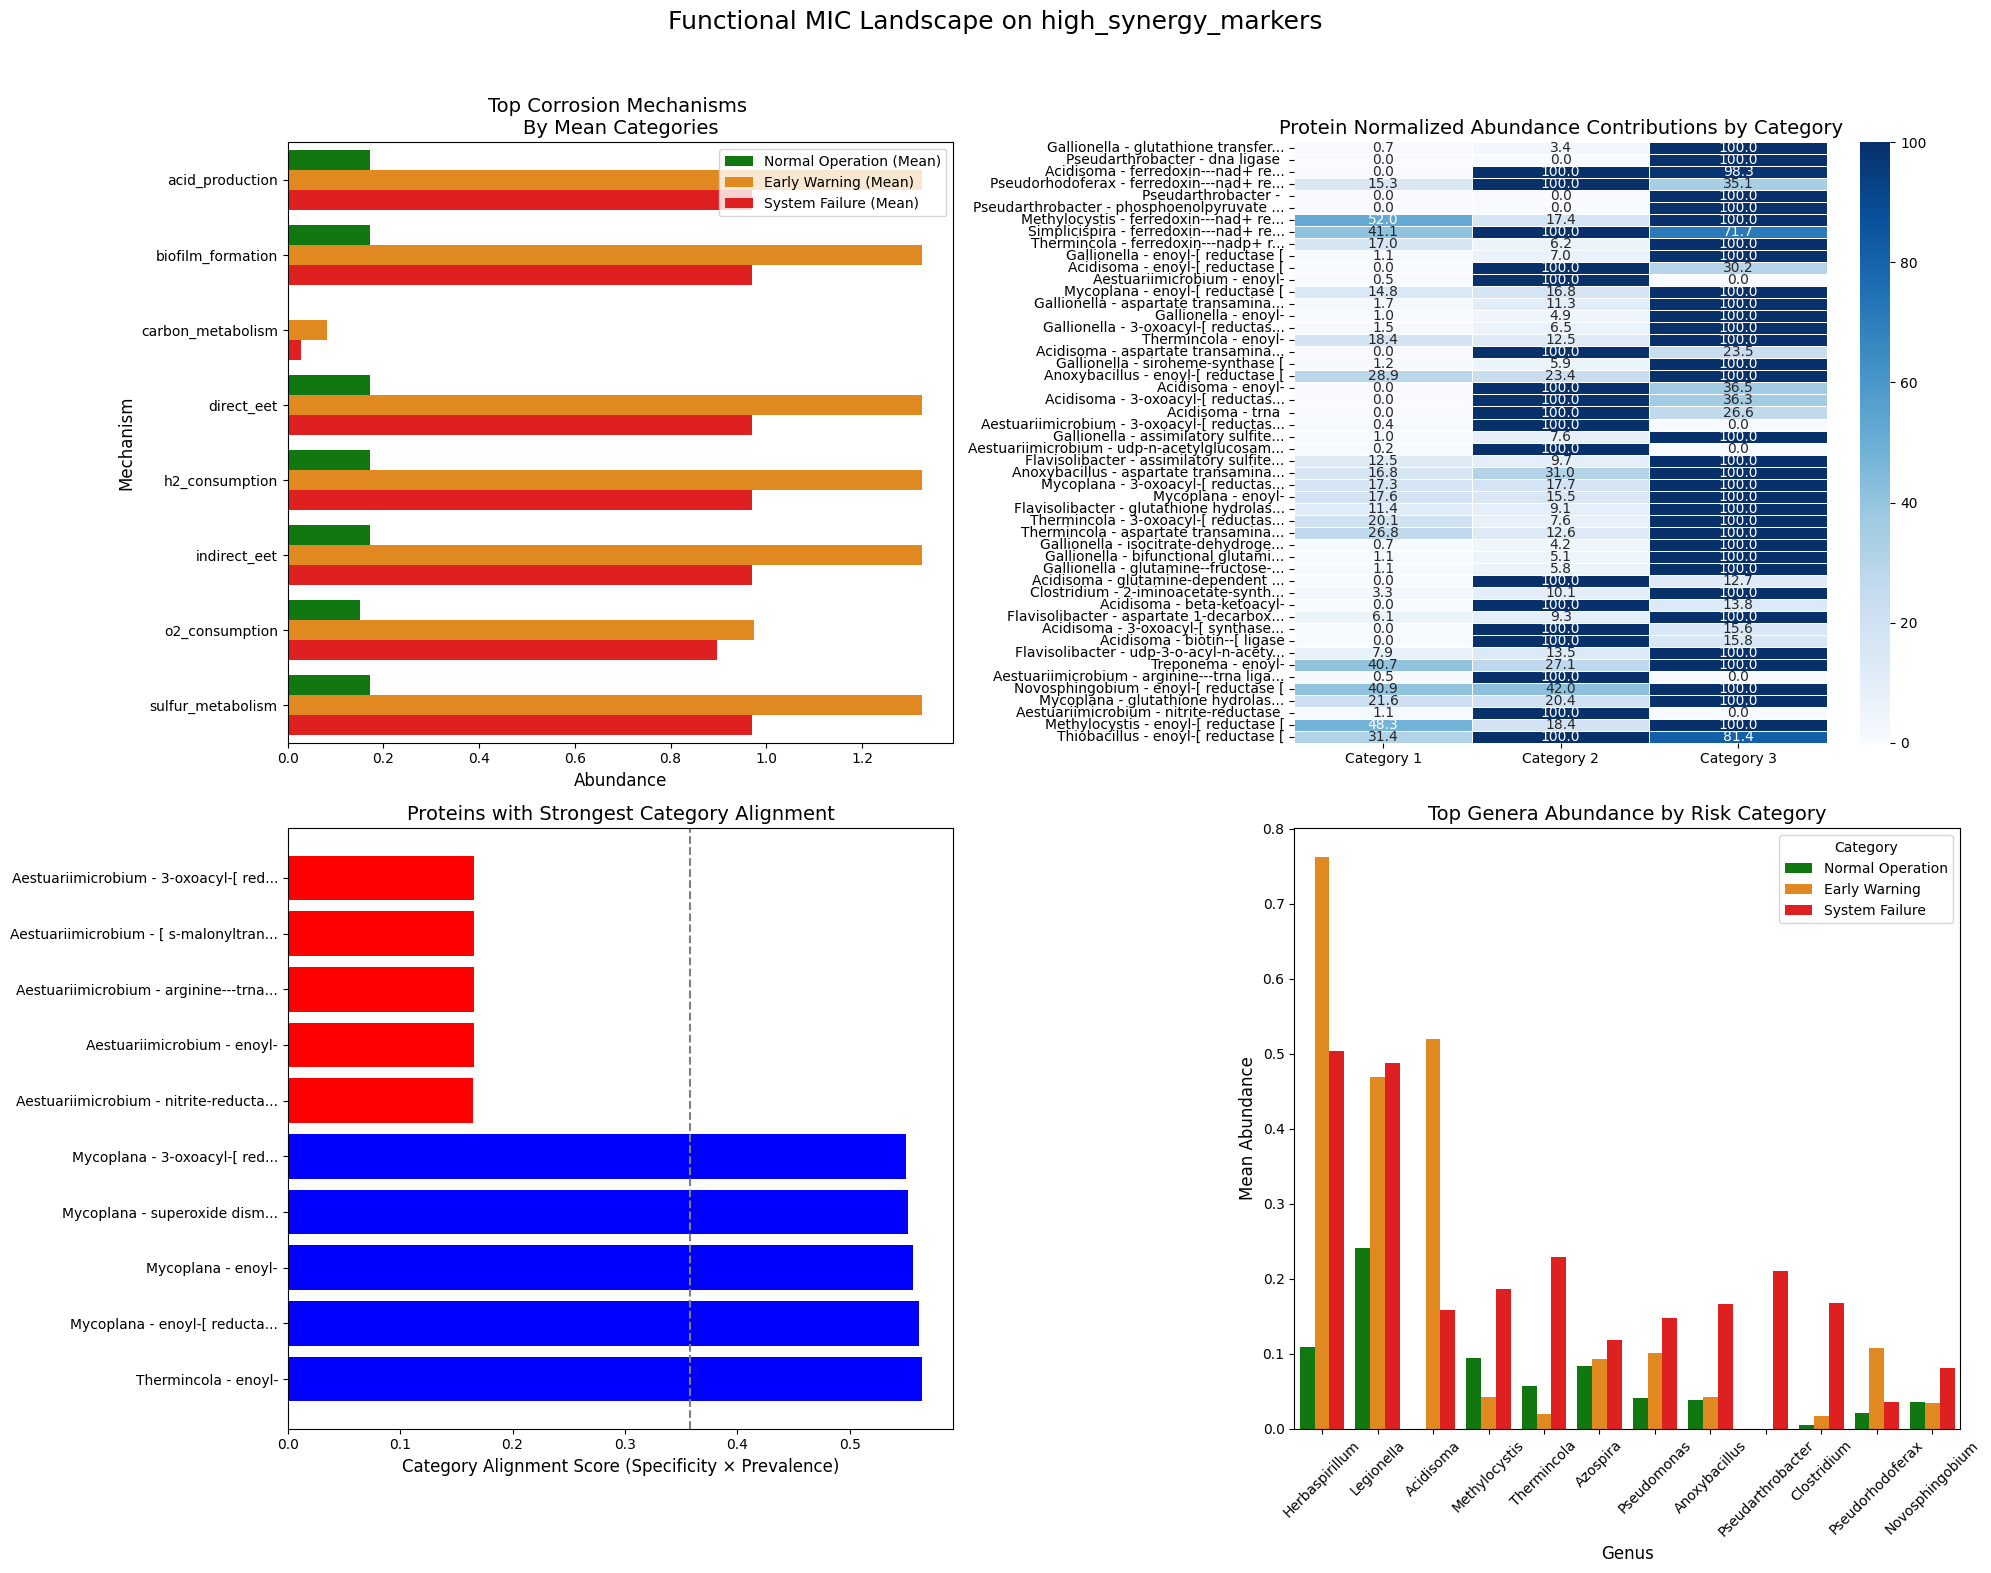

In [12]:
plot_multiview_functional_landscape(high_synergy_markers,"high_synergy_markers", top_n=100)
fig.show()

The prominence of acid production, direct eet, H2 consumption and sulphate production is expected on the the top mechanism at the granular level gives good consistency to the filtering pipeline. The plot for very_high_specificity group shows that the H2 consumption mechanism and the acid production predominate for that group.

## 3.2. Comparison of Mechanism by Category methodology

In [13]:
def corrosion_mechanism_original_vs_mean(top_markers, name="Comparison", top_n=10):
    """
    Create a comparison plot showing corrosion mechanisms using:
    1. Original Category (left subplot)
    2. Mean categories (right subplot)
    
    Parameters:     top_markers : DataFrame   containing the data with columns:   Category, corrosion_mechanisms, norm_abund_contri, mean_cat1, mean_cat2, mean_cat3
    name : str, optional to include in the plot title, by default "Comparison"
    top_n : int, optional    Number of top mechanisms to display, by default 10
    save_path : str, optional    Path to save the output figure, by default None
        
    Returns:  fig : matplotlib.figure.Figure  
    """
    # Define colors and categories for original Category
    category_colors = {
        1: '#008800',  # Dark green - Normal Operation
        2: '#FF8C00',  # Dark orange - Early Warning
        3: '#FF0000'   # Red - System Failure
    }
    
    categories_labels = {
        1: 'Normal Operation',
        2: 'Early Warning',
        3: 'System Failure'
    }
    
    # Define colors for mean categories
    mean_colors = {
        'mean_cat1': '#008800',  # Dark green
        'mean_cat2': '#FF8C00',  # Dark orange
        'mean_cat3': '#FF0000'   # Red
    }
    
    # Mean category labels for the legend
    mean_labels = {
        'mean_cat1': 'Normal Operation (Mean)',
        'mean_cat2': 'Early Warning (Mean)',
        'mean_cat3': 'System Failure (Mean)'
    }
    
    # Select top markers by score
    top_markers = top_markers.copy(deep=False)
    
    # Ensure Category is integer type to prevent mapping issues
    top_markers['Category'] = top_markers['Category'].astype(int)
    
    # Create figure with multiple subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # 1. FIRST PLOT: Original Category (left)
    mech_by_category = []
    for _, row in top_markers.iterrows():
        if isinstance(row.get('corrosion_mechanisms'), str) and row['corrosion_mechanisms'] and pd.notna(row['norm_abund_contri']):
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
            for mech in mechanisms:
                if mech:  # Ensure mechanism is not empty
                    mech_by_category.append({
                        'Mechanism': mech,
                        'Category': int(row['Category']),  # Ensure integer type
                        'norm_abund_contri': row['norm_abund_contri']
                    })
    
    # Convert to DataFrame and aggregate
    mech_df = pd.DataFrame(mech_by_category)
    
    # Check if we have mechanisms data to plot
    if not mech_df.empty:
        # Group by mechanism and original category, summing abundance
        agg_mech = mech_df.groupby(['Mechanism', 'Category'])['norm_abund_contri'].sum().reset_index(name='Abundance')
        
        # Sort by abundance and get top mechanisms
        top_mechanisms = agg_mech.groupby('Mechanism')['Abundance'].sum().nlargest(top_n).index
        agg_mech = agg_mech[agg_mech['Mechanism'].isin(top_mechanisms)]
        
        # Create the plot with consistent category colors
        sns.barplot(
            data=agg_mech,
            x='Abundance',
            y='Mechanism',
            hue='Category',
            palette=category_colors,
            ax=ax1
        )
        
        # Ensure legend shows categories with proper labels
        handles, labels = ax1.get_legend_handles_labels()
        ax1.legend(handles=handles, labels=[categories_labels[int(label)] for label in labels])
        ax1.set_title(f"Top Corrosion Mechanisms - {name}\nBy Original Category", fontsize=14)
        ax1.set_xlabel('Abundance', fontsize=12)
        ax1.set_ylabel('Mechanism', fontsize=14)
    else:
        ax1.text(0.5, 0.5, "No mechanism data available", ha='center', va='center', fontsize=14)
        ax1.set_title('Top Corrosion Mechanisms by Original Category', fontsize=14)
    
    # 2. SECOND PLOT: Mean categories (right)
    mech_by_mean = []
    for _, row in top_markers.iterrows():
        if isinstance(row.get('corrosion_mechanisms'), str) and row['corrosion_mechanisms'] and pd.notna(row['norm_abund_contri']):
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
            
            # Get mean values
            mean_cat1 = row.get('mean_cat1', 0)
            mean_cat2 = row.get('mean_cat2', 0)
            mean_cat3 = row.get('mean_cat3', 0)
            
            for mech in mechanisms:
                if mech:  # Ensure mechanism is not empty
                    # Add entry for each category with its corresponding mean value
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat1',
                        'Abundance': mean_cat1 * row['norm_abund_contri']
                    })
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat2',
                        'Abundance': mean_cat2 * row['norm_abund_contri']
                    })
                    mech_by_mean.append({
                        'Mechanism': mech,
                        'Mean_Category': 'mean_cat3',
                        'Abundance': mean_cat3 * row['norm_abund_contri']
                    })
    
    # Convert to DataFrame for mean categories
    mean_mech_df = pd.DataFrame(mech_by_mean)
    
    # Second plot - mean categories
    if not mean_mech_df.empty:
        # Use the same top mechanisms as in the first plot for consistency
        # Aggregate by mechanism and mean category
        agg_mean_mech = mean_mech_df.groupby(['Mechanism', 'Mean_Category'])['Abundance'].sum().reset_index()
        
        # Filter to the same top mechanisms from the first plot for consistency
        agg_mean_mech = agg_mean_mech[agg_mean_mech['Mechanism'].isin(top_mechanisms)]
        
        # Create the plot with mean category colors
        sns.barplot(
            data=agg_mean_mech,
            x='Abundance',
            y='Mechanism',
            hue='Mean_Category',
            palette=mean_colors,
            ax=ax2
        )
        
        # Update legend with readable mean category labels
        handles, labels = ax2.get_legend_handles_labels()
        ax2.legend(handles=handles, labels=[mean_labels[label] for label in labels])
        
        ax2.set_title(f"Top Corrosion Mechanisms - {name}\nBy Mean Categories", fontsize=14)
        ax2.set_xlabel('Abundance', fontsize=14)
        ax2.set_ylabel('', fontsize=14)  
    else:
        ax2.text(0.5, 0.5, "No mechanism data available", ha='center', va='center', fontsize=14)
        ax2.set_title('Top Corrosion Mechanisms by Mean Categories', fontsize=14)
    
    plt.tight_layout(pad=2)
    
    return fig


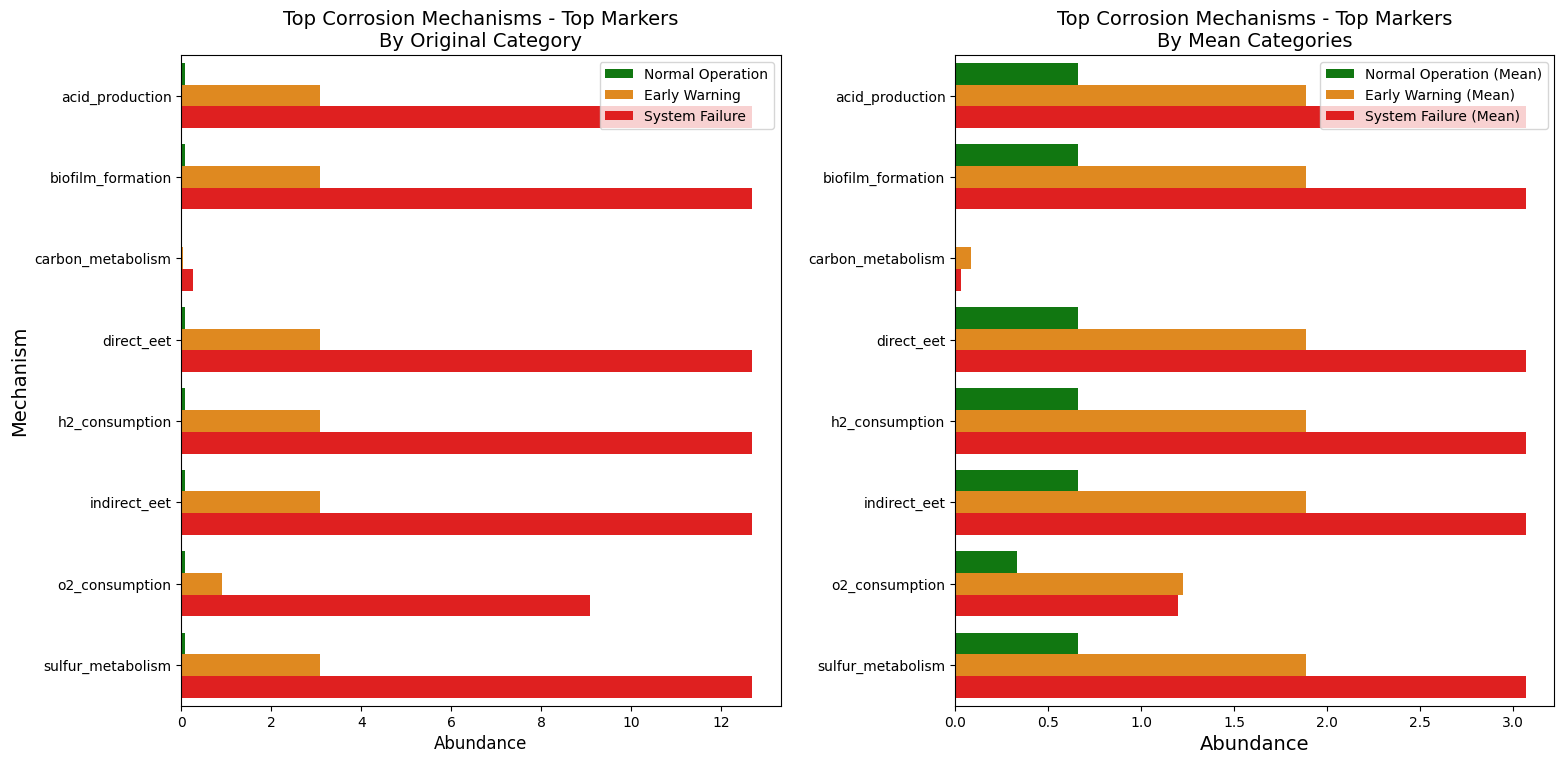

In [14]:
#Calling the function:
fig = corrosion_mechanism_original_vs_mean(top_markers, "Top Markers",  top_n=50)
plt.show()

The use of the original column of category and the mean shows that the mean actually try to homogenise the data on a way, however the main metabolisms remain to be the same first the H2 consumption , followed by direct electron transference, acid production and sulfur metabolism on top markers. 

## 3.3 Pathway Data across Risk Categories

### MultiPathway Analysis

In [15]:
def extract_pathways(df, pathway_column='pathways'):
    """Extract and count unique pathways from a DataFrame."""
    all_pathways = []

    for pathways in df[pathway_column].dropna():
        if isinstance(pathways, str):
            # Split by semicolons and clean up each pathway
            pathway_list = [p.strip() for p in pathways.split(';')]
            all_pathways.extend(pathway_list)

    # Count occurrences of each pathway
    pathway_counts = pd.Series(all_pathways).value_counts()

    return pathway_counts

def categorize_pathway_with_global_terms(pathway, pathway_patterns):
    """
    Categorize pathway using the global_terms pathway_patterns.
        Parameters:    pathway: String containing pathway name
        pathway_patterns: Dictionary mapping category names to lists of related terms in this case from global terms
    Returns:  Category name if found, raw pathways otherwise
    """
    pathway = pathway.lower()
    # Iterate over each category and check if any patterns match the pathway name
    for category, patterns in pathway_patterns.items(): 
        for pattern in patterns:
            if re.search(pattern, pathway, flags=re.IGNORECASE):
                return category
    return pathway  # if no pattern matches, return the raw entry

def plot_pathway_analysis(prioritized_markers, name, top_n=100):
    """
    Creates comprehensive visualizations of pathway data across risk categories,
    using the global_terms pathway categories for classification.
    """
       
    # Select top markers based on combined score
    top_markers = prioritized_markers.sort_values('combined_score', ascending=False).head(top_n)
    
    # Extract pathway information
    pathway_counts = extract_pathways(top_markers)
    common_pathways = pathway_counts[pathway_counts >= 2].index.tolist()
    
    # Categorize pathways using global terms
    pathway_categories_count = {}
    for pathway in common_pathways:
        category = categorize_pathway_with_global_terms(pathway, pathway_categories)
        pathway_categories_count[category] = pathway_categories_count.get(category, 0) + pathway_counts[pathway]
    
    category_df = pd.DataFrame({
        'Category': list(pathway_categories_count.keys()), 
        'Count': list(pathway_categories_count.values())
    }).sort_values('Count', ascending=False)
    
    # Prepare data for pathway analysis
    pathway_data = []
    for _, row in top_markers.iterrows():
        if isinstance(row['pathways'], str) and row['pathways']:
            row_pathways = [p.strip() for p in row['pathways'].split(';')]
            for pathway in row_pathways:
                if pathway in common_pathways:
                    pathway_data.append({
                        'Pathway': pathway,
                        'Category': categorize_pathway_with_global_terms(pathway, pathway_categories),
                        'Category 1': row['mean_cat1'] if pd.notna(row['mean_cat1']) else 0,
                        'Category 2': row['mean_cat2'] if pd.notna(row['mean_cat2']) else 0,
                        'Category 3': row['mean_cat3'] if pd.notna(row['mean_cat3']) else 0,
                    })
    
    pathway_df = pd.DataFrame(pathway_data)
    
    # Aggregate pathway data by category
    agg_pathway = pathway_df.groupby('Category').agg({
        'Category 1': 'mean', 
        'Category 2': 'mean', 
        'Category 3': 'mean'
    }).reset_index()
    
    # Calculate Category 3 to Category 1 ratio with protection against zero division
    agg_pathway['Cat3_to_Cat1_Ratio'] = agg_pathway.apply(
        lambda x: x['Category 3'] / x['Category 1'] if x['Category 1'] > 0 else 
                (10 if x['Category 3'] > 0 else 1), 
        axis=1
    )
    
    # Sort by ratio (high to low)
    agg_pathway = agg_pathway.sort_values('Cat3_to_Cat1_Ratio', ascending=False)
    
    # Create visualization subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Plot 1: Category Distribution
    sns.barplot(data=category_df, x='Count', y='Category', color='skyblue', ax=axes[0, 0])
    for i, bar in enumerate(axes[0, 0].patches):
        axes[0, 0].text(
            bar.get_width() + 0.3, 
            bar.get_y() + bar.get_height() / 2, 
            f"{int(bar.get_width())}", 
            ha='left', va='center', fontsize=12
        )
    axes[0, 0].set_title('Distribution of Pathway Categories', fontsize=18)
    axes[0, 0].tick_params(axis='both', labelsize=14)
    
    # Build network graph
    G = nx.Graph()
    
    # Add category nodes
    for category, count in pathway_categories_count.items():
        G.add_node(category, size=count, group=1)
    
    # Add genus nodes (top 10)
    genera_counts = top_markers['Genus'].value_counts().head(10)
    for genus, count in genera_counts.items():
        G.add_node(genus, size=count * 3, group=2)
    
    # Add edges between genera and categories
    for _, row in top_markers.iterrows():
        genus = row['Genus']
        if genus not in genera_counts:
            continue
            
        if isinstance(row['pathways'], str) and row['pathways']:
            pathways = [p.strip() for p in row['pathways'].split(';')]
            categories_added = set()
            
            for pathway in pathways:
                if pathway in common_pathways:
                    category = categorize_pathway_with_global_terms(pathway, pathway_categories)
                    if category not in categories_added:
                        if not G.has_edge(genus, category):
                            G.add_edge(genus, category, weight=1)
                        else:
                            G[genus][category]['weight'] += 1
                        categories_added.add(category)
    
    # Plot 2: Category enrichment ratio
    sns.barplot(data=agg_pathway, x='Cat3_to_Cat1_Ratio', y='Category', color='steelblue', ax=axes[1, 0])
    for i, bar in enumerate(axes[1, 0].patches):
        ratio_value = agg_pathway.iloc[i]['Cat3_to_Cat1_Ratio']
        axes[1, 0].text(
            bar.get_width() + 0.02, 
            bar.get_y() + bar.get_height() / 2, 
            f"{ratio_value:.2f}x", 
            ha='left', va='center', fontsize=12
        )
    axes[1, 0].axvline(x=1, color='gray', linestyle='--')
    axes[1, 0].set_title('Pathway Category Enrichment in High Risk (Cat3:Cat1 Ratio)', fontsize=18)
    axes[1, 0].tick_params(axis='both', labelsize=14)
    
    # Plot 3: Heatmap of category abundance
    heatmap_data = agg_pathway.set_index('Category')[['Category 1', 'Category 2', 'Category 3']].fillna(0)
    for idx in heatmap_data.index:
        row_max = heatmap_data.loc[idx].max()
        if row_max > 0:
            heatmap_data.loc[idx] = (heatmap_data.loc[idx] / row_max * 100).round(1)
    
    sns.heatmap(
        heatmap_data, 
        cmap='Blues', 
        annot=True, 
        fmt=".1f", 
        linewidths=0.5, 
        ax=axes[0, 1], 
        vmin=0, 
        vmax=100, 
        annot_kws={"size": 12}
    )
    axes[0, 1].set_title('Pathway Category Abundance Patterns (% of max)', fontsize=18)
    axes[0, 1].tick_params(axis='both', labelsize=14)
    
    # Plot 4: Network visualization
    pos = nx.spring_layout(G, k=0.3, seed=42)
    
    category_nodes = [node for node in G.nodes() if G.nodes[node].get('group', 0) == 1]
    genera_nodes = [node for node in G.nodes() if G.nodes[node].get('group', 0) == 2]
    
    node_sizes_cat = [G.nodes[node].get('size', 10) * 20 for node in category_nodes]
    node_sizes_gen = [G.nodes[node].get('size', 10) * 20 for node in genera_nodes]
    
    nx.draw_networkx_nodes(G, pos, nodelist=category_nodes, node_color='lightblue', 
                          node_size=node_sizes_cat, alpha=0.8, ax=axes[1, 1])
    nx.draw_networkx_nodes(G, pos, nodelist=genera_nodes, node_color='lightgreen', 
                          node_size=node_sizes_gen, alpha=0.8, ax=axes[1, 1])
    
    edge_weights = [G[u][v].get('weight', 1) / 2 for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, ax=axes[1, 1])
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif', ax=axes[1, 1])
    
    axes[1, 1].set_title('Genus-Pathway Category Network', fontsize=18)
    axes[1, 1].axis('off')
    
    # Overall layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle(f"Pathways Categories for {name}", fontsize=18, y=0.98)
    
    return fig, category_df, agg_pathway

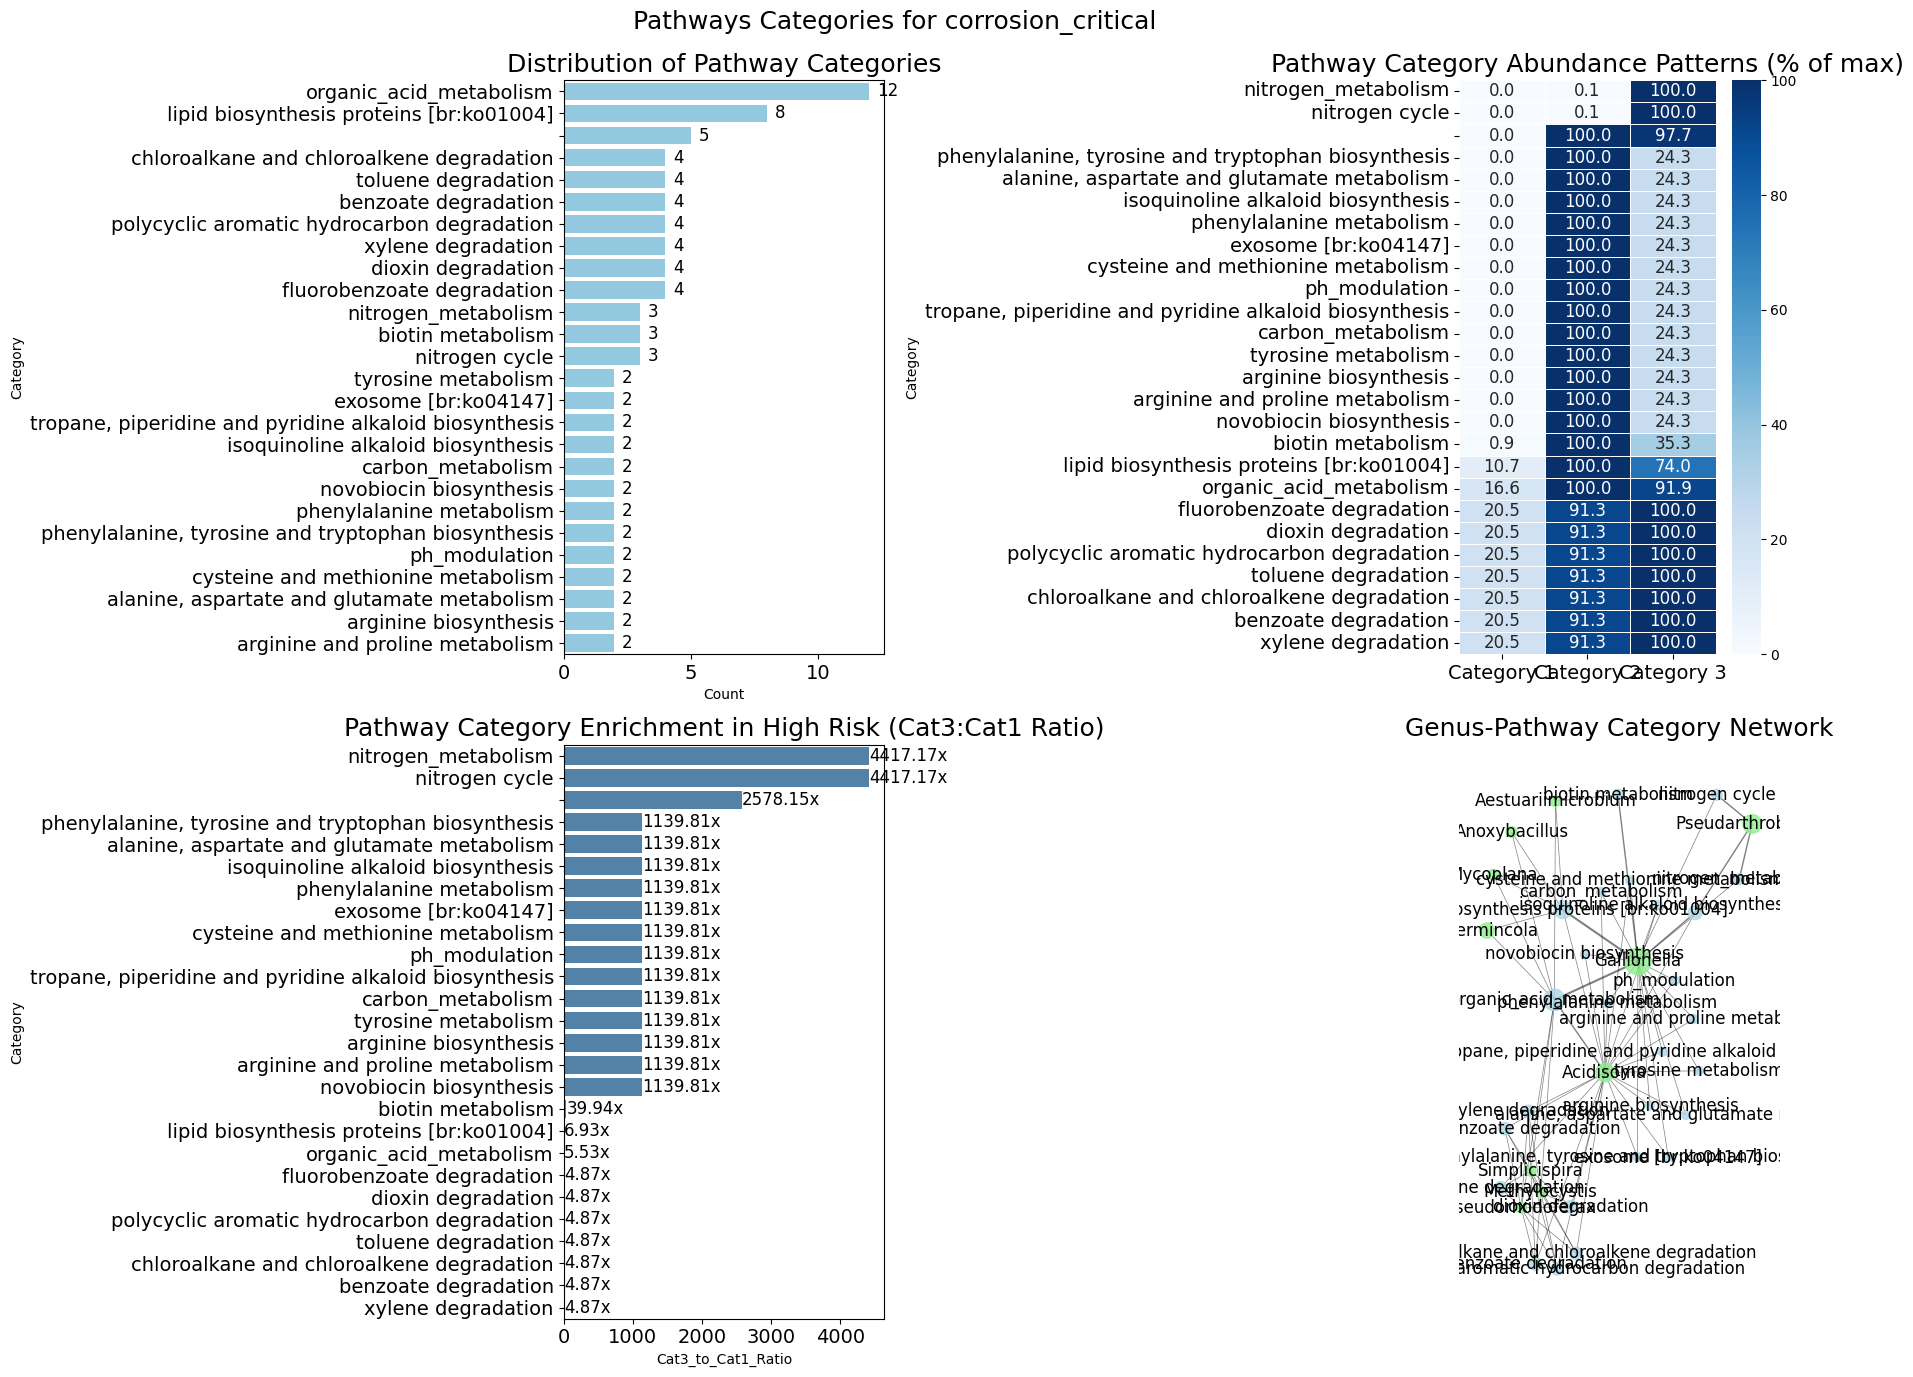

In [16]:

fig = plot_pathway_analysis(corrosion_critical, "corrosion_critical", top_n=20) 
plt.show()

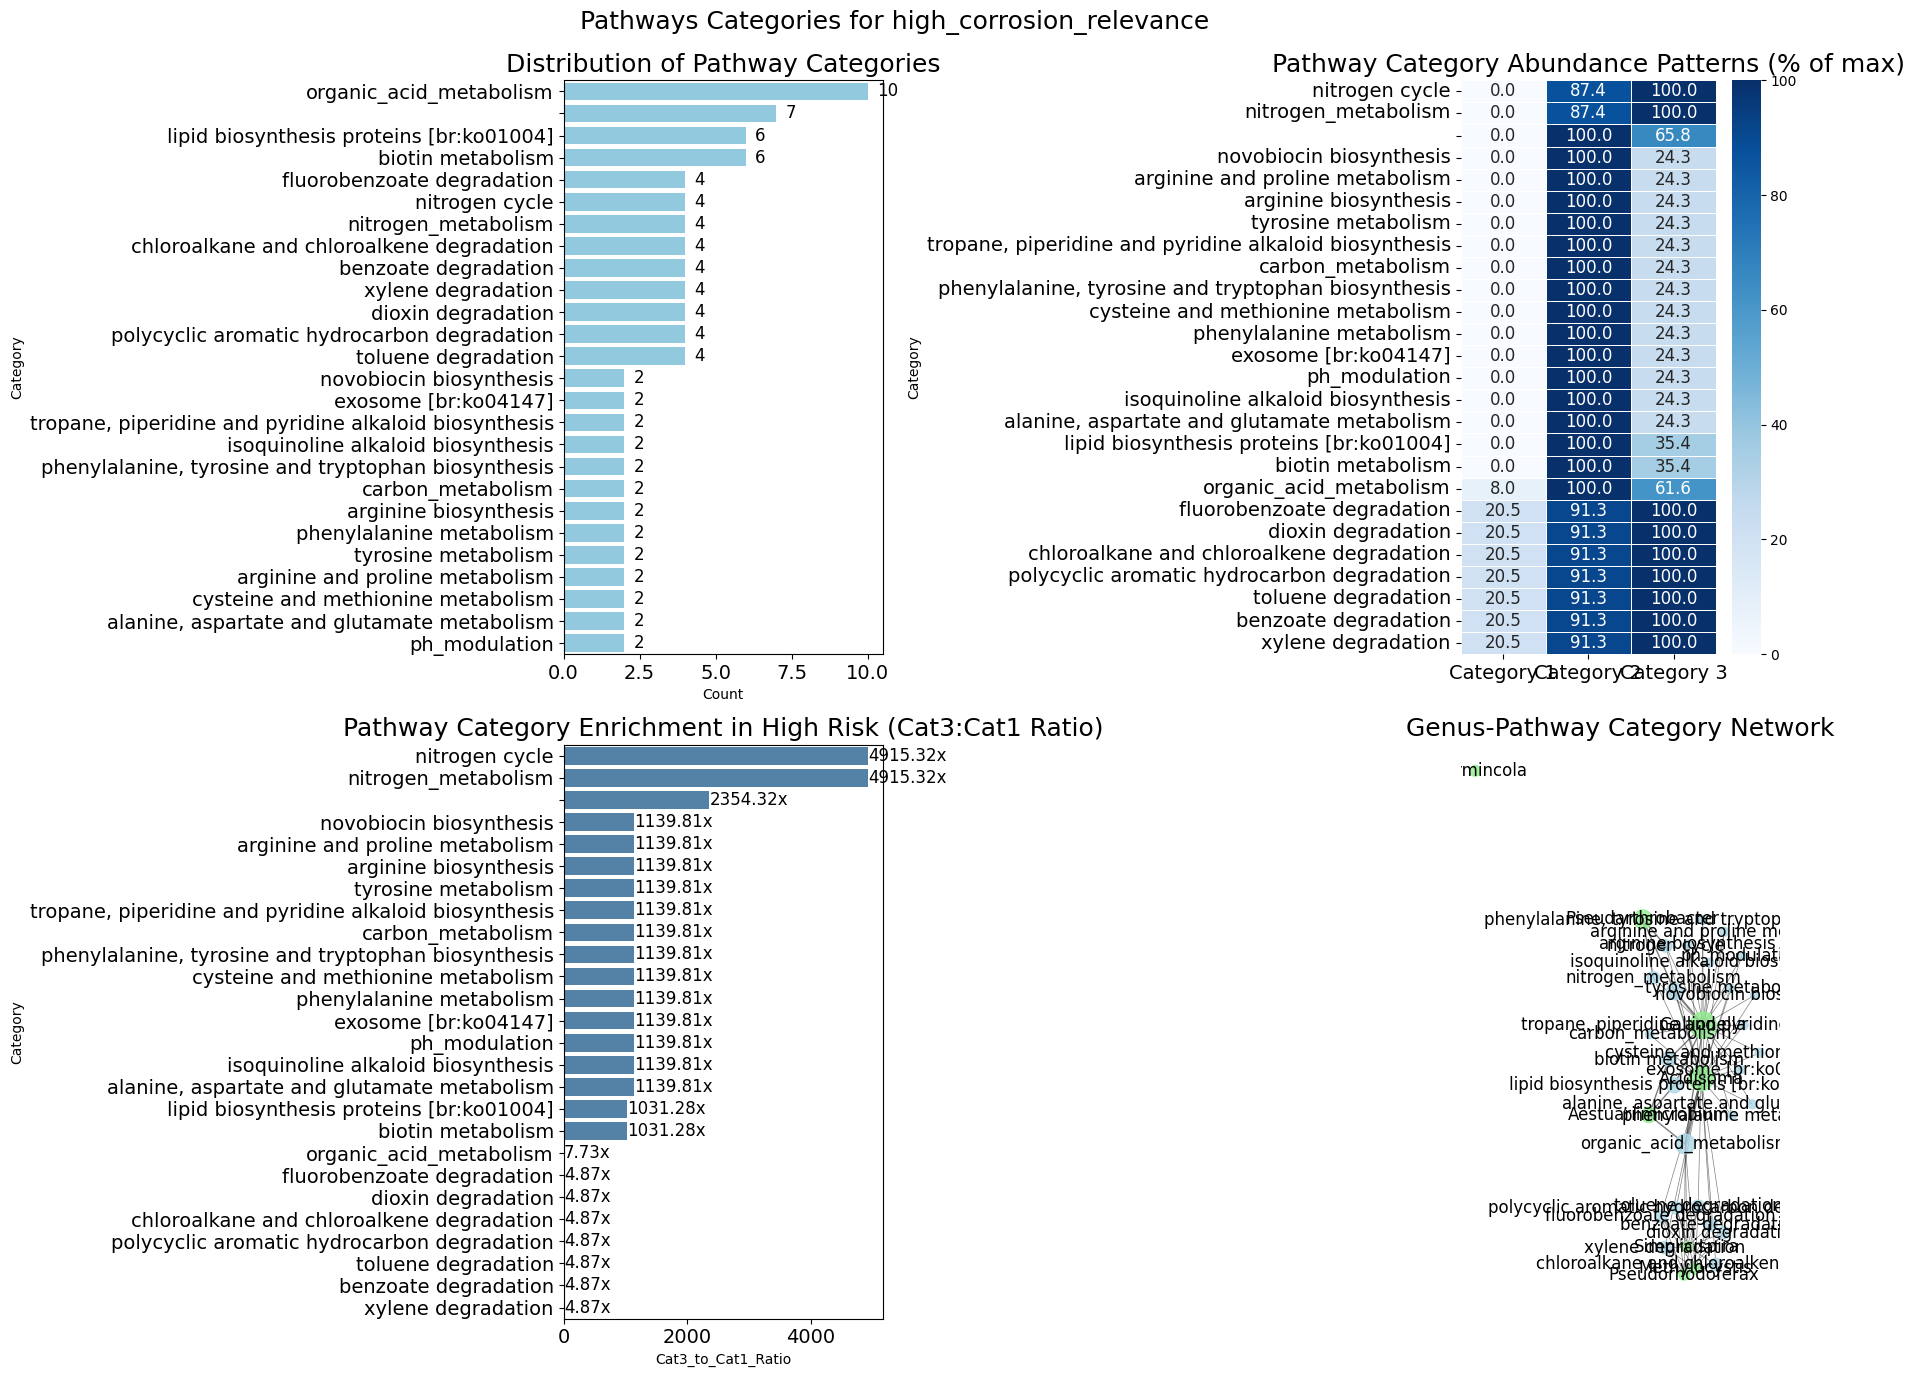

In [17]:
fig = plot_pathway_analysis(high_corrosion_relevance, "high_corrosion_relevance", top_n=20) 
plt.show()

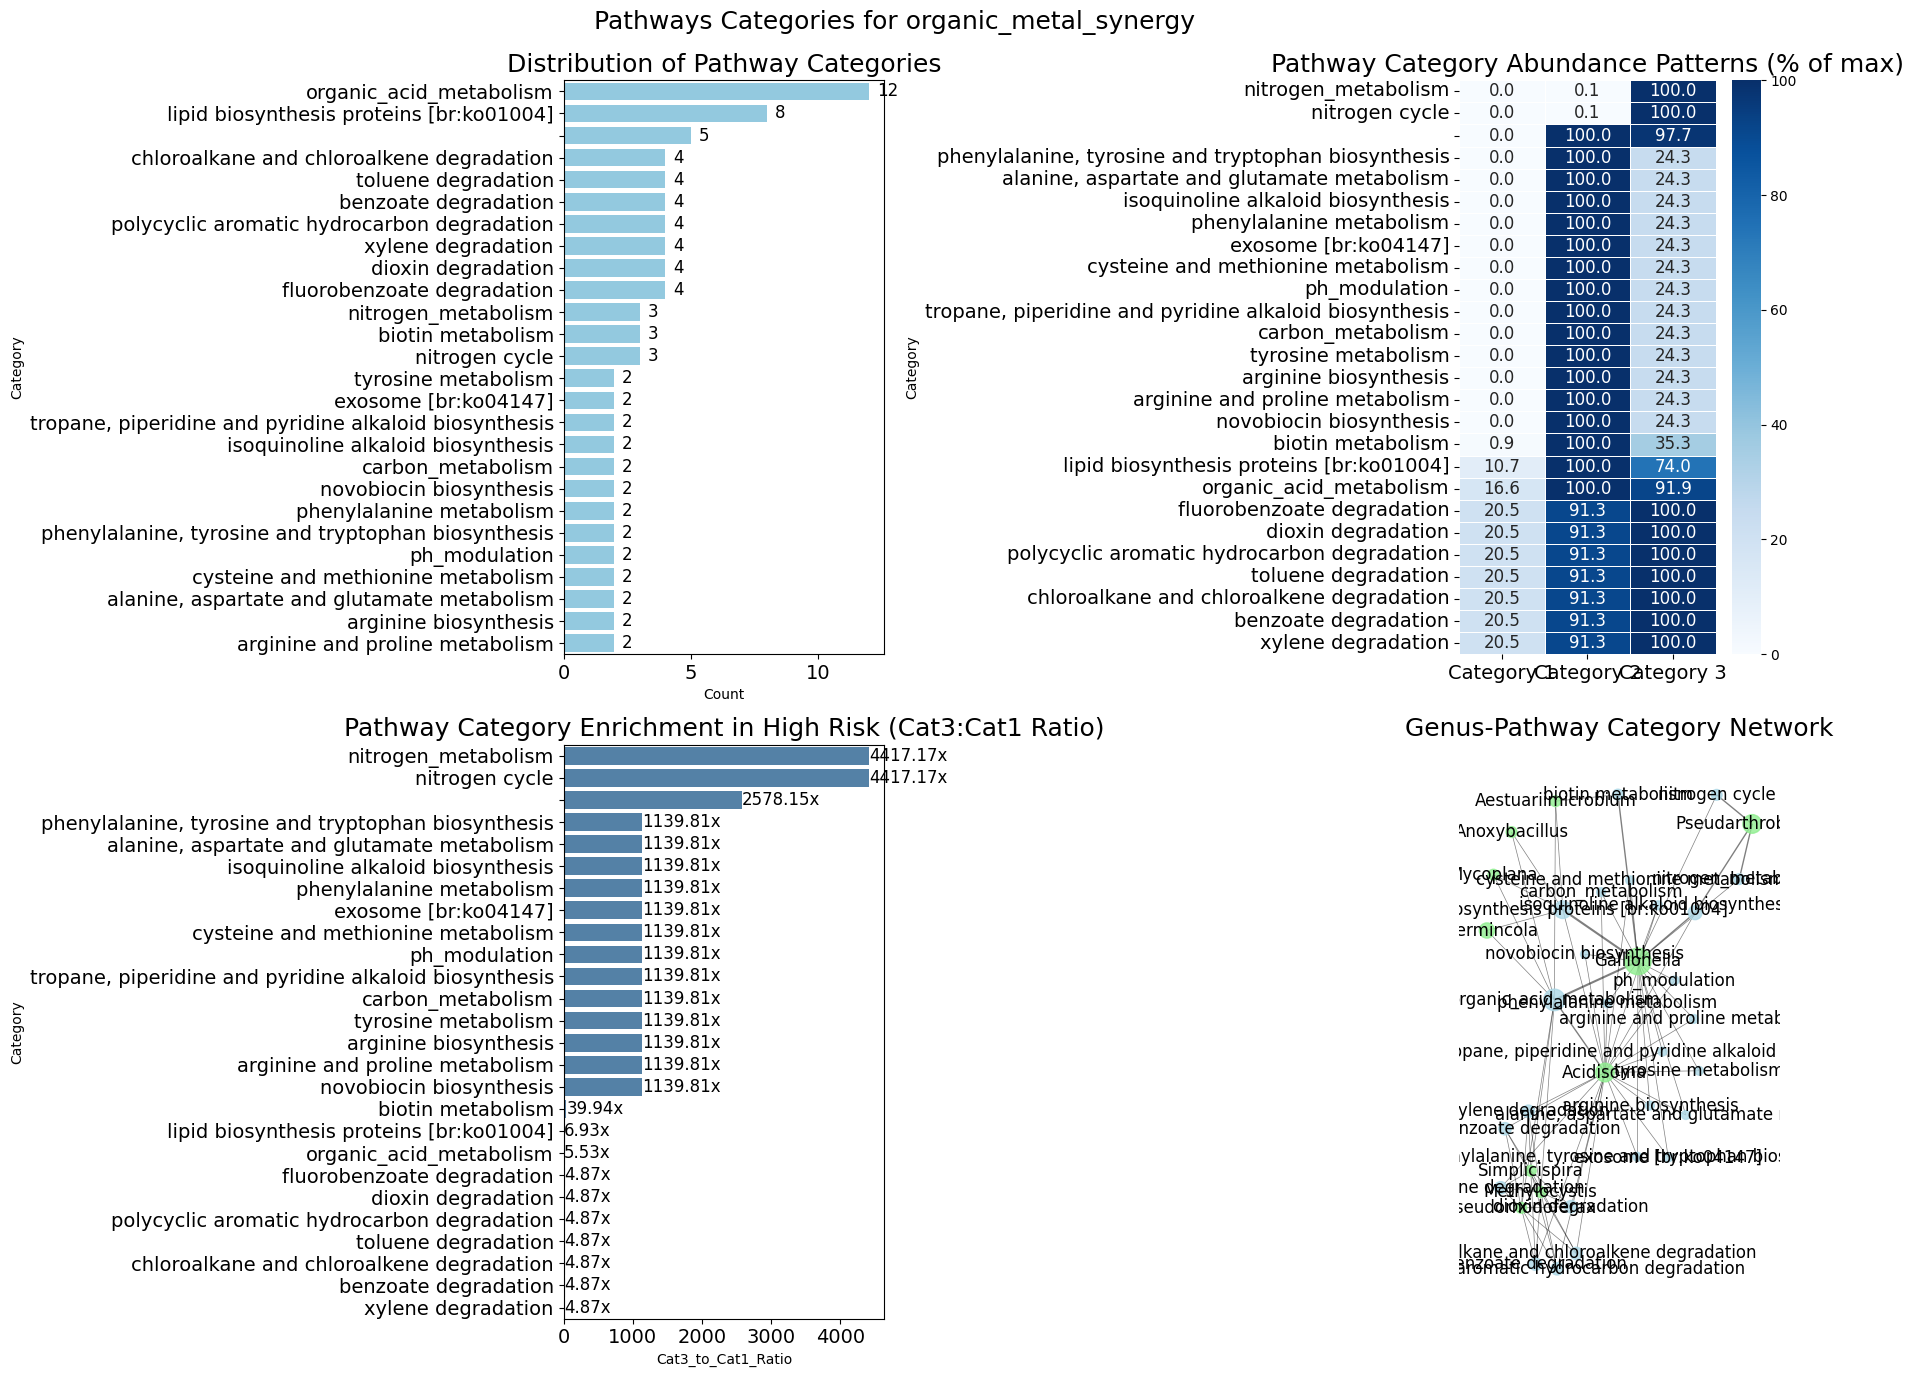

In [18]:
fig = plot_pathway_analysis(organic_metal_synergy,"organic_metal_synergy", top_n=20)

plt.show()


For the top markers group, the dominance of lipid metabolism is interesting...
for the high prevalence has the genera that prevale on each category, so the major metabolism is the biofilm formation which is also the one when it get enrich, that is because the biofilm produce an specialise environment where the bacteria thrive and prevail. It follows the protein metabolism with is important for survival, the degradation pathway which involves using the substrates from the env

## 3.4 Network Analysis of Corrosion Mechanisms

### Static Network

In [19]:
def create_static_network(df, name, top_n=20, threshold=0.5):
    """
    Creates a static network visualization of genus-protein-mechanism relationships.

    Args:
        df: DataFrame containing marker data with required columns
        top_n: Number of top markers to include
        threshold: Edge weight threshold (0.0-1.0)

    Returns:
        G: NetworkX graph object
    """

    # Define colors for node types
    node_colors = {
        'genus': '#2196F3',      # Blue
        'protein': '#4CAF50',    # Green
        'mechanism': '#FF5722'   # Orange-red
    }

    # Check required columns
    required_cols = ['Genus', 'protein_name', 'combined_score', 'corrosion_mechanisms']
    missing_cols = [col for col in required_cols if col not in df.columns]

    if missing_cols:
        print(f"Missing columns: {missing_cols}")
        print("Available columns:", df.columns.tolist())
        return None

    # Create network
    G = nx.Graph()

    # Get top markers
    top_markers = df.sort_values('combined_score', ascending=False).head(top_n)

    # Process rows and build network
    for _, row in top_markers.iterrows():
        genus = str(row['Genus'])
        protein = str(row['protein_name'])

        # Skip if missing data
        if pd.isna(genus) or pd.isna(protein):
            continue

        # Trim protein name if too long
        protein_short = protein[:27] + "..." if len(protein) > 30 else protein

        # Add nodes if they don't exist
        if not G.has_node(genus):
            G.add_node(genus, type='genus')

        if not G.has_node(protein_short):
            G.add_node(protein_short, type='protein')

        # Add edge between genus and protein with weight from score
        score = float(row.get('combined_score', 1.0)) if not pd.isna(row.get('combined_score')) else 1.0
        G.add_edge(genus, protein_short, weight=score)

        # Add mechanism nodes and edges
        mechanisms_col = row.get('corrosion_mechanisms', '')
        if isinstance(mechanisms_col, str) and mechanisms_col:
            for mech in mechanisms_col.split(';'):
                mech = mech.strip()
                if mech:  # Only add non-empty mechanisms
                    if not G.has_node(mech):
                        G.add_node(mech, type='mechanism')
                    G.add_edge(protein_short, mech, weight=1.0)

    # Detect communities
    partition = community_louvain.best_partition(G)

    # Assign communities to nodes
    nx.set_node_attributes(G, partition, 'community')

    # Prepare for visualization
    plt.figure(figsize=(15, 12))

    # Position nodes using force-directed layout
    pos = nx.spring_layout(G, k=0.3, seed=42)

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.4)

    # Draw nodes by type with different colors
    for node_type, color in node_colors.items():
        nodes = [node for node in G.nodes() if G.nodes[node].get('type') == node_type]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color,
                              node_size=500 if node_type == 'genus' else 300)

    # Draw labels differently for each type
    genera_labels = {n: n for n in G.nodes() if G.nodes[n].get('type') == 'genus'}
    nx.draw_networkx_labels(G, pos, labels=genera_labels, font_size=10, font_weight='bold')

    mech_labels = {n: n for n in G.nodes() if G.nodes[n].get('type') == 'mechanism'}
    nx.draw_networkx_labels(G, pos, labels=mech_labels, font_size=8)

    # Create legend
    plt.plot([0], [0], 'o', color=node_colors['genus'], label='Genus')
    plt.plot([0], [0], 'o', color=node_colors['protein'], label='Protein')
    plt.plot([0], [0], 'o', color=node_colors['mechanism'], label='Mechanism')
    plt.legend()

    plt.title(f"{name} Network of Top {top_n} Corrosion Markers")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return G

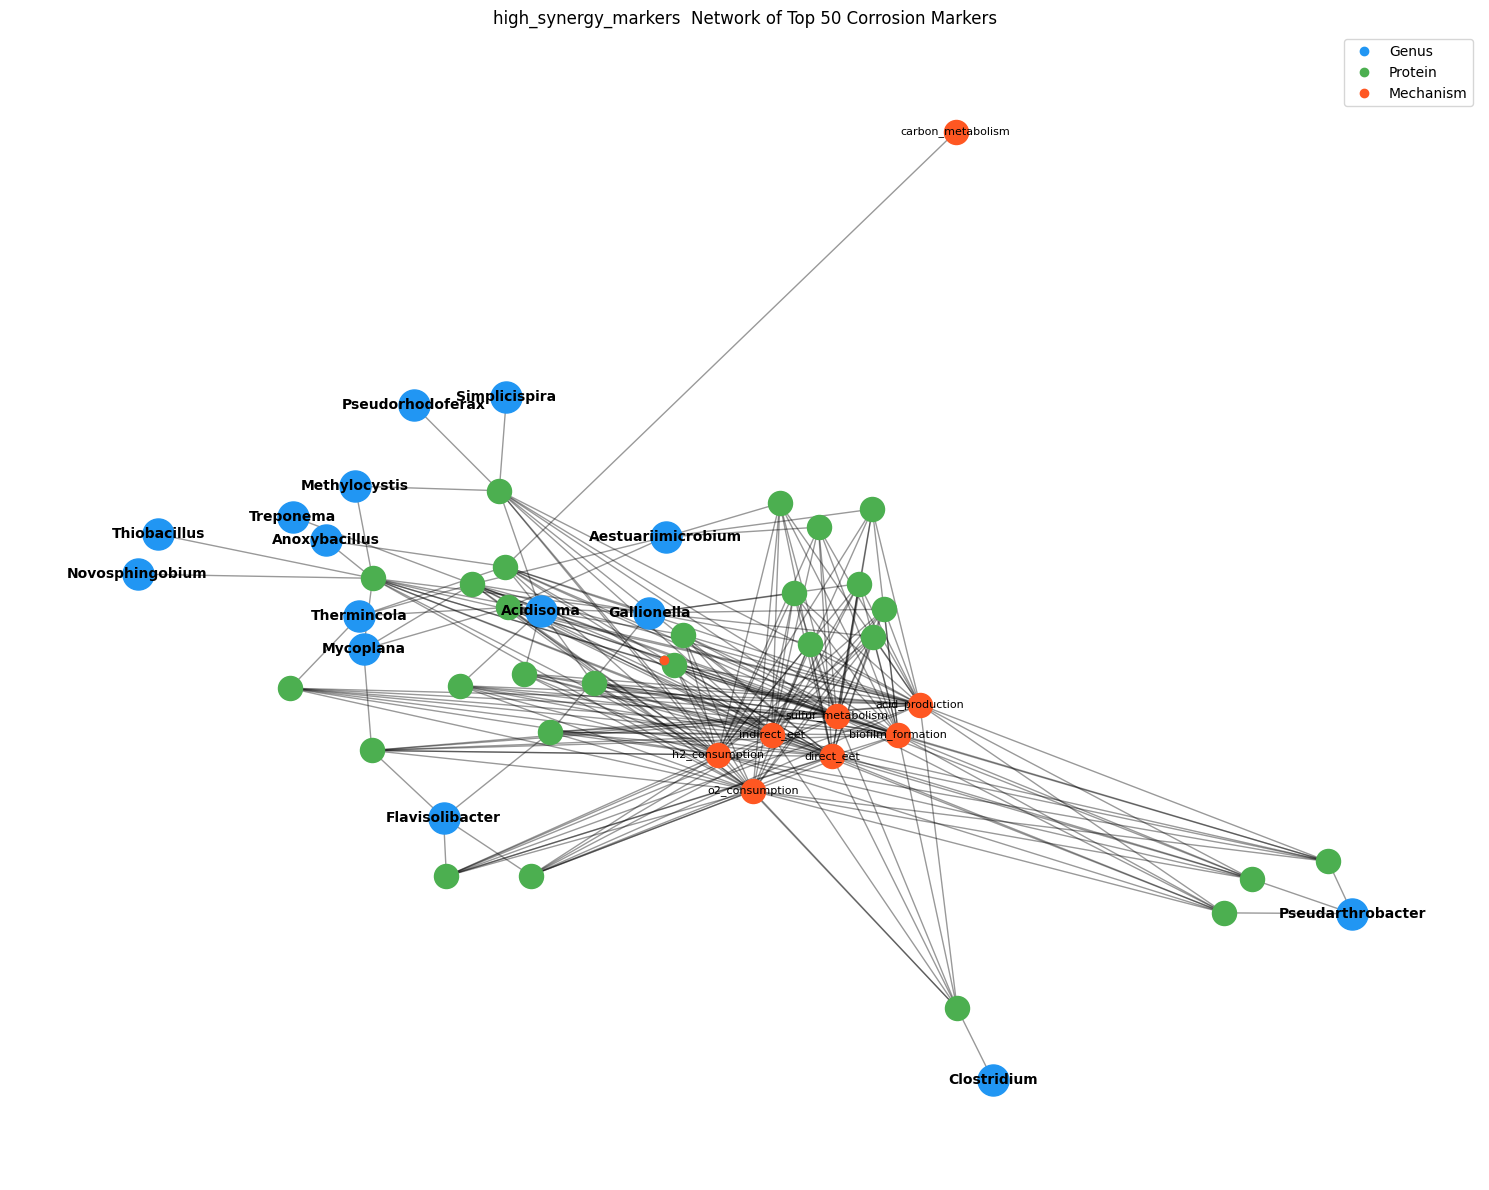

In [20]:
create_static_network(high_synergy_markers ,"high_synergy_markers " ,top_n=50, threshold=0.5)

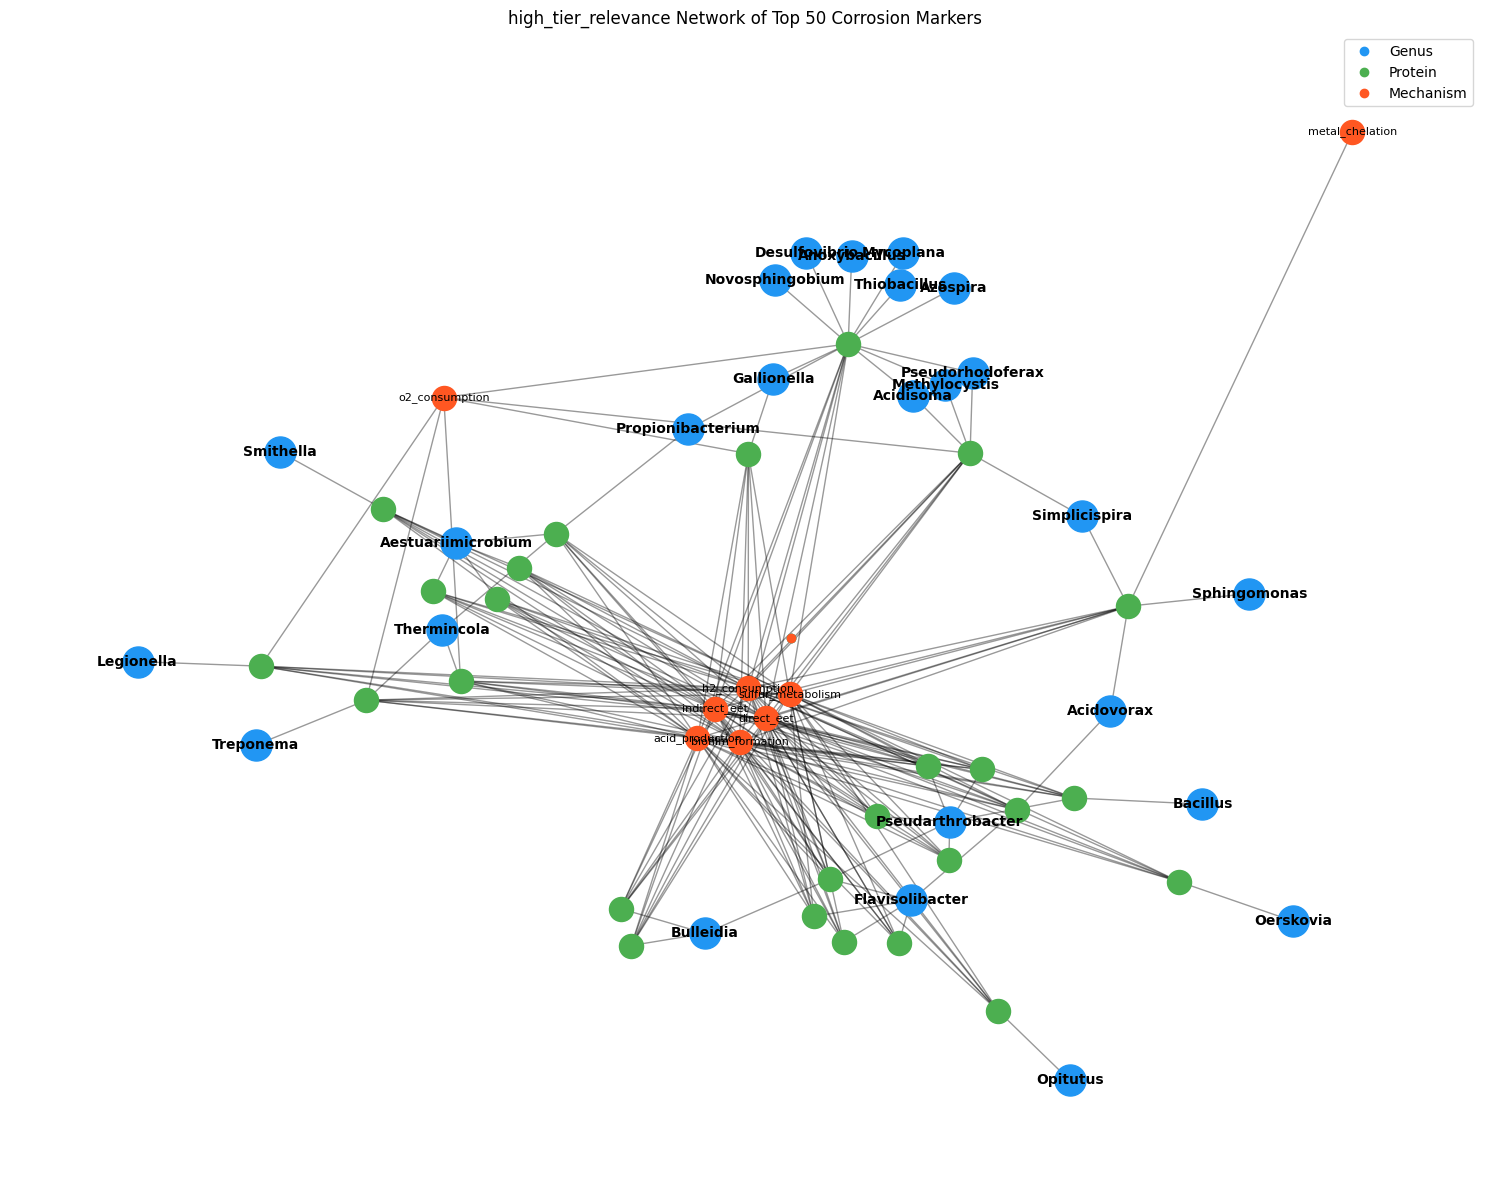

In [21]:

create_static_network(high_tier_relevance,"high_tier_relevance" ,top_n=50, threshold=0.5)

## 3.5. Temporal Transition and Mechanisms Distribution by Risk Categories
### Temporal Transition by Risk Categories

In [22]:
def temporal_transition(prioritized_markers, name):
    """
    Debugs issues with the temporal transition analysis and creates a Sankey diagram
    showing the flow of proteins between risk categories.
    """
    # Replace values directly within the Series (no rename() on Series)
    prioritized_markers['corrosion_mechanisms'] = prioritized_markers['corrosion_mechanisms'].str.replace('o2_consumption', 'O2_consumption').str.replace('h2_consumption', 'H2_consumption')
    # The issue might be with the 'significant' column - check its values
    sig_results= prioritized_markers.copy(deep=False)

    # Create category dominance for each protein-genus pair
    sig_results['dominant_category'] = sig_results[['mean_cat1', 'mean_cat2', 'mean_cat3']].idxmax(axis=1)
    sig_results['dominant_category'] = sig_results['dominant_category'].map({
        'mean_cat1': 'Category 1',
        'mean_cat2': 'Category 2',
        'mean_cat3': 'Category 3'
    })

    print(f"Distribution by dominant category: {sig_results['dominant_category'].value_counts().to_dict()}")

    # Group by genus and corrosion mechanism
    flow_data = []
    mechanisms_set = set()

    # Try different separator characters
    for separator in [';', ',', '|']:
        print(f"\nTrying separator: '{separator}'")
        mechanism_count = 0

        for _, row in sig_results.iterrows():
            if isinstance(row['corrosion_mechanisms'], str) and row['corrosion_mechanisms']:
                mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(separator) if m.strip()]
                mechanism_count += len(mechanisms)

                if len(mechanisms) > 0:
                    # If we found mechanisms, break out of the separator loop
                    break

        print(f"Found {mechanism_count} mechanisms with separator '{separator}'")
        if mechanism_count > 0:
            # We found our separator
            break

    # Use the best separator found
    for _, row in sig_results.iterrows():
        if isinstance(row['corrosion_mechanisms'], str) and row['corrosion_mechanisms']:
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(separator) if m.strip()]

            for m in mechanisms:
                mechanisms_set.add(m)  # Track all unique mechanisms

                # Determine the dominant category for this protein
                dom_cat = row['dominant_category']

                # Add a flow from mechanism to dominant category
                flow_data.append({
                    'source': m,
                    'target': dom_cat,
                    'value': 1,  # Count each protein once
                    'genus': row['Genus'],
                    'protein': row['protein_name']
                })

    # Convert to DataFrame
    import pandas as pd
    flow_df = pd.DataFrame(flow_data)

    # Print some diagnostic info
    print(f"\nNumber of unique mechanisms: {len(mechanisms_set)}")
    print(f"Number of flows: {len(flow_df)}")

    # Check if we have any data before proceeding
    if len(flow_df) == 0:
        print("No flows found. Check the corrosion_mechanisms data format.")
        return None

     # Define the order of mechanisms acording to energy requeriments
    mechanism_order = [
        "O2_consumption",
        "H2_consumption",
        "direct_eet",
        "iron_metabolism",
        "sulfur_metabolism",
        "acid_formation",
        "biofilm_formation"
    ]

    # Filter to only include mechanisms that exist in the data
    mechanisms = [m for m in mechanism_order if m in mechanisms_set]

    # Add any mechanisms that weren't in the predefined order
    other_mechanisms = sorted(list(mechanisms_set - set(mechanism_order)))
    mechanisms.extend(other_mechanisms)

    # Categories in order
    categories = ['Category 1', 'Category 2', 'Category 3']
    all_nodes = mechanisms + categories

    # Map source and target to indices
    node_indices = {node: i for i, node in enumerate(all_nodes)}

    flow_df['source_idx'] = flow_df['source'].map(node_indices)
    flow_df['target_idx'] = flow_df['target'].map(node_indices)

    # Aggregate flows by source and target
    agg_flows = flow_df.groupby(['source_idx', 'target_idx']).size().reset_index(name='value')

    # Define node colors - use specified category colors
    category_colors = {
        'Category 1': '#008800',  # Dark green
        'Category 2': '#FF8C00',  # Dark orange
        'Category 3': '#FF0000'   # Red
    }

    # Generate mechanism colors - use a gradient
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    from matplotlib.colors import rgb2hex
    import numpy as np

    cmap = plt.cm.get_cmap('viridis', len(mechanisms))
    mechanism_colors = {m: rgb2hex(cmap(i)[:3]) for i, m in enumerate(mechanisms)}

    # Combine all colors
    node_colors = [mechanism_colors.get(node, '#9467bd') if node in mechanisms
                  else category_colors.get(node, '#1f77b4') for node in all_nodes]

    # Create labels with proper formatting
    labels = []
    for node in all_nodes:
        if node in mechanisms:
            # Truncate long mechanism names
            if len(node) > 25:
                labels.append(node[:22] + '...')
            else:
                labels.append(node)
        else:
            # Format category names
            labels.append(node)

    # Create Sankey diagram
    import plotly.graph_objects as go
    fig = go.Figure(data=[go.Sankey(
        arrangement="snap",  # Help prevent overlapping
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors,
            hoverinfo="all",
            hovertemplate="<b>%{label}</b><br>Count: %{value}<extra></extra>"
        ),
        link=dict(
            source=agg_flows['source_idx'],
            target=agg_flows['target_idx'],
            value=agg_flows['value'],
            hovertemplate="<b>%{source.label}</b> → <b>%{target.label}</b><br>Count: %{value}<extra></extra>"
        )
    )])

    fig.update_layout(
        title_text=(f"Metabolic Mechanisms flow for {name} group according to Risk Categories"),
        font_size=12,
        height=800,
        width=1200, margin=dict(l=50, r=50, t=50, b=50))

    return fig

In [23]:
fig = temporal_transition(classified_results, "classified_results")
fig.show()
fig = temporal_transition(significant_markers, "significant_markers")
fig.show()

Distribution by dominant category: {'Category 2': 19389, 'Category 3': 18553, 'Category 1': 11271}

Trying separator: ';'
Found 5 mechanisms with separator ';'

Number of unique mechanisms: 10
Number of flows: 186741


/tmp/ipykernel_27262/3691590594.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(mechanisms))


Distribution by dominant category: {'Category 3': 120, 'Category 2': 42}

Trying separator: ';'
Found 7 mechanisms with separator ';'

Number of unique mechanisms: 9
Number of flows: 903


/tmp/ipykernel_27262/3691590594.py:121: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



## 3.6 Mechanism Distribution across Risk Category

In [24]:
def plot_mechanism_distribution(prioritized_markers, name):
    """
    Creates stacked bar charts showing mechanism distribution across risk categories.
    """
    # Define colors and categories
    category_colors = {
        1: '#008800',  # Dark green - Normal Operation
        2: '#FF8C00',  # Dark orange - Early Warning
        3: '#FF0000'   # Red - System Failure
    }

    categories_labels = {
        1: 'Normal Operation',
        2: 'Early Warning',
        3: 'System Failure'
    }

    # Process mechanism data
    mech_data = []

    for _, row in prioritized_markers.iterrows():
        if isinstance(row['corrosion_mechanisms'], str) and row['corrosion_mechanisms']:
            mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
            for mech in mechanisms:
                mech_data.append({
                    'corrosion_mechanisms': mech,
                    'Category 1': row['mean_cat1'],
                    'Category 2': row['mean_cat2'],
                    'Category 3': row['mean_cat3']
                })

    # Convert to DataFrame
    mech_df = pd.DataFrame(mech_data)

    # Group by mechanism
    grouped = mech_df.groupby('corrosion_mechanisms').agg({
        'Category 1': 'sum',
        'Category 2': 'sum',
        'Category 3': 'sum'
    }).reset_index()

    # Calculate total abundance and sort
    grouped['total'] = grouped['Category 1'] + grouped['Category 2'] + grouped['Category 3']
    grouped = grouped.sort_values('total', ascending=False).head(10)

    # Prepare data for stacked bar chart
    data = []

    for category, color in zip(['Category 1', 'Category 2', 'Category 3'], category_colors.values()):
        data.append(
            go.Bar(
                name=category,
                x=grouped['corrosion_mechanisms'],
                y=grouped[category],
                text=grouped[category].round(2),
                textposition='auto',
                marker_color=color
            )
        )

    # Create figure
    fig = go.Figure(data=data)

    # Update layout
    fig.update_layout(
        barmode='stack',
        title=f"Top 10 Corrosion Mechanisms for Group {name} by Risk Category",
        xaxis_title='Corrosion Mechanisms',
        yaxis_title='Total Abundance',
        legend_title='Risk Category',
        hovermode='x',
        height=600,
        width=1000
    )

    return fig
    plt.show()

plot_mechanism_distribution(high_synergy_markers , "high_synergy_markers ")

In [25]:
plot_mechanism_distribution(balanced_markers , "balanced_markers ")

## 3.7 A  Dinamic Cluster Analysis UMAP visualizations colored by protein metadata

In [26]:
def create_dash_umap_visualization(marker_data, name):
    """
    Creates a Dash application with an interactive UMAP visualization
    of protein data with improved legend handling and interactivity
    
    Args:
        marker_data: DataFrame containing protein data and metadata
        
    Returns:
        Dash application object
    """
    # Create the Dash app
    app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
    
    # Get available columns for coloring
    metadata_columns = [col for col in marker_data.columns 
                        if not col.startswith('mean_') and col not in ['protein_name', 'Genus']]
    
    # Create app layout
    app.layout = html.Div([
        html.H2("Interactive Protein UMAP Visualization", style={'textAlign': 'center', 'margin': '20px'}),
        
        dbc.Row([
            # Controls panel
            dbc.Col([
                dbc.Card([
                    dbc.CardHeader("UMAP Controls"),
                    dbc.CardBody([
                        html.Label("Color By:"),
                        dcc.Dropdown(
                            id='color-by-dropdown',
                            options=[{'label': col, 'value': col} for col in metadata_columns],
                            value='corrosion_mechanisms' if 'corrosion_mechanisms' in metadata_columns else metadata_columns[0],
                            clearable=False
                        ),
                        html.Br(),
                        
                        html.Label("n_neighbors:"),
                        dcc.Slider(
                            id='n-neighbors-slider',
                            min=5,
                            max=50,
                            step=5,
                            value=15,
                            marks={i: str(i) for i in range(5, 51, 5)}
                        ),
                        html.Br(),
                        
                        html.Label("min_dist:"),
                        dcc.Slider(
                            id='min-dist-slider',
                            min=0.0,
                            max=0.9,
                            step=0.1,
                            value=0.1,
                            marks={i/10: str(i/10) for i in range(0, 10)}
                        ),
                        html.Br(),
                        
                        html.Label("Show Labels:"),
                        dbc.Checklist(
                            id='show-labels-toggle',
                            options=[
                                {'label': 'Show Labels', 'value': 'show'}
                            ],
                            value=['show']
                        ),
                        html.Br(),
                        
                        html.Label("Label Size:"),
                        dcc.Slider(
                            id='label-size-slider',
                            min=6,
                            max=14,
                            step=1,
                            value=10,
                            marks={i: str(i) for i in range(6, 15, 2)}
                        ),
                        html.Br(),
                        
                        html.Label("Point Size:"),
                        dcc.Slider(
                            id='point-size-slider',
                            min=5,
                            max=20,
                            step=1,
                            value=10,
                            marks={i: str(i) for i in range(5, 21, 5)}
                        ),
                        html.Br(),
                        
                        dbc.Button("Reset View", id="reset-button", color="primary")
                    ])
                ])
            ], width=3),
            
            # UMAP visualization
            dbc.Col([
                dcc.Loading(
                    id="loading-umap",
                    type="default",
                    children=dcc.Graph(id='umap-graph', style={'height': '80vh'})
                )
            ], width=9)
        ]),
        
        dbc.Row([
            dbc.Col([
                html.Div(id='selected-point-info', style={'margin': '20px'})
            ])
        ])
    ])
    
    @app.callback(
        [Output('umap-graph', 'figure'),
         Output('selected-point-info', 'children')],
        [Input('color-by-dropdown', 'value'),
         Input('n-neighbors-slider', 'value'),
         Input('min-dist-slider', 'value'),
         Input('show-labels-toggle', 'value'),
         Input('label-size-slider', 'value'),
         Input('point-size-slider', 'value'),
         Input('reset-button', 'n_clicks'),
         Input('umap-graph', 'clickData')]
    )
    def update_umap(color_by, n_neighbors, min_dist, show_labels, 
                   label_size, point_size, n_clicks, click_data):
        # Extract numerical data for UMAP
        numerical_cols = [col for col in marker_data.columns if col.startswith('mean_')]
        
        if len(numerical_cols) == 0:
            return go.Figure().update_layout(
                title="Error: No numerical columns found for UMAP projection",
                annotations=[{
                    'text': "No columns beginning with 'mean_' were found in the data",
                    'showarrow': False,
                    'font': {'size': 16}
                }]
            ), "No data available"
        
        # Prepare data for UMAP
        X = marker_data[numerical_cols].values
        
        # Create UMAP projection
        umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
        embedding = umap_model.fit_transform(X)
        
        # Create a DataFrame with the embedding
        umap_df = pd.DataFrame({
            'UMAP1': embedding[:, 0],
            'UMAP2': embedding[:, 1],
            'protein_name': marker_data['protein_name'].values,
            'Genus': marker_data['Genus'].values,
            'label': marker_data['Genus'] + '-' + marker_data['protein_name'].str[:10]
        })
        
        # Add the color column if it exists
        if color_by in marker_data.columns:
            umap_df[color_by] = marker_data[color_by].values
        
        # Create the figure
        if color_by in marker_data.columns:
            # Check if categorical or numerical
            if marker_data[color_by].dtype == 'object':
                # Categorical coloring
                fig = px.scatter(
                    umap_df, 
                    x='UMAP1', 
                    y='UMAP2', 
                    color=color_by,
                    hover_name='label',
                    hover_data=['protein_name', 'Genus'],
                    size_max=point_size,
                    opacity=0.7,
                    title=f'UMAP Projection of Protein Data for the Group {name} Colored by {color_by}'
                )
                
                # Improve legend appearance for categorical data
                fig.update_layout(
                    legend=dict(
                        orientation="h",
                        yanchor="bottom",
                        y=-0.2,
                        xanchor="center",
                        x=0.5,
                        font=dict(size=10),
                        itemsizing='constant'
                    )
                )
            else:
                # Numerical coloring
                fig = px.scatter(
                    umap_df, 
                    x='UMAP1', 
                    y='UMAP2', 
                    color=color_by,
                    hover_name='label',
                    hover_data=['protein_name', 'Genus'],
                    size_max=point_size,
                    opacity=0.7,
                    color_continuous_scale='viridis',
                    title=f'UMAP Projection of Protein Data for the Group {name} Colored by {color_by}'
                )
        else:
            # Default coloring
            fig = px.scatter(
                umap_df, 
                x='UMAP1', 
                y='UMAP2',
                hover_name='label',
                hover_data=['protein_name', 'Genus'],
                size_max=point_size,
                opacity=0.7,
                title='UMAP Projection of Protein Data'
            )
        
        # Add labels conditionally
        if 'show' in show_labels:
            for i, row in umap_df.iterrows():
                fig.add_annotation(
                    x=row['UMAP1'],
                    y=row['UMAP2'],
                    text=row['label'],
                    showarrow=False,
                    font=dict(size=label_size),
                    xshift=10,
                    yshift=10,
                    bgcolor="rgba(255, 255, 255, 0.5)"  # Semi-transparent background
                )
        
        # Update layout
        fig.update_layout(
            xaxis_title="UMAP Dimension 1",
            yaxis_title="UMAP Dimension 2",
            legend_title=color_by,
            height=700,
            margin=dict(l=10, r=10, t=80, b=80 if color_by in marker_data.columns and marker_data[color_by].dtype == 'object' else 10),
            hovermode='closest'
        )
        
        # Uniform marker size
        fig.update_traces(marker=dict(size=point_size))
        
        # Show information for clicked point
        if click_data:
            point_index = click_data['points'][0]['pointIndex']
            point_info = marker_data.iloc[point_index]
            
            info_html = html.Div([
                html.H5(f"Selected Protein: {point_info['protein_name']}"),
                html.P(f"Genus: {point_info['Genus']}"),
                html.P(f"Mechanism: {point_info.get('corrosion_mechanisms', 'N/A')}"),
                
                html.H6("Additional Information:"),
                html.Ul([
                    html.Li(f"{col}: {point_info[col]}") 
                    for col in point_info.index 
                    if col not in ['protein_name', 'Genus', 'corrosion_mechanisms'] 
                    and not col.startswith('mean_')
                ])
            ])
        else:
            info_html = html.Div([
                html.P("Click on a point to see detailed information")
            ])
        
        return fig, info_html
    
    return app

# umap visualising 

app = create_dash_umap_visualization(top_markers, name)
app.run(debug=True)

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## 3.7 B Static  Cluster Analysis UMAP visualizations colored by protein metadata- static

In [27]:
def create_simple_umap_visualization(marker_data,  name, top_n= 20, n_neighbors=15, min_dist=0.1, point_size=50, random_state=42):
    """
    Creates a basic UMAP visualization colored by dominant category
    """
    from matplotlib.lines import Line2D
    
    # Define the category colors as in original code
    category_colors = {
        1: '#008800',  # Dark green - Normal Operation
        2: '#FF8C00',  # Dark orange - Early Warning
        3: '#FF0000'   # Red - System Failure
    }
    
    categories_labels = {
        1: 'Normal Operation',
        2: 'Early Warning',
        3: 'System Failure'
    }
    
    marker_data = marker_data.head(top_n)
    # Extract numerical data for UMAP
    numerical_cols = [col for col in marker_data.columns if col.startswith('mean_')]
    X = marker_data[numerical_cols].values
    
    # Create UMAP projection
    umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
    embedding = umap_model.fit_transform(X)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Determine dominant category for each data point
    cat_columns = ['mean_cat1', 'mean_cat2', 'mean_cat3']
    dominant_cats = marker_data[cat_columns].idxmax(axis=1).map(lambda x: int(x[-1]))
    
    # Create a list of colors based on dominant category
    colors = [category_colors[cat] for cat in dominant_cats]
    
    # Create scatter plot
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=point_size, alpha=0.7)
    
    # Create legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
               label=label, markersize=10)
        for cat, (color, label) in enumerate(zip(
            [category_colors[1], category_colors[2], category_colors[3]],
            [categories_labels[1], categories_labels[2], categories_labels[3]]
        ), 1)
    ]
    
    ax.legend(handles=legend_elements, title="Dominant Category", 
             bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add basic labels
    for i, (_, row) in enumerate(marker_data.iterrows()):
        label = f"{row['Genus']}-{str(row['protein_name'])[:10]}"
        ax.text(embedding[i, 0], embedding[i, 1], label, 
              fontsize=8, ha='right', va='top',
              bbox=dict(facecolor='white', alpha=0.3, pad=0.6))
    
    # Set title and labels
    ax.set_title(f"UMAP Projection of Protein Data for group {name}", fontsize=16)
    ax.set_xlabel('UMAP Dimension 1', fontsize=14)
    ax.set_ylabel('UMAP Dimension 2', fontsize=14)
    
    plt.tight_layout()
    return fig

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



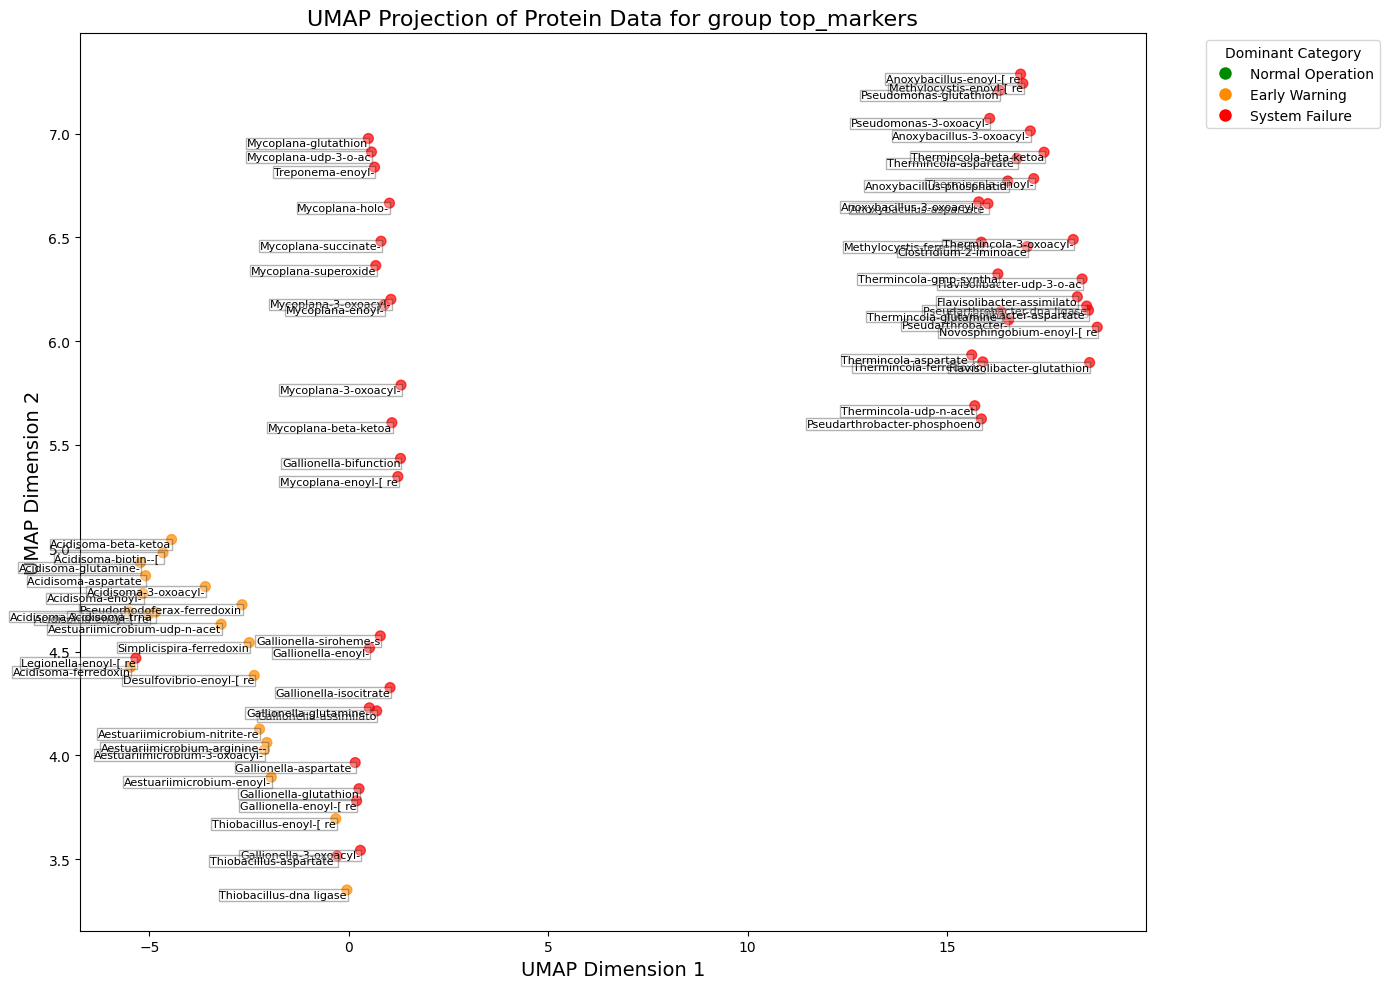

In [28]:
plot = create_simple_umap_visualization(top_markers, "top_markers", 70, n_neighbors=10, min_dist=0.1, point_size=50)
# Display the figure
plt.show()

The group top_markers shows that the system failure markers (red) dominate the majority of the plot and appear in almost all bacterial genera, which is expected because those are the filtered pair genus-protein markers coming from the pipeline in which were classified, scored and separated according to the bacteria abundance, relationship to the risk label and biological relevance scoring, so it is no a surprise if only category 2 and 3 are present. In the system failure some protein-genus are associated such as propionibacterium and Propionivibrio proteins, most Pseudarthrobacter proteins and several Pseudomonas proteins. The category 2, early warning markers (orange) cluster prominently in the right side of the plot (Porphyrobacter proteins), appear in selected Pseudorhodeferax proteins and several instances in Prevotella markers.

The Porphyrobacter cluster (right side) is predominantly associated with early warning status
Propionibacterium/Propionivibrio clusters (upper left) primarily indicate system failure
Pseudarthrobacter markers in the middle regions consistently indicate system failure. There is biological coherence since those enzymatic functions align strongly with the operational indicators.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



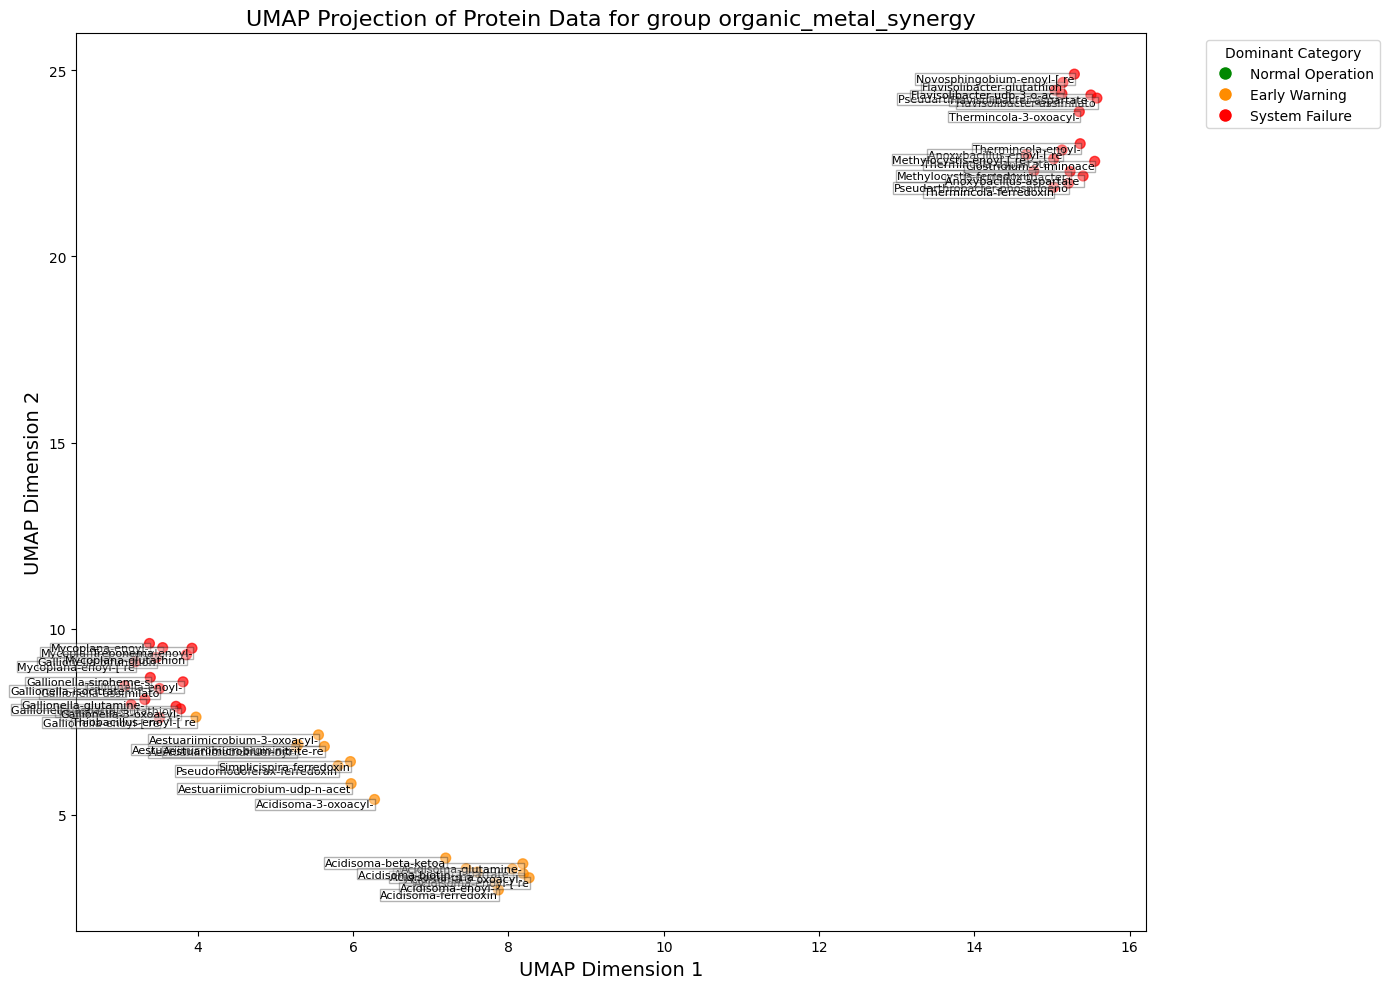

In [29]:

plot = create_simple_umap_visualization(organic_metal_synergy , "organic_metal_synergy", 50, n_neighbors=10, min_dist=0.1, point_size=50)
plt.show()


The umap proyection on group mechanism_acid_production show several clusters, sytem failure markers dominated the plot, in the bottom left 
Propionibacterium acid-producing enzymes, Pseudomonas, Propionivibrio, psb-m-3 and prevotela metabolic enzymes.Category 2 early warning markers (orange) show functional patterns: Prevotella enzymes (thiamine, threonine, diaminopimelate metabolism), selected Pseudorhodeferax proteins and Porphyrobacter acyl-homos proteins. The acid production mechanisms appear to have predictive value for system states, with specific metagenomic signatures correlating with different operational conditions.
Genus-level patterns emerge: Porphyrobacter appears to be an early warning indicator genus, Propionibacterium/Propionivibrio markers consistently signal system failure
Prevotella shows mixed indicators between early warning and system failure. Acid production enzymes strongly correlate with system status, transferases and certain dehydrogenases appear to have early warning potential. The cytosol and cell division proteins show consistent system failure indications. This suggests these enzyme functions have genuine predictive value

## 3.8. Functional categories Mechanism/Pathway heatmaps

In [30]:
def plot_functional_group_heatmap(classified_results, name, top_n=100):
    """
    Create side-by-side heatmaps grouped by mechanisms and pathway classification
    
    Parameters:
        classified_results: DataFrame with classified pathways
        name: Name of the group for title
        top_n: Number of top pairs to use (default: 100)
    
    Returns:
        matplotlib figure
    """
    # Get top markers
    top_markers = classified_results.head(top_n)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # First subplot: Mechanisms
    if 'corrosion_mechanisms' in top_markers.columns:
        # Extract all mechanisms
        all_mechanisms = set()
        for mechs in top_markers['corrosion_mechanisms'].dropna():
            if isinstance(mechs, str):
                all_mechanisms.update([m.strip() for m in mechs.split(';')])
        
        # Create a matrix: rows=genera, columns=mechanisms
        genera = top_markers['Genus'].unique()
        mechanisms = sorted(list(all_mechanisms))
        matrix = np.zeros((len(genera), len(mechanisms)))
        
        # Fill matrix with counts
        for i, genus in enumerate(genera):
            genus_markers = top_markers[top_markers['Genus'] == genus]
            for _, row in genus_markers.iterrows():
                if pd.notna(row['corrosion_mechanisms']) and isinstance(row['corrosion_mechanisms'], str):
                    marker_mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
                    for mechanism in marker_mechanisms:
                        if mechanism in mechanisms:
                            j = mechanisms.index(mechanism)
                            matrix[i, j] += 1
        
        # Use a better colormap for mechanisms
        cmap1 = LinearSegmentedColormap.from_list('corrosion', ['#FFFFFF', '#FF9966', '#CC3300'])
        sns.heatmap(matrix, cmap=cmap1, linewidths=0.5, linecolor='gray',
                   xticklabels=mechanisms, yticklabels=genera, ax=ax1)
        ax1.set_title(f'Genus-Mechanism Relationship')
        ax1.set_xlabel('Corrosion Mechanism')
        ax1.set_ylabel('Genus')
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # Second subplot: Pathway classification
    if 'pathway_classification' in top_markers.columns:
        # Create a matrix: rows=genera, columns=classifications
        genera = top_markers['Genus'].unique()
        classifications = ['universal', 'mixed', 'niche-specific']
        matrix = np.zeros((len(genera), len(classifications)))
        
        # Fill matrix with counts
        for i, genus in enumerate(genera):
            genus_markers = top_markers[top_markers['Genus'] == genus]
            for classification in classifications:
                j = classifications.index(classification)
                count = sum(genus_markers['pathway_classification'] == classification)
                matrix[i, j] = count
        
        # Plot
        cmap2 = LinearSegmentedColormap.from_list('pathways', ['#FFFFFF', '#66CCFF', '#003366'])
        sns.heatmap(matrix, cmap=cmap2, linewidths=0.5, linecolor='gray',
                   xticklabels=classifications, yticklabels=genera, ax=ax2)
        ax2.set_title(f"Genus-Pathway Classification Relationship")
        ax2.set_xlabel('Pathway Classification')
        ax2.set_ylabel('Genus')
    
    # Overall title
    plt.suptitle(f"Functional Relationships for {name} (Top {top_n} Proteins)", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    
    return fig

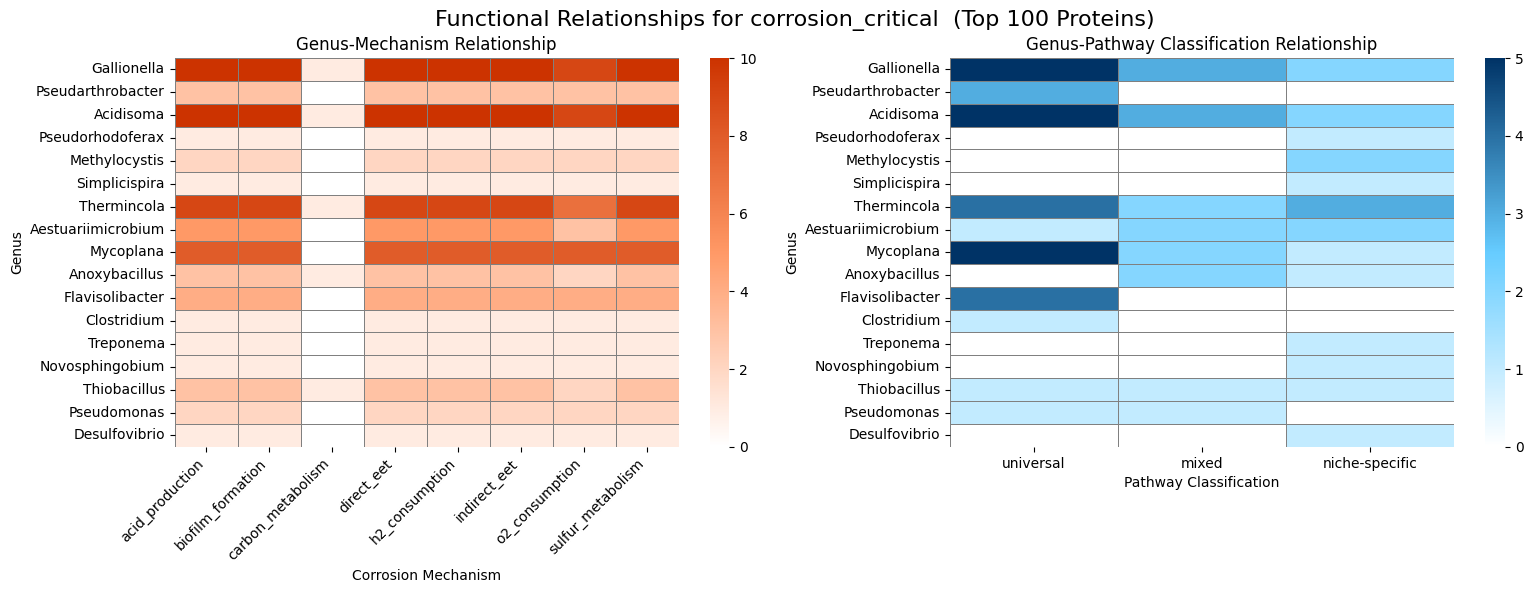

In [31]:
plot_functional_group_heatmap(corrosion_critical , "corrosion_critical ", top_n=100)
plt.show()

## 3.9. Genus-Mechanism Heatmap
Shows relationships between top genera and corrosion mechanisms

<Figure size 640x480 with 0 Axes>

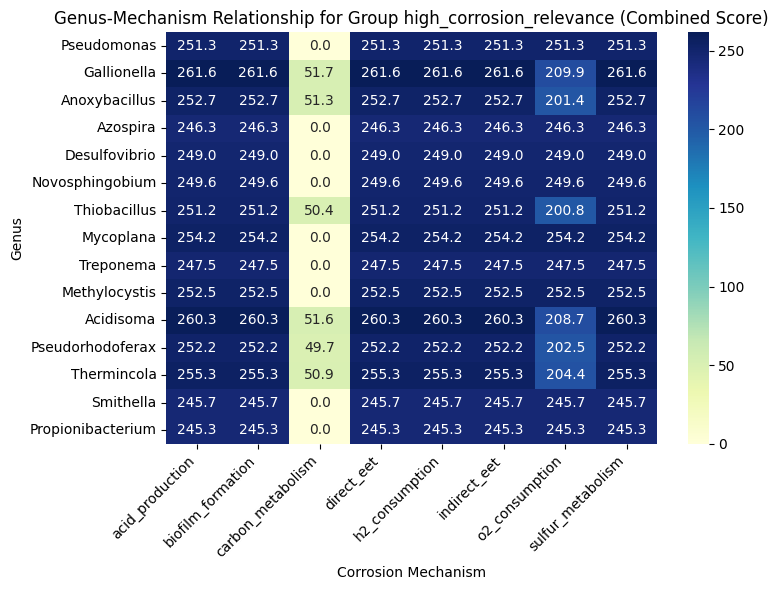

<Figure size 640x480 with 0 Axes>

In [32]:
def plot_genus_mechanism_heatmap(prioritized_markers, name, top_genera=10, top_markers_per_genus=5, figsize=None):
    """
    Create a heatmap showing top genera and their corrosion mechanisms
    """
    plt.close('all')
    # Ensure corrosion_mechanisms column exists
    if 'corrosion_mechanisms' not in prioritized_markers.columns:
        raise ValueError("DataFrame must contain 'corrosion_mechanisms' column")

    # Get top genera
    top_genera_list = prioritized_markers['Genus'].value_counts().head(top_genera).index.tolist()

    # Filter for top genera
    genus_df = prioritized_markers[prioritized_markers['Genus'].isin(top_genera_list)].copy(deep=False)

    # Get top markers per genus
    top_markers = []
    for genus in top_genera_list:
        genus_markers = genus_df[genus_df['Genus'] == genus].head(top_markers_per_genus)
        top_markers.append(genus_markers)

    top_markers_df = pd.concat(top_markers)

    # Extract all unique mechanisms
    all_mechanisms = set()
    for mechs in top_markers_df['corrosion_mechanisms'].dropna():
        if isinstance(mechs, str):
            all_mechanisms.update([m.strip() for m in mechs.split(';')])

    all_mechanisms = sorted(list(all_mechanisms))

    # Create matrix for heatmap (genus x mechanism)
    heatmap_data = np.zeros((len(top_genera_list), len(all_mechanisms)))

    # Fill matrix with scores
    for i, genus in enumerate(top_genera_list):
        genus_markers = top_markers_df[top_markers_df['Genus'] == genus]

        for _, row in genus_markers.iterrows():
            if pd.notna(row['corrosion_mechanisms']):
                mechanisms = [m.strip() for m in row['corrosion_mechanisms'].split(';')]
                score = row['combined_score']

                for mechanism in mechanisms:
                    if mechanism in all_mechanisms:
                        j = all_mechanisms.index(mechanism)
                        heatmap_data[i, j] += score

    # Create heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlGnBu',
                xticklabels=all_mechanisms, yticklabels=top_genera_list)

    plt.title(f'Genus-Mechanism Relationship for Group {name} (Combined Score)')
    plt.ylabel('Genus')
    plt.xlabel('Corrosion Mechanism')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.figure() 
    return plt.gcf()

plot_genus_mechanism_heatmap(high_corrosion_relevance, "high_corrosion_relevance", top_genera=15, top_markers_per_genus=5, figsize=(8, 6))

# 4. Proteins 
## 4.1. Protein Abundance Trajectories across risk categories

Fold change thresholds are standard practice (Love et al., 2014; DESeq2) the idea is to calculate which and how much the protein have an increase when changing the risk category from one lower to a high category. 
Reference
Love, M. I., Huber, W., & Anders, S. (2014). Moderated estimation of fold change and dispersion for RNA-seq data with DESeq2. Genome Biology, 15(12), 550. https://doi.org/10.1186/s13059-014-0550-8).

In [33]:
def plot_fold_change_increasing_only(marker_group, name, top_n=20, fold_change_type='3vs1'):
    """
    Creates a line chart showing only increasing protein abundance trajectories
    across risk categories with fold change hover details.
    """
    markers_df = marker_group.copy()
    
    required_cols = ['protein_name', 'Genus', 'mean_cat1', 'mean_cat2', 'mean_cat3']
    for col in required_cols:
        if col not in markers_df.columns:
            raise ValueError(f"Required column '{col}' not found in the data")
    
    min_threshold = 0.01

    if f'fold_change_{fold_change_type}' not in markers_df.columns:
        if fold_change_type == '3vs1':
            markers_df['fold_change_3vs1'] = (markers_df['mean_cat3'] + min_threshold) / (markers_df['mean_cat1'] + min_threshold)
            markers_df['log2fc_3vs1'] = np.log2(markers_df['fold_change_3vs1'])
        elif fold_change_type == '3vs2':
            markers_df['fold_change_3vs2'] = (markers_df['mean_cat3'] + min_threshold) / (markers_df['mean_cat2'] + min_threshold)
            markers_df['log2fc_3vs2'] = np.log2(markers_df['fold_change_3vs2'])
        elif fold_change_type == '2vs1':
            markers_df['fold_change_2vs1'] = (markers_df['mean_cat2'] + min_threshold) / (markers_df['mean_cat1'] + min_threshold)
            markers_df['log2fc_2vs1'] = np.log2(markers_df['fold_change_2vs1'])

    # Keep only increasing patterns
    markers_df = markers_df[
        (markers_df['mean_cat1'] < markers_df['mean_cat2']) &
        (markers_df['mean_cat2'] < markers_df['mean_cat3'])
    ]

    # Sort by fold change magnitude
    log2fc_col = f'log2fc_{fold_change_type}'
    markers_df['abs_log2fc'] = markers_df[log2fc_col].abs()
    top_markers = markers_df.sort_values('abs_log2fc', ascending=False).head(top_n)

    # Prepare trajectories
    trajectories = []
    for i, row in top_markers.iterrows():
        protein_name = row['protein_name']
        if isinstance(protein_name, str) and len(protein_name) > 30:
            protein_name = protein_name[:27] + "..."
        
        label = f"{row['Genus']} - {protein_name}"
        
        fold_change = row.get(f'fold_change_{fold_change_type}', 0)
        log2fc = row.get(log2fc_col, 0)

        trajectory = {
            'id': label,
            'Category 1': row['mean_cat1'],
            'Category 2': row['mean_cat2'],
            'Category 3': row['mean_cat3'],
            'fold_change': f"{fold_change:.2f}x",
            'log2fc': f"{log2fc:.2f}"
        }
        
        if 'combined_score' in row:
            trajectory['score'] = row['combined_score']
            
        trajectories.append(trajectory)

    traj_df = pd.DataFrame(trajectories)

    hover_data = ['fold_change', 'log2fc']
    if 'score' in traj_df.columns:
        hover_data.append('score')

    melted = pd.melt(
        traj_df,
        id_vars=['id'] + hover_data,
        value_vars=['Category 1', 'Category 2', 'Category 3'],
        var_name='category',
        value_name='abundance'
    )

    melted['category_num'] = melted['category'].map({
        'Category 1': 1,
        'Category 2': 2,
        'Category 3': 3
    })

    fig = px.line(
        melted,
        x='category_num',
        y='abundance',
        color='id',
        line_group='id',
        hover_data=hover_data,
        markers=True,
        title=f'Top {top_n} {name} by {fold_change_type} Fold Change',
        labels={'category_num': 'Risk Category', 'abundance': 'Mean Abundance'},
        height=600,
        width=1000
    )

    fig.update_xaxes(
        tickvals=[1, 2, 3],
        ticktext=['Category 1', 'Category 2', 'Category 3']
    )

    fig.update_layout(
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.5,
            xanchor="center",
            x=0.5
        ),
        margin=dict(
            b=150
        )
    )

    return fig

plot_fold_change_increasing_only(high_synergy_markers, "high_synergy_markers", top_n=20, fold_change_type='3vs1')

## 4.2. Protein Abundance Across Categories
Line plots showing how abundance changes across corrosion categories

In [34]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_abundance_across_categories(marker_group, name, top_n=25, sort_by='combined_score'):
    """
    Plot abundance patterns across corrosion categories for top markers.
    Uses global term dictionaries and pre-calculated fold change columns.
    
    Parameters:
        marker_group: DataFrame containing marker data
        name: Name of the group for the title
        top_n: Number of top markers to display
        sort_by: Column name to sort markers by (default: 'combined_score')
        
    Returns:
        Plotly figure object with the abundance plot
    """
    # Make a copy to avoid modifying the original
    markers_df = marker_group.copy()
    
    # Get mean columns
    mean_cols = [col for col in markers_df.columns if col.startswith('mean_cat')]
    if not mean_cols:
        raise ValueError("No mean abundance columns found (should start with 'mean_cat')")
    
    # Sort and get top markers
    if sort_by in markers_df.columns:
        top_markers = markers_df.sort_values(sort_by, ascending=False).head(top_n)
    else:
        # If sort column not found, try combined_score, otherwise sort by first mean column
        if 'combined_score' in markers_df.columns:
            top_markers = markers_df.sort_values('combined_score', ascending=False).head(top_n)
        else:
            top_markers = markers_df.sort_values(mean_cols[0], ascending=False).head(top_n)
    
    # Extract category numbers from column names
    categories = [col.replace('mean_cat', 'Category ') for col in mean_cols]
    category_nums = [int(col.replace('mean_cat', '')) for col in mean_cols]
    
    # Create a list to store traces for each marker
    traces = []
    
    # Add trace for each marker
    for i, (_, row) in enumerate(top_markers.iterrows()):
        # Create shorter, more readable labels
        protein_name = row['protein_name'] if 'protein_name' in row else row.get('Marker', 'Unknown')
        if isinstance(protein_name, str) and len(protein_name) > 20:
            protein_name = protein_name[:17] + "..."
        
        # Add genus for better identification
        label = f"{row.get('Genus', 'Unknown')} - {protein_name}"
        
        # Get abundance values
        values = [row[col] for col in mean_cols]
        
        # Add trace with hover information
        hover_text = []
        for i, cat in enumerate(categories):
            hover_info = f"Category: {cat}<br>Abundance: {values[i]:.4f}"
            
            # Add fold changes to hover info if available
            if 'fold_change_3vs1' in row and i == 2:  # For category 3
                hover_info += f"<br>FC vs Cat1: {row['fold_change_3vs1']:.2f}"
            if 'fold_change_2vs1' in row and i == 1:  # For category 2
                hover_info += f"<br>FC vs Cat1: {row['fold_change_2vs1']:.2f}"
            if 'fold_change_3vs2' in row and i == 2:  # For category 3
                hover_info += f"<br>FC vs Cat2: {row['fold_change_3vs2']:.2f}"
                
            # Add additional hover information if available
            if 'pattern' in row:
                hover_info += f"<br>Pattern: {row['pattern']}"
            if 'combined_score' in row:
                hover_info += f"<br>Score: {row['combined_score']:.2f}"
                
            hover_text.append(hover_info)
        
        # Create trace for this marker
        trace = go.Scatter(
            x=category_nums,
            y=values,
            mode='lines+markers',
            name=label,
            line=dict(width=2),
            marker=dict(size=8),
            hovertext=hover_text,
            hoverinfo='text'
        )
        
        traces.append(trace)
    
    # Create figure
    fig = go.Figure(data=traces)
    
    # Update layout with improved positioning
    fig.update_layout(
        title=f'Abundance Patterns of Group {name} Across Corrosion Categories (Top {top_n} Markers)',
        xaxis=dict(
            title='Corrosion Category',
            titlefont=dict(size=14),
            tickmode='array',
            tickvals=category_nums,
            ticktext=categories,
            domain=[0, 1]  # Full width for x-axis
        ),
        yaxis=dict(
            title='Mean Abundance',
            titlefont=dict(size=14)
        ),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.4,  # Adjusted to make more space between plot and legend
            xanchor="center",
            x=0.5
        ),
        margin=dict(t=100, b=150, l=100, r=100),  # More margin space
        height=700,  # Increased height
        width=1000,
        hovermode='closest',
        annotations=[
            dict(
                x=0.5,
                y=1.05,  # Position above the plot
                xref="paper",
                yref="paper",
                text="Corrosion Category",
                showarrow=False,
                font=dict(size=14)
            )
        ]
    )
    
    # Add grid
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    
    return fig

plot_abundance_across_categories(high_synergy_markers, "high_synergy_markers", top_n=25)

In [35]:
def plot_abundance_across_categories(marker_group, name, top_n=25, sort_by='combined_score'):
    """
    Plot abundance patterns across corrosion categories for top markers.
    
    Parameters:
        marker_group: DataFrame containing marker data
        name: Name of the group for the title
        top_n: Number of top markers to display
        sort_by: Column name to sort markers by (default: 'combined_score')
        
    Returns:
        Plotly figure object with the abundance plot
    """
    # Make a copy to avoid modifying the original
    markers_df = marker_group.copy()
    
    # Get mean columns
    mean_cols = [col for col in markers_df.columns if col.startswith('mean_cat')]
    if not mean_cols:
        raise ValueError("No mean abundance columns found (should start with 'mean_cat')")
    
    # Sort and get top markers
    if sort_by in markers_df.columns:
        top_markers = markers_df.sort_values(sort_by, ascending=False).head(top_n)
    else:
        # If sort column not found, try combined_score, otherwise sort by first mean column
        if 'combined_score' in markers_df.columns:
            top_markers = markers_df.sort_values('combined_score', ascending=False).head(top_n)
        else:
            top_markers = markers_df.sort_values(mean_cols[0], ascending=False).head(top_n)
    
    # Extract category numbers from column names
    categories = [col.replace('mean_cat', 'Category ') for col in mean_cols]
    category_nums = [int(col.replace('mean_cat', '')) for col in mean_cols]
    
    # Create a list to store traces for each marker
    traces = []
    
    # Add trace for each marker
    for i, (_, row) in enumerate(top_markers.iterrows()):
        # Create shorter, more readable labels
        protein_name = row['protein_name']
        if isinstance(protein_name, str) and len(protein_name) > 20:
            protein_name = protein_name[:17] + "..."
        
        # Add genus for better identification
        label = f"{row['Genus']} - {protein_name}"
        
        # Get abundance values
        values = [row[col] for col in mean_cols]
        
        # Add trace with hover information
        hover_text = []
        for i, cat in enumerate(categories):
            hover_info = f"Category: {cat}<br>Abundance: {values[i]:.4f}"
            
            # Add fold changes to hover info if available
            # Using pre-calculated fold change columns
            if i == 2 and 'fold_change_3vs1' in row:  # For category 3
                hover_info += f"<br>FC vs Cat1: {row['fold_change_3vs1']:.2f}"
            if i == 1 and 'fold_change_2vs1' in row:  # For category 2
                hover_info += f"<br>FC vs Cat1: {row['fold_change_2vs1']:.2f}"
            if i == 2 and 'fold_change_3vs2' in row:  # For category 3
                hover_info += f"<br>FC vs Cat2: {row['fold_change_3vs2']:.2f}"
            
            # Add additional hover information if available
            if 'pattern' in row:
                hover_info += f"<br>Pattern: {row['pattern']}"
            if 'combined_score' in row:
                hover_info += f"<br>Score: {row['combined_score']:.2f}"
                
            hover_text.append(hover_info)
        
        # Create trace for this marker
        trace = go.Scatter(
            x=category_nums,
            y=values,
            mode='lines+markers',
            name=label,
            line=dict(width=2),
            marker=dict(size=8),
            hovertext=hover_text,
            hoverinfo='text'
        )
        
        traces.append(trace)
    
    # Create figure
    fig = go.Figure(data=traces)
    
    # Update layout with improved x-axis title positioning
    fig.update_layout(
        title=f'Abundance Patterns of Group {name} Across Corrosion Categories (Top {top_n} Markers)',
        xaxis=dict(
            # Removing the x-axis title here as we'll add it as an annotation
            tickmode='array',
            tickvals=category_nums,
            ticktext=categories
        ),
        yaxis=dict(title='Mean Abundance'),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.5,
            xanchor="center",
            x=0.5
        ),
        margin=dict(b=150),
        height=600,
        width=1000,
        hovermode='closest',
        # Add annotation for x-axis title above the plot
        annotations=[dict(
            text="Corrosion Category",
            x=0.5,
            y=1.05,  # Position above the plot
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(size=14)
        )]
    )
    
    # Add grid
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    
    return fig

plot_abundance_across_categories(very_high_specificity, "very_high_specificity", top_n=25, sort_by='combined_score')

## 4.3. Top Protein Heatmap

In [36]:
def plot_top_protein_heatmap(df, name, top_proteins=20):
    # Sort by preferred significance metric
    top_proteins = df.sort_values(by='combined_score', ascending=False).head(top_proteins)

    # Select mean value columns for heatmap
    heatmap_data = top_proteins[['mean_cat1', 'mean_cat2', 'mean_cat3']]

    # Truncate long protein names for better visualization
    truncated_names = top_proteins['protein_name'].apply(lambda x: x if len(x) <= 70 else x[:17] + '...')

    # Create heatmap
    plt.figure(figsize=(8, 6))  # Adjusted figure size
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".2f",
        cmap='viridis',
        yticklabels=truncated_names,  # Use truncated names
        xticklabels=['Category 1', 'Category 2', 'Category 3']
    )

    plt.title(f" {name}Top Protein Expression Heatmap")
    plt.ylabel("Proteins")
    plt.xlabel("Risk Category")

    # Use tight_layout to minimize empty space
    plt.tight_layout()

    return plt.gcf()


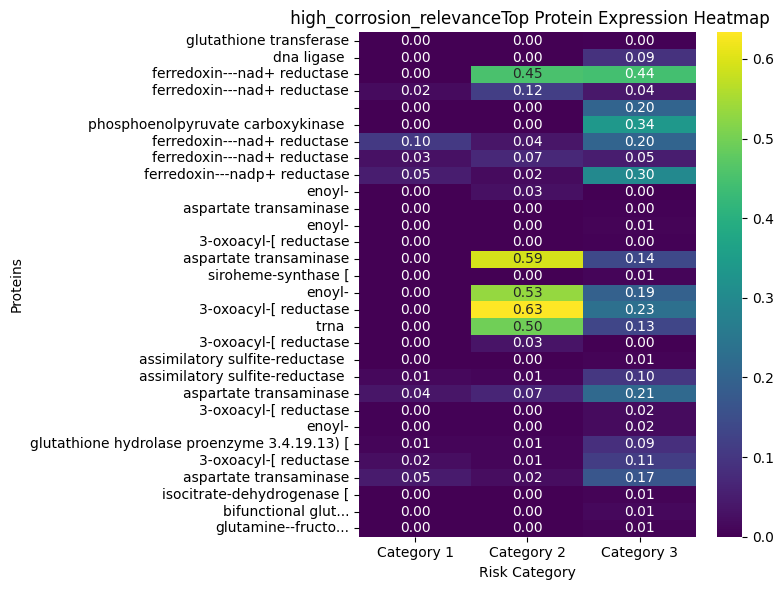

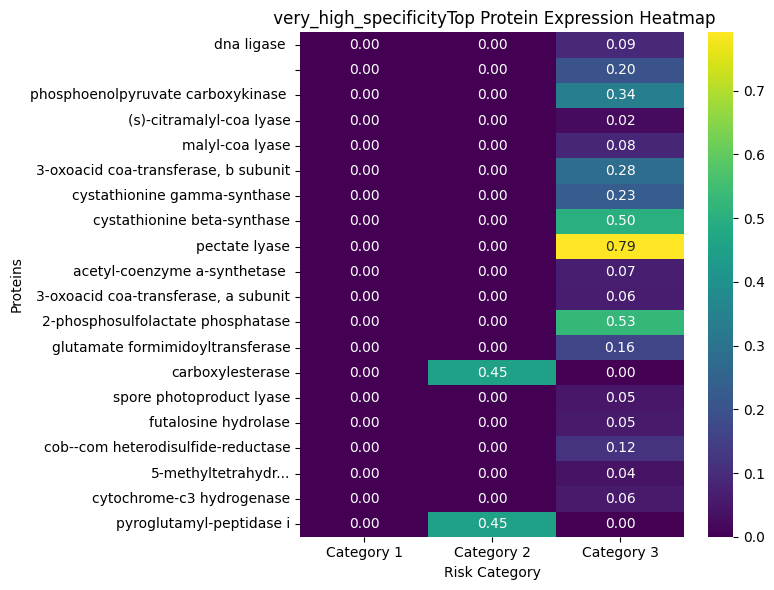

In [37]:
plot_top_protein_heatmap(high_corrosion_relevance, "high_corrosion_relevance", 30)
plt.show()
plot_top_protein_heatmap(very_high_specificity, "very_high_specificity", 20)
plt.show()

## 4.4. Top Markers by Score -
Bar chart showing the highest scoring markers

In [38]:
def plot_top_markers_by_score(prioritized_markers, name, top_n=20, figsize=(8, 6)):
    """
    Create a horizontal bar chart of top markers by score
    """
    # Get top markers
    top_markers = prioritized_markers.head(top_n)

    # Create labels
    labels = [f"{row['Genus']} - {row['protein_name'][:100]}"
              for _, row in top_markers.iterrows()]

    # Create figure
    plt.figure(figsize=figsize)

    # Plot horizontal bars
    plt.barh(range(len(labels)), top_markers['combined_score'], color='steelblue')

    # Add labels and title
    plt.yticks(range(len(labels)), labels)
    plt.xlabel('Combined Score')
    plt.title(f'Top {top_n} for the Group {name} Markers by Score')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    return plt.gcf()

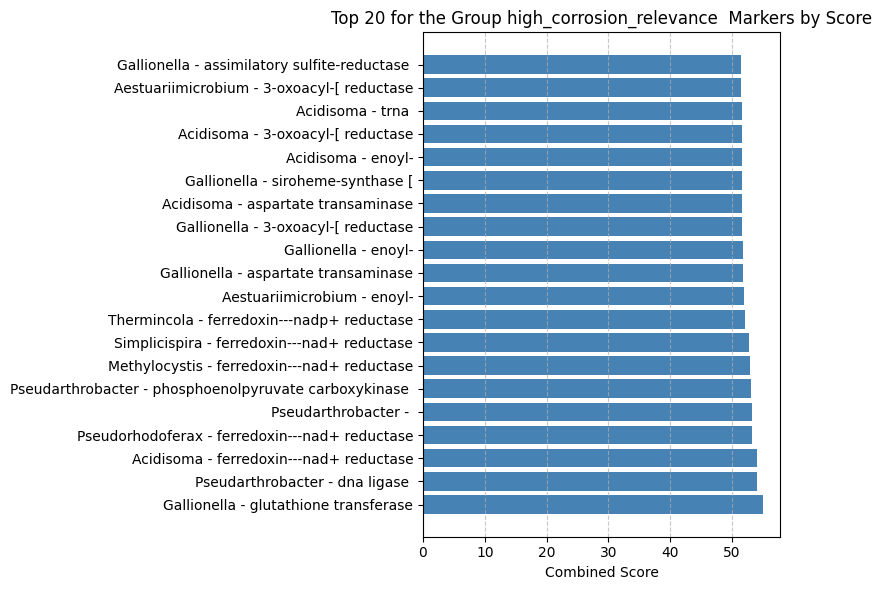

In [39]:
plot_top_markers_by_score(high_corrosion_relevance , "high_corrosion_relevance ", top_n=20, figsize=(8, 6))
plt.show()

## 4.5 Network Analysis Protein-Genus pair vs others

In [40]:
def create_static_network(df, name, top_n=20, threshold=0.5, category_col='mechanisms',  protein_label_legend=True):
    """
    Creates a static network visualization of genus-protein-category relationships.

    Args:    df: DataFrame containing marker data
        name: Name for the network plot
        top_n: Number of top markers to include
        threshold: Edge weight threshold (0.0-1.0)
        category_col: Column name for functional categories (default 'corrosion_mechanisms')
        protein_label_legend: If True, shows proteins in legend instead of labeling nodes.

    Returns:        G: NetworkX graph object
    """

    node_colors = { 'genus': '#2196F3',     'protein': '#4CAF50',    'category': '#FF5722' }

    required_cols = ['Genus', 'protein_name', 'combined_score', category_col]
    missing_cols = [col for col in required_cols if col not in df.columns]

    if missing_cols:
        print(f"Missing columns: {missing_cols}")
        print("Available columns:", df.columns.tolist())
        return None

    G = nx.Graph()

    top_markers = df.sort_values('combined_score', ascending=False).head(top_n)
    
    protein_labels = {}

    for _, row in top_markers.iterrows():
        genus = str(row['Genus'])
        protein = str(row['protein_name'])

        if pd.isna(genus) or pd.isna(protein):
            continue

        protein_short = protein[:27] + "..." if len(protein) > 30 else protein

        if not G.has_node(genus):
            G.add_node(genus, type='genus')

        if not G.has_node(protein_short):
            G.add_node(protein_short, type='protein')
            protein_labels[protein_short] = protein

        score = float(row.get('combined_score', 1.0)) if not pd.isna(row.get('combined_score')) else 1.0
        if score >= threshold:
            G.add_edge(genus, protein_short, weight=score)

        category_data = row.get(category_col, '')
        if isinstance(category_data, str) and category_data:
            for cat in category_data.split(';'):
                cat = cat.strip()
                if cat:
                    if not G.has_node(cat):
                        G.add_node(cat, type='category')
                    G.add_edge(protein_short, cat, weight=1.0)

    partition = community_louvain.best_partition(G)
    nx.set_node_attributes(G, partition, 'community')

    plt.figure(figsize=(15, 12))
    pos = nx.spring_layout(G, k=0.3, seed=42)

    nx.draw_networkx_edges(G, pos, alpha=0.4)

    for node_type, color in node_colors.items():
        nodes = [node for node in G.nodes() if G.nodes[node].get('type') == node_type]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color,
                               node_size=500 if node_type == 'genus' else 300)

    # Labels
    labels_to_draw = {}
    if not protein_label_legend:
        labels_to_draw.update({n: protein_labels.get(n, n) for n in G.nodes() if G.nodes[n].get('type') == 'protein'})

    labels_to_draw.update({n: n for n in G.nodes() if G.nodes[n].get('type') == 'genus'})
    labels_to_draw.update({n: n for n in G.nodes() if G.nodes[n].get('type') == 'category'})

    nx.draw_networkx_labels(G, pos, labels=labels_to_draw, font_size=8)

    # Legend
    plt.plot([0], [0], 'o', color=node_colors['genus'], label='Genus')
    plt.plot([0], [0], 'o', color=node_colors['protein'], label='Protein')
    plt.plot([0], [0], 'o', color=node_colors['category'], label=category_col.replace('_', ' ').title())
    plt.legend()

    # If proteins are not labeled directly, print them
    if protein_label_legend:
        print("\nProtein nodes:")
        for short, full in protein_labels.items():
            print(f"{short}: {full}")

    plt.title(f"{name} Network of Top {top_n} Corrosion Markers")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return G



Protein nodes:
glutathione transferase: glutathione transferase
dna ligase : dna ligase 
ferredoxin---nad+ reductase: ferredoxin---nad+ reductase
: 
phosphoenolpyruvate carboxy...: phosphoenolpyruvate carboxykinase 
ferredoxin---nadp+ reductase: ferredoxin---nadp+ reductase
enoyl-[ reductase [: enoyl-[ reductase [
enoyl-: enoyl-
aspartate transaminase: aspartate transaminase
3-oxoacyl-[ reductase: 3-oxoacyl-[ reductase
siroheme-synthase [: siroheme-synthase [
trna : trna 
assimilatory sulfite-reduct...: assimilatory sulfite-reductase 
udp-n-acetylglucosamine---u...: udp-n-acetylglucosamine---undecaprenyl-phosphate n-acetylglucosaminephosphotransferase
glutathione hydrolase proen...: glutathione hydrolase proenzyme 3.4.19.13) [
isocitrate-dehydrogenase [: isocitrate-dehydrogenase [
bifunctional glutamine-synt...: bifunctional glutamine-synthetase adenylyltransferase-adenylyl-removing enzyme (atp:glutamine-synthetase adenylyltransferase) (atase) [
glutamine--fructose-6-phosp...: glutami

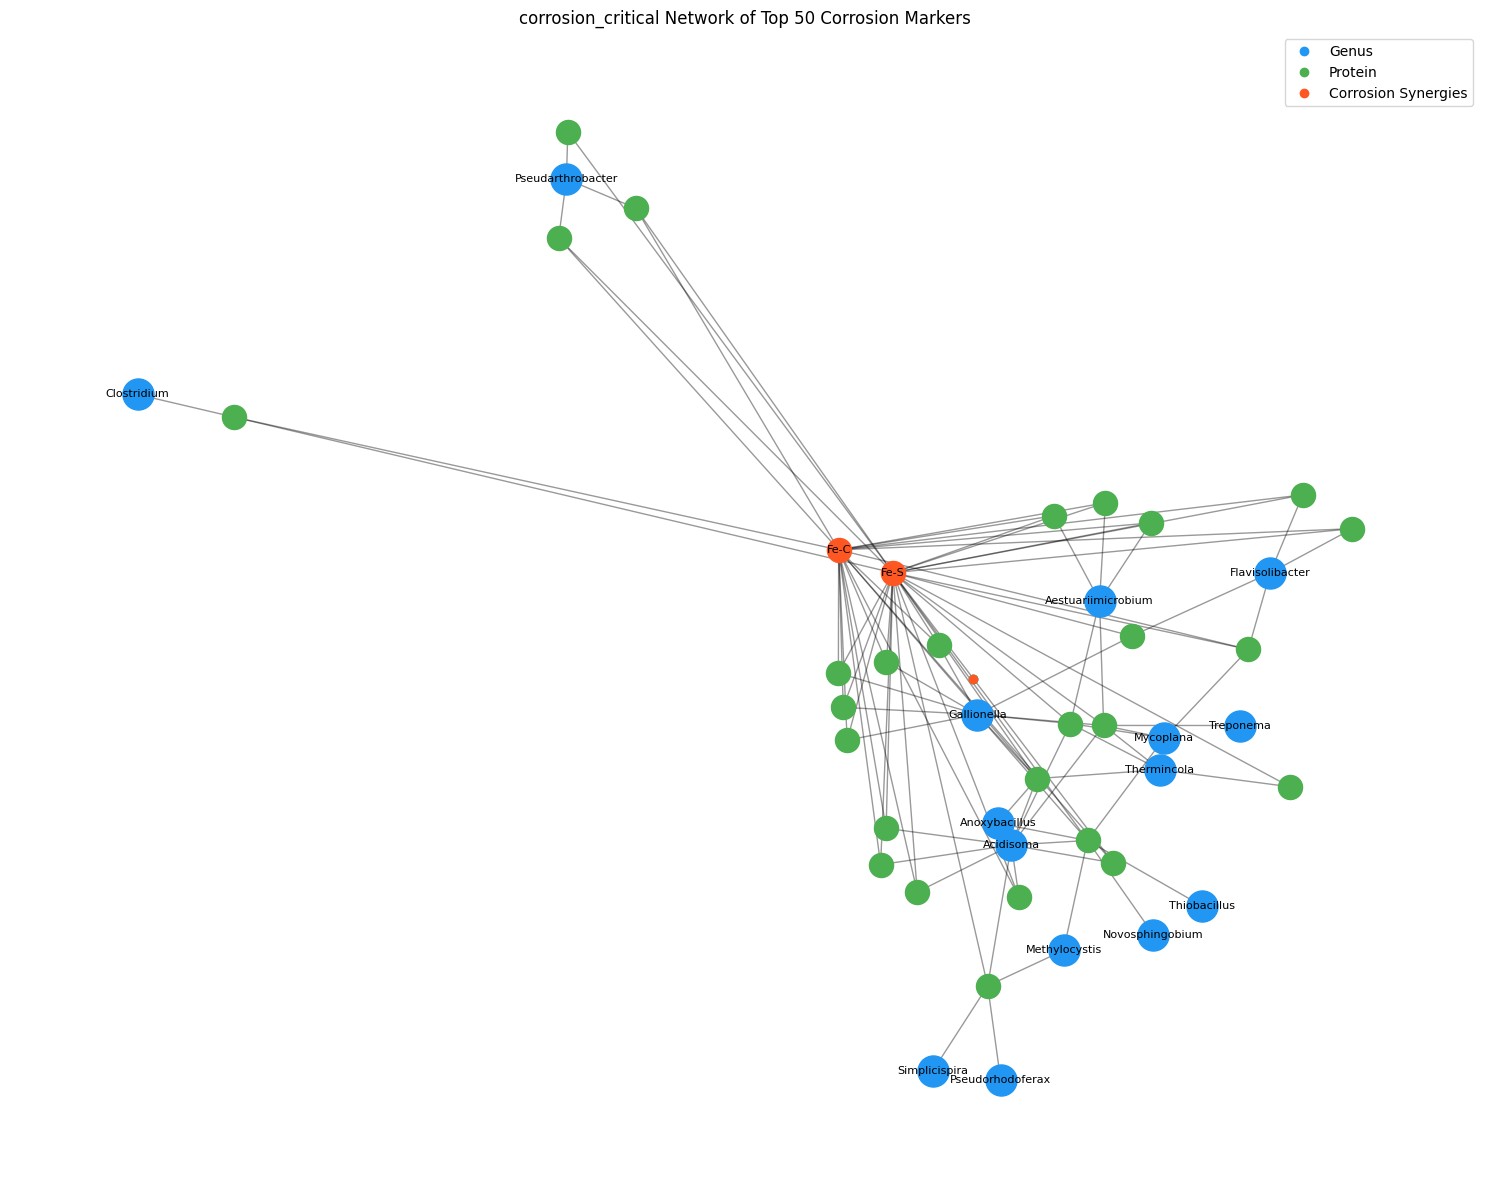

In [41]:
# Expand column width display
import pandas as pd
pd.set_option('display.max_colwidth', None)

create_static_network(corrosion_critical, "corrosion_critical", top_n=50, threshold=0.5, category_col='corrosion_synergies',  protein_label_legend=True)

# 5. Pathways
## 5.1 Pathway Enrichment across Risk Categories
Plot shows metabolic pathways present in the corrosion environment, how abundant each pathway is across different corrosion risk categories. The pathways increase/decrease with severity or specific conditions
Biological processes are identified, which be involved in corrosion mechanisms across different risk levels.The bubble chart visualization uses
Y-axis: Different metabolic pathways
X-axis: Risk categories (Normal Operation, Early Warning, System Failure)
Bubble size: Mean abundance of the pathway in that category
Bubble color: Pattern type (increasing, decreasing, or unique to a category)

In [42]:
def plot_pathway_enrichment(classified_results, name):
    """
    Creates a bubble chart showing pathway enrichment by risk category,
    accounting for unique patterns in specific categories.
    """
    # Extract top pathways from the dataset
    pathway_data = []

    for _, row in classified_results.iterrows():
        if isinstance(row['pathways'], str) and row['pathways']:
            pathways = [p.strip() for p in row['pathways'].split(';')]
            # Take only the first 3 pathways to avoid overwhelming the plot
            for pathway in pathways: # [:3]
                pathway_data.append({
                    'pathway': pathway,
                    'category': 'Category 1',
                    'mean_abundance': row['mean_cat1'],
                    'classification': row['pathway_classification']
                })
                pathway_data.append({
                    'pathway': pathway,
                    'category': 'Category 2',
                    'mean_abundance': row['mean_cat2'],
                    'classification': row['pathway_classification']
                })
                pathway_data.append({
                    'pathway': pathway,
                    'category': 'Category 3',
                    'mean_abundance': row['mean_cat3'],
                    'classification': row['pathway_classification']
                })

    # Convert to DataFrame
    pathway_df = pd.DataFrame(pathway_data)

    # Group by pathway and category, calculate mean abundance
    grouped = pathway_df.groupby(['pathway', 'category', 'classification'], as_index=False)['mean_abundance'].mean()

    # Add pattern detection: dominant category
    pivot = grouped.pivot_table(index='pathway', columns='category', values='mean_abundance').reset_index()

    # Identify dominant category for each pathway
    pivot['dominant_cat'] = pivot[['Category 1', 'Category 2', 'Category 3']].idxmax(axis=1)
    pivot['max_value'] = pivot[['Category 1', 'Category 2', 'Category 3']].max(axis=1)
    pivot['pattern'] = 'unique_' + pivot['dominant_cat'].str.replace('Category ', 'cat')

    # Calculate fold changes between categories with pseudocounts
    min_threshold = 0.01  # Higher minimum threshold to prevent extreme ratios

    # Cat3 vs Cat1 fold change
    pivot['fold_change_3vs1'] = (pivot['Category 3'] + min_threshold) / (pivot['Category 1'] + min_threshold)
    pivot['log2fc_3vs1'] = np.log2(pivot['fold_change_3vs1'])

    # Cat2 vs Cat1 fold change
    pivot['fold_change_2vs1'] = (pivot['Category 2'] + min_threshold) / (pivot['Category 1'] + min_threshold)
    pivot['log2fc_2vs1'] = np.log2(pivot['fold_change_2vs1'])

    # Cat3 vs Cat2 fold change
    pivot['fold_change_3vs2'] = (pivot['Category 3'] + min_threshold) / (pivot['Category 2'] + min_threshold)
    pivot['log2fc_3vs2'] = np.log2(pivot['fold_change_3vs2'])

    # Identify increasing or decreasing patterns
    # Pattern is "increasing" if Cat1 < Cat2 < Cat3
    pivot['is_increasing'] = (
        (pivot['Category 1'] < pivot['Category 2']) &
        (pivot['Category 2'] < pivot['Category 3'])
    )

    # Pattern is "decreasing" if Cat1 > Cat2 > Cat3
    pivot['is_decreasing'] = (
        (pivot['Category 1'] > pivot['Category 2']) &
        (pivot['Category 2'] > pivot['Category 3'])
    )

    # Update pattern label based on trend
    pivot.loc[pivot['is_increasing'], 'pattern'] = 'increasing'
    pivot.loc[pivot['is_decreasing'], 'pattern'] = 'decreasing'

    # Handle infinity and NaN values with more moderate caps
    for col in ['log2fc_3vs1', 'log2fc_2vs1', 'log2fc_3vs2']:
        pivot[col] = pivot[col].replace([np.inf, -np.inf], [5, -5])  # More moderate caps
        pivot[col] = pivot[col].fillna(0)
    # Merge back the pattern information
    enrichment = pd.merge(
        grouped,
        pivot[['pathway', 'fold_change_3vs1', 'log2fc_3vs1', 'pattern', 'dominant_cat']],
        on='pathway'
    )

    # Get top pathways for each pattern type
    pattern_types = pivot['pattern'].unique()
    top_pathways = []

    for pattern in pattern_types:
        # Get top 5 pathways for this pattern
        pattern_data = enrichment[enrichment['pattern'] == pattern].copy(deep=False)
        if len(pattern_data) > 0:
            if pattern == 'increasing':
                # For increasing, get highest fold change
                top = pattern_data.sort_values('log2fc_3vs1', ascending=False).head(5)
            elif pattern == 'decreasing':
                # For decreasing, get lowest fold change
                top = pattern_data.sort_values('log2fc_3vs1', ascending=True).head(5)
            else:
                # For unique patterns, get highest mean abundance
                top = pattern_data.sort_values('mean_abundance', ascending=False).head(5)
            top_pathways.append(top)

    # Combine all top pathways
    plot_data = pd.concat(top_pathways)

    plot_data = plot_data.dropna(subset=['mean_abundance'])

    # Create a bubble chart
    fig = px.scatter(
        plot_data,
        x='category',
        y='pathway',
        size='mean_abundance',
        size_max=15,
        color='pattern',
        hover_data=['classification', 'mean_abundance'],
        height=400,
        width=800,
        title=(f" Pathway Enrichment for {name} group across Risk Categories"),
        labels={
            'category': 'Risk Category',
            'pathway': 'Metabolic Pathway',
            'mean_abundance': 'Mean Abundance',
            'pattern': 'Abundance Pattern'
        },
        color_discrete_map={
            'increasing': '#4CAF50',  # Green
            'decreasing': '#F44336',  # Red
            'unique_cat1': '#2196F3',  # Blue
            'unique_cat2': '#FF9800',  # Orange
            'unique_cat3': '#9C27B0'   # Purple
        }, category_orders={"category": ["Category 1", "Category 2", "Category 3"]}
    )

    # Update layout for better readability
    fig.update_layout(
        yaxis={'categoryorder': 'total ascending'},
        legend_title_text='Abundance Pattern',
        xaxis_title='Risk Category',
        yaxis_title='Metabolic Pathway'
    )

    return fig, pivot

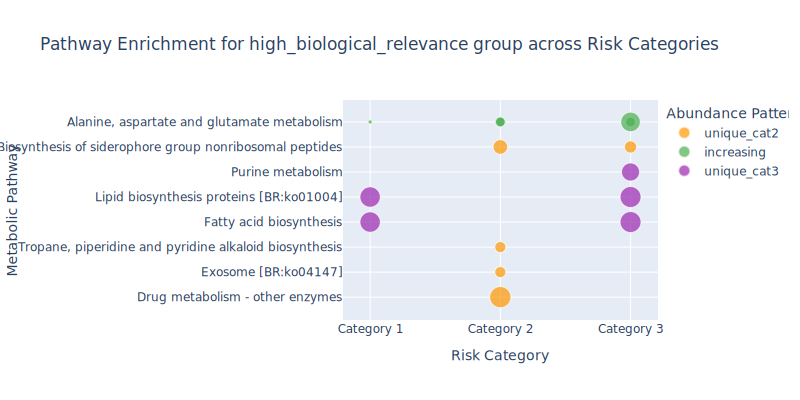

In [43]:
# calling the function
Pathway_enrichment, pathway_patterns = plot_pathway_enrichment(high_biological_relevance, "high_biological_relevance")
Pathway_enrichment.show(renderer="svg")

The group high confidence is the largest one of the selected after balanced markers, the category 3 patterns are marked by prokaryotic defense system which increased drastically from cat1 to cat3. The lipid biosyntesis, aminoacid and cyano amino acid metabolism, nitrotoluene degradation and other fixation pathways only are present on cat3 as well as the quorum sensing which corelates with biofilm stablishement on corroded environments. Markers for early warning cat2 are fatty acids, lipids metabolism, together with flavonoids degradataion which are a bridge to more deteriorated environments.

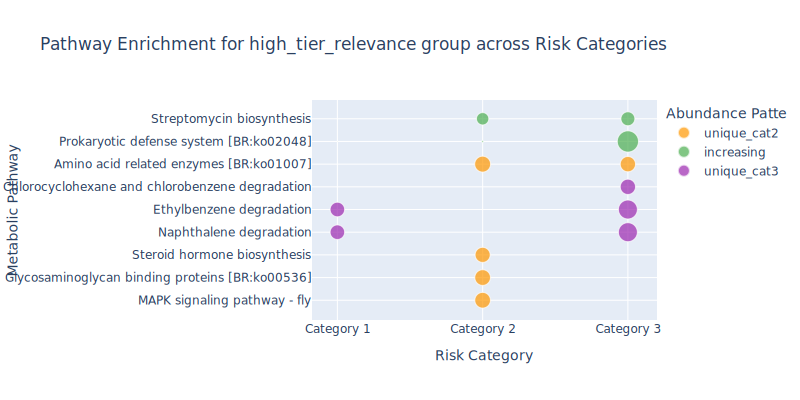

In [44]:
# calling the function
Pathway_enrichment, pathway_patterns = plot_pathway_enrichment(high_tier_relevance , "high_tier_relevance")
Pathway_enrichment.show(renderer="svg")

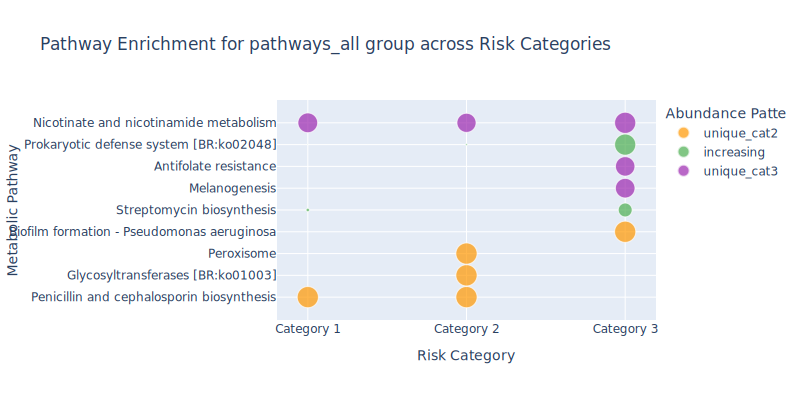

In [45]:
# calling the function
Pathway_enrichment, pathway_patterns = plot_pathway_enrichment(pathways_all , "pathways_all")
Pathway_enrichment.show(renderer="svg")

This is an exploratory visualisation tool for checking relationships between the final selected proteins

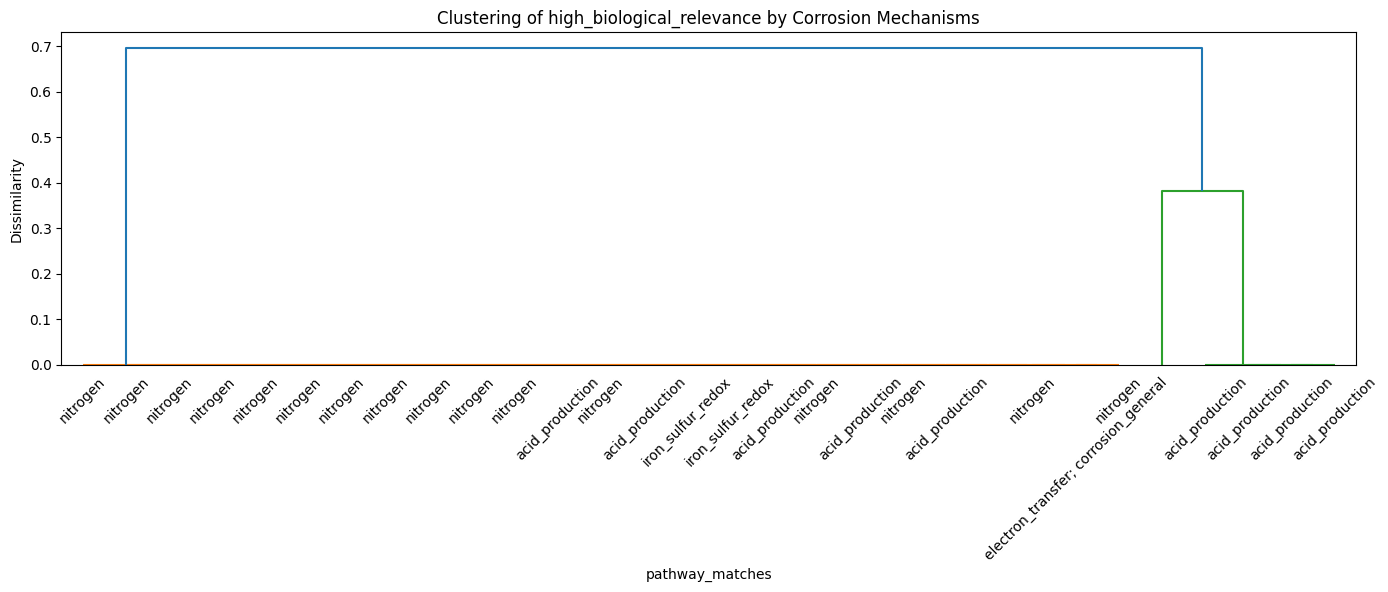

In [46]:
def clustering_markers_by_corrosion_mechanisms(top_markers, name, top_n = 20):
    # starting df
    top_markers = top_markers.copy(deep=False)  
    top_markers = top_markers.head(top_n)

    # Create a binary presence matrix from corrosion_mechanisms
    vectorizer = CountVectorizer(tokenizer=lambda x: x.split(';'), binary=True)
    mech_matrix = vectorizer.fit_transform(top_markers['corrosion_mechanisms'].fillna(''))

    # Compute cosine similarity (1 = identical mechanism sets, 0 = completely different)
    cos_sim = cosine_similarity(mech_matrix)

    # Hierarchical clustering
    from scipy.cluster.hierarchy import linkage, dendrogram
    linkage_matrix = linkage(1 - cos_sim, method='average')

    # Cluster (Agglomerative)
    from sklearn.cluster import AgglomerativeClustering
    clusters = AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage='average')
    top_markers['cluster'] = clusters.fit_predict(1 - cos_sim)


    # Plot dendrogram with Genus labels
    plt.figure(figsize=(14, 6))
    dendrogram(linkage_matrix, labels=top_markers['pathway_matches'].values, leaf_rotation=90, leaf_font_size=10)
    plt.title(f"Clustering of {name} by Corrosion Mechanisms")
    plt.xlabel("pathway_matches")
    plt.ylabel("Dissimilarity")
    plt.xticks(rotation=45)
    plt.tight_layout(pad=1)
    plt.show()

clustering_markers_by_corrosion_mechanisms(high_biological_relevance, "high_biological_relevance", top_n = 30)

The significant markers is a group filtered drastically and hence the proceses seen here are more specific. The metabolism of valina, leucine and isoleucine degradation increase with risk label. The Alanine, spartate and glutamate metabolim seems to be only on cat3, also cyanoamino acid mettabolism, nitrotoluen degradation lipid byosinstesis and other carbon pathways, which are only specific to category 3 system failure. On the early warning cat2 we found also specific process to that category such as exosome, other glycan degradation, sphingolipid degradation and metabolism, fructuosa and manosa as well as flavonoids degradation. The metabolites on the system failure are more toxic ones as the early warning, there are no category 1 metabolism because these are filtered markers and it is no expected aromatics are propose to be the most enriched pathways on this function, whith the motility andand oter carbon fixations pathways, which is interesting to see the penicilin being anotated there, it might be noticed that the anotations here visualised come from different databases anotaated on the EC numbers reported by the picrust alogrithm and are no direct measures. The cunction for enrichement has been done on two groups first

##  5.2. Hierarchical representation of pathways for a specific risk category.

In [47]:
def create_sunburst_chart(data_frame, name, top_n=None, category=3):
    """
    Create a sunburst chart with improved readability:Text labels inside wedges where space permits  - Proper legend  - Simplified popup information
    """
    sig_df = data_frame.sort_values(by='combined_score', ascending=False).head(top_n)
    
    # Prepare data for sunburst chart
    sunburst_data = []
    for _, row in sig_df.iterrows():
        # Extract hierarchy levels
        hierarchy = row['hierarchy']
        if not isinstance(hierarchy, str) or not hierarchy:
            hierarchy = "Unclassified"
            
        # Split hierarchy into levels but limit to 3 for clarity
        hierarchy_levels = hierarchy.split('/')
        display_levels = hierarchy_levels[:min(3, len(hierarchy_levels))]
        
        # Calculate abundance value
        abundance = row[f'mean_cat{category}']
        
        # Get dominant category
        cat_values = [row['mean_cat1'], row['mean_cat2'], row['mean_cat3']]
        dominant_cat = cat_values.index(max(cat_values)) + 1
        
        # Create simplified description for hover
        simple_description = "<br>".join([
            f"<b>Pathway</b>: {'/'.join(hierarchy_levels)}",
            f"<b>Genus</b>: {row['Genus']}",
            f"<b>Protein</b>: {row['protein_name']}"
        ])
        
        # Add the data point
        sunburst_data.append({
            'id': '/'.join(display_levels),
            'parent': '/'.join(display_levels[:-1]) if len(display_levels) > 1 else '',
            'labels': display_levels[-1] if len(display_levels[-1]) < 20 else display_levels[-1][:17] + '...',
            'values': abundance,
            'dominant_category': ['Normal Operation', 'Early Warning', 'System Failure'][dominant_cat-1],
            'simplified_info': simple_description
        })
        
        # Add parent paths
        for i in range(len(display_levels)-1, 0, -1):
            parent_path = '/'.join(display_levels[:i])
            path = '/'.join(display_levels[:i+1])
            
            if not any(d['id'] == path for d in sunburst_data):
                sunburst_data.append({
                    'id': path,
                    'parent': parent_path if i > 1 else '',
                    'labels': display_levels[i] if len(display_levels[i]) < 30 else display_levels[i][:17] + '...',
                    'values': abundance,
                    'dominant_category': ['Normal Operation', 'Early Warning', 'System Failure'][dominant_cat-1],
                    'simplified_info': f"<b>Pathway Group</b>: {'/'.join(display_levels[:i+1])}"
                })
                
        # Add root node if needed
        if len(display_levels) > 0 and not any(d['id'] == display_levels[0] for d in sunburst_data):
            sunburst_data.append({
                'id': display_levels[0],
                'parent': '',
                'labels': display_levels[0] if len(display_levels[0]) < 30 else display_levels[0][:17] + '...',
                'values': abundance,
                'dominant_category': ['Normal Operation', 'Early Warning', 'System Failure'][dominant_cat-1],
                'simplified_info': f"<b>Major Pathway</b>: {display_levels[0]}"
            })
            
    # Convert to DataFrame
    sunburst_df = pd.DataFrame(sunburst_data)
    
    # Category color mapping
    color_map = {
        'Normal Operation': '#008800',  # Green
        'Early Warning': '#FF8C00',     # Orange
        'System Failure': '#FF0000'     # Red
    }
    
    # Create the sunburst chart
    fig = px.sunburst(
        sunburst_df,
        ids='id',
        parents='parent',
        names='labels',
        values='values',
        color='dominant_category',
        color_discrete_map=color_map,
        title=f'Group {name} Hierarchical Pathway Distribution by Category {category}',
        custom_data=['simplified_info']
    )
    
    # Update hover template and enable text where it fits
    fig.update_traces(
        hovertemplate='%{customdata[0]}',
        textinfo='label',       # Show text labels where possible
        insidetextorientation='radial',  # Orient text radially
        branchvalues='total'   # Use total values for better proportional representation
    )
    
    # Add white separator lines between sectors
    fig.update_traces(
        marker=dict(
            line=dict(color='white', width=1.5)
        )
    )
    
    # Update layout for 600px width
    fig.update_layout(
        width=800,
        height=600,
        margin=dict(t=50, l=10, r=10, b=10),  # t=top, l=left, r=right, b=bottom
        legend_title="System Status",
        font=dict(size=12),  # Smaller base font size for 600px width
        hoverlabel=dict(
            font_size=12,  # Popup text size
            bgcolor="white"
        )
    )
    
    return fig

In [48]:
create_sunburst_chart(organic_metal_synergy, "organic_metal_synergy", top_n=20, category=3)

## 5.3. Heating and Cooling Systems Pathway Analysis
Creating independent analyses:

Failure analysis (based on human assessment/estimation)
Microbiological analysis (16S rRNA)
Physicochemical parameters

Using physicochemical parameters as labels/indicators of corrosion state, it gives us an objective measure without directly mixing in the biological data. Then planning to correlate the microbial communities with these states through machine learning

And now to use PICRUSt's functional predictions to validate our assumptions about organic matter metabolism. It can help confirm if the bacteria identified through correlations actually have the metabolic capacity to influence corrosion. It might reveal unexpected metabolic pathways that could explain the correlations. The following script will Validate our organic matter assumptions, objectives are to break down different types of organic matter processing. To look at both degradation and synthesis pathways and identify transport mechanisms

Connect with our physicochemical parameters by analyzing pathways that could influence:

pH modulation
Temperature response
Metal interactions

In [49]:
top_markers.columns

Index(['idx', 'Genus', 'protein_name', 'mean_cat1', 'mean_cat2', 'mean_cat3',
       'fold_change_2vs1', 'log2fc_2vs1', 'fold_change_3vs2', 'log2fc_3vs2',
       'fold_change_3vs1', 'log2fc_3vs1', 'specificity', 'prevalence',
       'max_abs_log2fc', 'Category', 'enzyme_class', 'pathways', 'hierarchy',
       'metals_consolidated', 'corrosion_relevance', 'functional_categories',
       'corrosion_keyword_groups', 'corrosion_synergies', 'organic_processes',
       'corrosion_mechanisms', 'version', 'pathway_classification',
       'universal_pathways', 'niche_specific_pathways', 'combined_score',
       'pathway_matches', 'hierarchy_matches', 'functional_categories_present',
       'explanation', 'norm_abund_contri'],
      dtype='object')

In [50]:
top_markers['pathway_matches']

0      electron_transfer; corrosion_general
1                                  nitrogen
2                           acid_production
3                           acid_production
4                                          
                       ...                 
157                                        
158                                nitrogen
159                                nitrogen
160                                nitrogen
161                                        
Name: pathway_matches, Length: 162, dtype: object

In [51]:
top_markers[[        'corrosion_mechanisms', 'version', 'pathway_classification',
       'universal_pathways', 'niche_specific_pathways', 'combined_score',
       'pathway_matches', 'hierarchy_matches', 'functional_categories_present',
       'explanation', 'norm_abund_contri']]

corrosion_mechanisms  \
0    direct_eet; indirect_eet; acid_production; h2_consumption; o2_consumption; biofilm_formation; sulfur_metabolism   
1    direct_eet; indirect_eet; acid_production; h2_consumption; o2_consumption; biofilm_formation; sulfur_metabolism   
2    direct_eet; indirect_eet; acid_production; h2_consumption; o2_consumption; biofilm_formation; sulfur_metabolism   
3    direct_eet; indirect_eet; acid_production; h2_consumption; o2_consumption; biofilm_formation; sulfur_metabolism   
4    direct_eet; indirect_eet; acid_production; h2_consumption; o2_consumption; biofilm_formation; sulfur_metabolism   
..                                                                                                               ...   
157                  direct_eet; indirect_eet; acid_production; h2_consumption; biofilm_formation; sulfur_metabolism   
158  direct_eet; indirect_eet; acid_production; h2_consumption; o2_consumption; biofilm_formation; sulfur_metabolism   
159  direct_eet; indirect_eet; acid_production; h2_consumption; o2_consumption; biofilm_formation; sulfur_metabolism   
160  direct_eet; indirect_eet; acid_production; h2_consumption; o2_consumption; biofilm_formation; sulfur_metabolism   
161  direct_eet; indirect_eet; acid_production; h2_consumption; o2_consumption; biofilm_formation; sulfur_metabolism   

                       version pathway_classification  universal_pathways  \
0    v9_proteins_pathways_fold         niche-specific                       
1    v9_proteins_pathways_fold              universal  General Metabolism   
2    v9_proteins_pathways_fold         niche-specific                       
3    v9_proteins_pathways_fold         niche-specific                       
4    v9_proteins_pathways_fold              universal  General Metabolism   
..                         ...                    ...                 ...   
157  v9_proteins_pathways_fold                  mixed  General Metabolism   
158  v9_proteins_pathways_fold              universal  General Metabolism   
159  v9_proteins_pathways_fold              universal  General Metabolism   
160  v9_proteins_pathways_fold              universal  General Metabolism   
161  v9_proteins_pathways_fold              universal  General Metabolism   

                                                                                                                                                                                                                                     niche_specific_pathways  \
0    Glutathione metabolism; Metabolism of xenobiotics by cytochrome P450; Drug metabolism - cytochrome P450; Drug metabolism - other enzymes; Transporters [BR:ko02000]; Chemical carcinogenesis - DNA adducts; Antimicrobial resistance genes [BR:ko01504]   
1                                                                                                                                                                                                                                  nitrogen , nitrogen cycle   
2                              fatty acid degradation; toluene degradation; benzoate degradation; fluorobenzoate degradation; chloroalkane and chloroalkene degradation; xylene degradation; dioxin degradation; polycyclic aromatic hydrocarbon degradation   
3                              fatty acid degradation; toluene degradation; benzoate degradation; fluorobenzoate degradation; chloroalkane and chloroalkene degradation; xylene degradation; dioxin degradation; polycyclic aromatic hydrocarbon degradation   
4                                                                                                                                                                                                                                                  butanoate   
..                                                                                                                                                                                                

## 5.4 Organic Metal Pathways

The previously imported pathway_categories from a file named global_terms in the corrosion_scoring directory, which contains  relevant categories, is now used in this implementation. The risk labels are only used here for color coding purposes. The overall idea is to have a primary axis y1= protein-genus pair that is contained on organic_acid vs x= abundance /fold change and secundary axis y2= protein-genus pair that is contained on iron_sulfur_redox vs abundance/fold_change 
The primary objective of this visualization is to enable a comparative analysis of protein-genus pairs associated with specific metabolic or functional pathways, as defined by curated pathway categories. The pathway categories are organized in a dictionary (for example, pathway_categories in the global_terms module), where each category contains a list of relevant pathway terms.

For each selected pathway category, the set of protein-genus pairs is determined by searching the pathways column of the dataset for the presence of any terms corresponding to the category. This approach ensures that only those protein-genus pairs functionally linked to the chosen pathway are included in the comparison.

The visualization adopts a mirrored plot format, where each side (left and right) represents a distinct pathway category. The y-axis on each side lists the protein-genus pairs relevant to that category, while the x-axis displays a quantitative metric such as abundance or fold change. Items that are present in both categories are highlighted to facilitate direct comparison.

Color coding is applied based on risk or functional categories (e.g., Normal Operation, Early Warning, System Failure), providing additional context regarding the biological or operational significance of each protein-genus pair. The overall design allows for an intuitive, side-by-side evaluation of how different functional groups are distributed and behave according to the selected metric.

In [55]:
# Import global terms
try:
    sys.path.append('/kaggle/input/corrosion-scoring')
    from global_terms import pathway_categories
    print("Successfully imported pathway_categories from Kaggle path")
except ImportError:
    try:
        sys.path.append('/home/beatriz/MIC/2_Micro/corrosion_scoring')
        from corrosion_scoring.global_terms import pathway_categories
        print("Successfully imported pathway_categories from local path")
    except ImportError as e:
        raise ImportError(f"Error: Could not import pathway_categories: {e}")
    from corrosion_scoring import scoring_system

# Select the relevant categories
relevant_categories = ['organic_acid_metabolism', 'metal_organic_interaction',
                    'iron_sulfur_redox', 'ocre_formation', 'carbon_metabolism',
                    'biofilm_formation', 'methanogenesis', 'halogen_related']

# Define the category colors as in original code
category_colors = {
        1: '#008800',  # Dark green - Normal Operation
        2: '#FF8C00',  # Dark orange - Early Warning
        3: '#FF0000'   # Red - System Failure
    }
    
categories_labels = {
        1: 'Normal Operation',
        2: 'Early Warning',
        3: 'System Failure'
    }

Successfully imported pathway_categories from Kaggle path


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display, HTML

# Define the category colors as in original code
category_colors = {
    1: '#008800',  # Dark green - Normal Operation
    2: '#FF8C00',  # Dark orange - Early Warning
    3: '#FF0000'   # Red - System Failure
}

categories_labels = {
    1: 'Normal Operation',
    2: 'Early Warning',
    3: 'System Failure'
}

# ----------------- VISUALIZATION FUNCTIONS -----------------

def create_protein_distribution_heatmap(df, top_n=30, min_categories=2):
    """
    Creates a heatmap showing which proteins appear in multiple pathway categories
    
    Args:
        df: DataFrame with protein-genus data
        top_n: Number of top proteins to display
        min_categories: Minimum number of categories a protein must be in to be displayed
    """
    # Create a mapping of protein to its pathway categories
    protein_categories = {}
    protein_genera = {}
    protein_highest_category = {}
    
    for idx, row in df.iterrows():
        protein = row['protein_name']
        genus = row['Genus']
        protein_genus = f"{genus} - {protein}"
        
        # Get the pathway categories for this protein
        categories = row.get('pathway_categories', '').split(',')
        categories = [c.strip() for c in categories if c.strip()]
        
        if protein_genus not in protein_categories:
            protein_categories[protein_genus] = set()
            protein_genera[protein_genus] = genus
            protein_highest_category[protein_genus] = 0
            
        # Add the categories
        protein_categories[protein_genus].update(categories)
        
        # Update the highest category
        category = row.get('Category', 0)
        if category > protein_highest_category[protein_genus]:
            protein_highest_category[protein_genus] = category
    
    # Convert to a list of tuples (protein_genus, num_categories, highest_category)
    protein_data = [(pg, len(cats), protein_highest_category[pg]) 
                   for pg, cats in protein_categories.items() if len(cats) >= min_categories]
    
    # Sort by number of categories (descending) and then by highest category (descending)
    protein_data.sort(key=lambda x: (x[1], x[2]), reverse=True)
    
    # Take top N proteins
    protein_data = protein_data[:top_n]
    
    # Create a matrix for the heatmap
    all_categories = sorted(list(set().union(*[protein_categories[pg] for pg, _, _ in protein_data])))
    
    # Create a DataFrame for the heatmap
    heatmap_data = []
    for pg, _, category in protein_data:
        row_data = {'protein_genus': pg, 'num_categories': len(protein_categories[pg]), 'category': category}
        for cat in all_categories:
            row_data[cat] = 1 if cat in protein_categories[pg] else 0
        heatmap_data.append(row_data)
    
    heatmap_df = pd.DataFrame(heatmap_data)
    
    # Create the heatmap
    fig = go.Figure()
    
    # Add the heatmap for categories
    for i, cat in enumerate(all_categories):
        fig.add_trace(go.Heatmap(
            z=heatmap_df[cat],
            x=[cat],
            y=heatmap_df['protein_genus'],
            colorscale=[[0, 'white'], [1, 'darkblue']],
            showscale=False,
            hovertemplate='%{y} is in category %{x}<extra></extra>'
        ))
    
    # Add colored markers for the protein category
    for i, row in heatmap_df.iterrows():
        cat = row['category']
        fig.add_trace(go.Scatter(
            x=[all_categories[-1]],  # Put it at the end
            y=[row['protein_genus']],
            mode='markers',
            marker=dict(
                color=category_colors.get(cat, 'gray'),
                size=10,
                symbol='square',
                line=dict(width=1, color='black')
            ),
            hovertemplate=f'Category: {categories_labels.get(cat, "Unknown")}<extra></extra>',
            showlegend=False
        ))
    
    # Add a trace for the number of categories
    
    # Create the num_categories column explicitly if it doesn't exist
    if 'num_categories' not in heatmap_df.columns:
        # The function should be creating this column earlier in the code
        # Add a print statement to debug
        print("Available columns:", heatmap_df.columns)
        # Create a default or fallback value
        sizes = np.ones(len(heatmap_df)) * 10  # Use a constant size instead
    else:
        sizes = heatmap_df['num_categories'] / heatmap_df['num_categories'].max() * 20


    fig.add_trace(go.Scatter(
        x=['# Categories'],
        y=heatmap_df['protein_genus'],
        mode='markers',
        marker=dict(
            color='black',
            size=sizes,
            symbol='circle',
            line=dict(width=0)
        ),
        text=heatmap_df['num_categories'],
        hovertemplate='%{y} is in %{text} categories<extra></extra>',
        showlegend=False
    ))
    
    # Update layout
    fig.update_layout(
        title=f'Top {len(protein_data)} Proteins by Number of Pathway Categories',
        xaxis=dict(
            title='Pathway Categories',
            tickangle=45
        ),
        yaxis=dict(
            title='Protein-Genus Pairs',
            autorange='reversed'  # To have the highest values at the top
        ),
        height=max(600, len(protein_data) * 20),
        width=900,
        margin=dict(l=250, r=50, t=100, b=100)
    )
    
    return fig

def create_protein_network_plot(df, selected_category=None, min_count=2):
    """
    Creates a network visualization showing proteins shared between genera
    
    Args:
        df: DataFrame with protein-genus data
        selected_category: Optional filter for pathway category
        min_count: Minimum number of genera a protein must appear in
    """
    # Filter by category if specified
    if selected_category:
        df = df[df['pathway_categories'].str.contains(selected_category, na=False)]
    
    # Create protein to genus mapping
    protein_to_genus = {}
    genus_to_category = {}
    
    for idx, row in df.iterrows():
        protein = row['protein_name']
        genus = row['Genus']
        category = row.get('Category', 1)
        
        if protein not in protein_to_genus:
            protein_to_genus[protein] = []
        
        if genus not in protein_to_genus[protein]:
            protein_to_genus[protein].append(genus)
        
        # Store the highest category for each genus
        if genus not in genus_to_category or category > genus_to_category[genus]:
            genus_to_category[genus] = category
    
    # Filter proteins that appear in at least min_count genera
    shared_proteins = {p: g for p, g in protein_to_genus.items() if len(g) >= min_count}
    
    # If no proteins meet the criteria, return a message
    if not shared_proteins:
        fig = go.Figure()
        fig.add_annotation(
            text="No proteins found that match the criteria",
            xref="paper", yref="paper",
            x=0.5, y=0.5, showarrow=False
        )
        return fig
    
    # Create nodes and edges for the network
    nodes = []
    edges = []
    
    # Add protein nodes
    for protein in shared_proteins:
        nodes.append({
            'id': protein,
            'label': protein,
            'type': 'protein',
            'size': len(shared_proteins[protein]) * 5,  # Size based on number of genera
            'genera_count': len(shared_proteins[protein])
        })
    
    # Add genus nodes and edges
    all_genera = set()
    for protein, genera in shared_proteins.items():
        for genus in genera:
            if genus not in all_genera:
                all_genera.add(genus)
                category = genus_to_category.get(genus, 1)
                nodes.append({
                    'id': genus,
                    'label': genus,
                    'type': 'genus',
                    'category': category
                })
            
            edges.append({
                'from': protein,
                'to': genus
            })
    
    # Use a force-directed layout to position nodes
    # This is a simple implementation - a more complex one would use a dedicated library
    pos = {}
    
    # Position proteins in a circle
    protein_nodes = [n for n in nodes if n['type'] == 'protein']
    genus_nodes = [n for n in nodes if n['type'] == 'genus']
    
    # Position protein nodes in an inner circle
    for i, node in enumerate(protein_nodes):
        angle = 2 * np.pi * i / len(protein_nodes)
        radius = 0.4
        pos[node['id']] = (radius * np.cos(angle), radius * np.sin(angle))
    
    # Position genus nodes in an outer circle
    for i, node in enumerate(genus_nodes):
        angle = 2 * np.pi * i / len(genus_nodes)
        radius = 0.8
        pos[node['id']] = (radius * np.cos(angle), radius * np.sin(angle))
    
    # Create the figure
    fig = go.Figure()
    
    # Add edges as lines
    for edge in edges:
        x0, y0 = pos[edge['from']]
        x1, y1 = pos[edge['to']]
        
        fig.add_trace(go.Scatter(
            x=[x0, x1],
            y=[y0, y1],
            mode='lines',
            line=dict(width=0.5, color='gray'),
            hoverinfo='none',
            showlegend=False
        ))
    
    # Add protein nodes
    for node in protein_nodes:
        x, y = pos[node['id']]
        
        fig.add_trace(go.Scatter(
            x=[x],
            y=[y],
            mode='markers+text',
            marker=dict(
                size=node['size'],
                color='skyblue',
                line=dict(width=1, color='black')
            ),
            text=node['label'],
            textposition="top center",
            name=f"{node['label']} (in {node['genera_count']} genera)",
            hovertemplate=f"{node['label']}<br>Found in {node['genera_count']} genera<extra></extra>"
        ))
    
    # Add genus nodes, colored by category
    for node in genus_nodes:
        x, y = pos[node['id']]
        category = node['category']
        
        fig.add_trace(go.Scatter(
            x=[x],
            y=[y],
            mode='markers+text',
            marker=dict(
                size=15,
                color=category_colors.get(category, 'gray'),
                symbol='diamond',
                line=dict(width=1, color='black')
            ),
            text=node['label'],
            textposition="bottom center",
            name=f"{node['label']} ({categories_labels.get(category, 'Unknown')})",
            hovertemplate=f"{node['label']}<br>Category: {categories_labels.get(category, 'Unknown')}<extra></extra>"
        ))
    
    # Update layout
    title = "Protein-Genus Network"
    if selected_category:
        title += f" for {selected_category.replace('_', ' ').title()}"
    
    fig.update_layout(
        title=title,
        showlegend=True,
        hovermode='closest',
        xaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False
        ),
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False
        ),
        height=700,
        width=900,
        legend=dict(
            itemsizing='constant',
            orientation='v',
            x=1.05,
            y=0.5
        )
    )
    
    return fig

def create_category_overlap_matrix(df):
    """
    Creates a matrix showing the overlap between different pathway categories
    """
    # Extract all unique pathway categories
    all_categories = []
    
    for idx, row in df.iterrows():
        categories = str(row.get('pathway_categories', '')).split(',')
        categories = [c.strip() for c in categories if c.strip()]
        all_categories.extend(categories)
    
    all_categories = sorted(list(set(all_categories)))
    
    # Create a matrix to store overlaps
    overlap_matrix = np.zeros((len(all_categories), len(all_categories)))
    
    # For each protein-genus pair, update the matrix
    for idx, row in df.iterrows():
        protein_genus = f"{row['Genus']} - {row['protein_name']}"
        categories = str(row.get('pathway_categories', '')).split(',')
        categories = [c.strip() for c in categories if c.strip()]
        
        # Update the matrix for each pair of categories
        for i, cat1 in enumerate(categories):
            if cat1 not in all_categories:
                continue
                
            idx1 = all_categories.index(cat1)
            
            # Self-overlap
            overlap_matrix[idx1, idx1] += 1
            
            # Cross-overlap
            for j, cat2 in enumerate(categories[i+1:], i+1):
                if cat2 not in all_categories:
                    continue
                    
                idx2 = all_categories.index(cat2)
                overlap_matrix[idx1, idx2] += 1
                overlap_matrix[idx2, idx1] += 1
    
    # Create the heatmap
    fig = go.Figure(data=go.Heatmap(
        z=overlap_matrix,
        x=all_categories,
        y=all_categories,
        colorscale='Viridis',
        text=overlap_matrix.astype(int),
        texttemplate="%{text}",
        hovertemplate='%{y} and %{x} share %{z:.0f} protein-genus pairs<extra></extra>'
    ))
    
    # Update layout
    fig.update_layout(
        title='Pathway Category Overlap Matrix',
        xaxis=dict(
            title='Pathway Categories',
            tickangle=45
        ),
        yaxis=dict(
            title='Pathway Categories'
        ),
        height=700,
        width=900
    )
    
    return fig

def plot_category_comparison_advanced(df, pathway_cat1, pathway_cat2, abundance_metric='log2fc_3vs1',
                                    max_items=20, highlight_shared=True, plot_height=800, plot_width=1200):
    """
    Create an improved mirror plot comparing pathway categories with better highlighting of shared items.
    """
    # Create a single figure with two subplots side by side
    fig = make_subplots(rows=1, cols=2, 
                       subplot_titles=[pathway_cat1.replace('_', ' ').title(), 
                                      pathway_cat2.replace('_', ' ').title()],
                       horizontal_spacing=0.1)
    
    # Identify items in each pathway category
    items_cat1 = {}
    items_cat2 = {}
    all_proteins = set()
    
    for idx, row in df.iterrows():
        protein = row['protein_name']
        genus = row['Genus']
        item_id = f"{genus} - {protein}"
        all_proteins.add(protein)
        
        # Check pathway categories
        categories = str(row.get('pathway_categories', '')).split(',')
        categories = [c.strip() for c in categories if c.strip()]
        
        if pathway_cat1 in categories:
            items_cat1[item_id] = row
        
        if pathway_cat2 in categories:
            items_cat2[item_id] = row
    
    # Find items that are shared
    shared_items = set(items_cat1.keys()).intersection(set(items_cat2.keys()))
    
    # Find proteins that appear in both but in different genera
    proteins_in_both = {}
    for item_id in list(items_cat1.keys()) + list(items_cat2.keys()):
        if ' - ' in item_id:
            genus, protein = item_id.split(' - ', 1)
            if protein not in proteins_in_both:
                proteins_in_both[protein] = {'cat1': set(), 'cat2': set()}
            
            if item_id in items_cat1:
                proteins_in_both[protein]['cat1'].add(genus)
            
            if item_id in items_cat2:
                proteins_in_both[protein]['cat2'].add(genus)
    
    # Identify proteins in both categories but in different genera
    proteins_across_categories = {p: data for p, data in proteins_in_both.items() 
                                if data['cat1'] and data['cat2'] and len(data['cat1'].union(data['cat2'])) > 1}
    
    # Sort and limit items
    def sort_items(items_dict):
        return sorted(
            items_dict.items(),
            key=lambda x: (-x[1].get('Category', 1), -abs(x[1].get(abundance_metric, 0)))
        )[:max_items]
    
    sorted_items_cat1 = sort_items(items_cat1)
    sorted_items_cat2 = sort_items(items_cat2)
    
    # Plot left side
    for item_id, row in sorted_items_cat1:
        category = row.get('Category', 1)
        color = category_colors.get(category, 'gray')
        
        is_shared = item_id in shared_items
        
        # Check if protein is in both categories but different genera
        is_cross_category = False
        protein = item_id.split(' - ', 1)[1] if ' - ' in item_id else item_id
        if protein in proteins_across_categories and not is_shared:
            is_cross_category = True
        
        marker_size = 15 if category == 3 else 12 if is_shared or is_cross_category else 10
        marker_symbol = 'star' if category == 3 else 'circle'
        marker_line = dict(width=2, color='black') if is_shared else \
                     dict(width=1.5, color='purple') if is_cross_category else \
                     dict(width=1, color='white')
        
        x_val = row.get(abundance_metric, 0)
        
        fig.add_trace(
            go.Scatter(
                x=[x_val],
                y=[item_id],
                mode='markers',
                marker=dict(
                    color=color,
                    size=marker_size,
                    symbol=marker_symbol,
                    line=marker_line
                ),
                hovertemplate=(
                    f"{item_id}<br>"
                    f"Category: {categories_labels.get(category, 'Unknown')}<br>"
                    f"{abundance_metric}: {x_val:.2f}"
                    f"{'<br>Present in both categories' if is_shared else ''}"
                    f"{'<br>Protein in both categories across genera' if is_cross_category else ''}"
                    f"<extra></extra>"
                ),
                showlegend=False
            ),
            row=1, col=1
        )
    
    # Plot right side
    for item_id, row in sorted_items_cat2:
        category = row.get('Category', 1)
        color = category_colors.get(category, 'gray')
        
        is_shared = item_id in shared_items
        
        # Check if protein is in both categories but different genera
        is_cross_category = False
        protein = item_id.split(' - ', 1)[1] if ' - ' in item_id else item_id
        if protein in proteins_across_categories and not is_shared:
            is_cross_category = True
        
        marker_size = 15 if category == 3 else 12 if is_shared or is_cross_category else 10
        marker_symbol = 'star' if category == 3 else 'circle'
        marker_line = dict(width=2, color='black') if is_shared else \
                     dict(width=1.5, color='purple') if is_cross_category else \
                     dict(width=1, color='white')
        
        x_val = row.get(abundance_metric, 0)
        
        fig.add_trace(
            go.Scatter(
                x=[x_val],
                y=[item_id],
                mode='markers',
                marker=dict(
                    color=color,
                    size=marker_size,
                    symbol=marker_symbol,
                    line=marker_line
                ),
                hovertemplate=(
                    f"{item_id}<br>"
                    f"Category: {categories_labels.get(category, 'Unknown')}<br>"
                    f"{abundance_metric}: {x_val:.2f}"
                    f"{'<br>Present in both categories' if is_shared else ''}"
                    f"{'<br>Protein in both categories across genera' if is_cross_category else ''}"
                    f"<extra></extra>"
                ),
                showlegend=False
            ),
            row=1, col=2
        )
    
    # Add legend for the categories
    for cat, label in categories_labels.items():
        symbol = 'star' if cat == 3 else 'circle'
        size = 15 if cat == 3 else 10
        
        fig.add_trace(
            go.Scatter(
                x=[None],
                y=[None],
                mode='markers',
                marker=dict(
                    color=category_colors.get(cat, 'gray'),
                    size=size,
                    symbol=symbol
                ),
                name=label,
                showlegend=True
            ),
            row=1, col=1
        )
    
    # Add legend for shared items
    fig.add_trace(
        go.Scatter(
            x=[None],
            y=[None],
            mode='markers',
            marker=dict(
                color='gray',
                size=12,
                symbol='circle',
                line=dict(width=2, color='black')
            ),
            name="Same genus-protein in both categories",
            showlegend=True
        ),
        row=1, col=1
    )
    
    # Add legend for cross-category proteins
    fig.add_trace(
        go.Scatter(
            x=[None],
            y=[None],
            mode='markers',
            marker=dict(
                color='gray',
                size=12,
                symbol='circle',
                line=dict(width=1.5, color='purple')
            ),
            name="Same protein in both categories (different genera)",
            showlegend=True
        ),
        row=1, col=1
    )
    
    # Calculate appropriate x-axis range
    all_x_vals = []
    for item_dict in [items_cat1, items_cat2]:
        for row in item_dict.values():
            all_x_vals.append(row.get(abundance_metric, 0))
    
    if all_x_vals:
        x_min = min(all_x_vals)
        x_max = max(all_x_vals)
        x_padding = (x_max - x_min) * 0.1
        x_range = [x_min - x_padding, x_max + x_padding]
    else:
        x_range = [-1, 1]
    
    # Update layout
    fig.update_layout(
        title=f"Comparison of {pathway_cat1.replace('_', ' ').title()} vs {pathway_cat2.replace('_', ' ').title()}",
        height=plot_height,
        width=plot_width,
        margin=dict(l=200, r=50, t=100, b=50),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    
    # Update axes
    fig.update_xaxes(title_text=abundance_metric, range=x_range, row=1, col=1)
    fig.update_xaxes(title_text=abundance_metric, range=x_range, row=1, col=2)
    
    # Add a note about the number of items
    fig.add_annotation(
        text=f"{len(items_cat1)} items total ({len(shared_items)} shared)",
        xref="x domain",
        yref="paper",
        x=0.5,
        y=-0.15,
        showarrow=False,
        row=1, col=1
    )
    
    fig.add_annotation(
        text=f"{len(items_cat2)} items total ({len(shared_items)} shared)",
        xref="x2 domain",
        yref="paper",
        x=0.5,
        y=-0.15,
        showarrow=False,
        row=1, col=2
    )
    
    return fig

# ----------------- MAIN DASHBOARD UI -----------------

def create_dashboard(df, relevant_categories):
    """
    Creates a dashboard with multiple visualization options for exploring protein-genus relationships
    """
    # Create tab structure
    tab_titles = ['Category Comparison', 'Protein Distribution', 'Network View', 'Category Overlap']
    tab_contents = [widgets.VBox([]) for _ in range(len(tab_titles))]
    tabs = widgets.Tab(children=tab_contents)
    for i, title in enumerate(tab_titles):
        tabs.set_title(i, title)
    
    # --------------- TAB 1: CATEGORY COMPARISON ---------------
    
    # Create the widgets for category comparison
    cat1_dropdown = widgets.Dropdown(
        options=relevant_categories,
        value=relevant_categories[0],
        description='Left Category:',
        style={'description_width': 'initial'}
    )
    
    cat2_dropdown = widgets.Dropdown(
        options=relevant_categories,
        value=relevant_categories[1] if len(relevant_categories) > 1 else relevant_categories[0],
        description='Right Category:',
        style={'description_width': 'initial'}
    )
    
    abundance_dropdown = widgets.Dropdown(
        options=[
            ('Mean Cat 1', 'mean_cat1'), 
            ('Mean Cat 2', 'mean_cat2'), 
            ('Mean Cat 3', 'mean_cat3'),
            ('Fold Change 2vs1', 'fold_change_2vs1'), 
            ('Log2 FC 2vs1', 'log2fc_2vs1'),
            ('Fold Change 3vs2', 'fold_change_3vs2'), 
            ('Log2 FC 3vs2', 'log2fc_3vs2'),
            ('Fold Change 3vs1', 'fold_change_3vs1'), 
            ('Log2 FC 3vs1', 'log2fc_3vs1')
        ],
        value='log2fc_3vs1',
        description='Metric:',
        style={'description_width': 'initial'}
    )
    
    max_items_slider = widgets.IntSlider(
        value=20,
        min=5,
        max=50,
        step=5,
        description='Max items:',
        style={'description_width': 'initial'}
    )
    
    plot_height_slider = widgets.IntSlider(
        value=800,
        min=400,
        max=1500,
        step=100,
        description='Height:',
        style={'description_width': 'initial'}
    )
    
    plot_width_slider = widgets.IntSlider(
        value=1200,
        min=800,
        max=1800,
        step=100,
        description='Width:',
        style={'description_width': 'initial'}
    )
    
    highlight_shared_checkbox = widgets.Checkbox(
        value=True,
        description='Highlight shared items',
        style={'description_width': 'initial'}
    )
    
    # Output for category comparison tab
    output_comparison = widgets.Output()
    
    # Function to update the category comparison plot
    def update_comparison_plot(change):
        output_comparison.clear_output(wait=True)
        with output_comparison:
            fig = plot_category_comparison_advanced(
                df,
                cat1_dropdown.value,
                cat2_dropdown.value,
                abundance_dropdown.value,
                max_items_slider.value,
                highlight_shared_checkbox.value,
                plot_height_slider.value,
                plot_width_slider.value
            )
            fig.show()
    
    # Register callbacks
    cat1_dropdown.observe(update_comparison_plot, names='value')
    cat2_dropdown.observe(update_comparison_plot, names='value')
    abundance_dropdown.observe(update_comparison_plot, names='value')
    max_items_slider.observe(update_comparison_plot, names='value')
    plot_height_slider.observe(update_comparison_plot, names='value')
    plot_width_slider.observe(update_comparison_plot, names='value')
    highlight_shared_checkbox.observe(update_comparison_plot, names='value')
    
    # Update button for explicit refresh
    update_comparison_button = widgets.Button(
        description='Update Plot',
        button_style='primary',
        tooltip='Click to refresh the plot',
        icon='refresh'
    )
    update_comparison_button.on_click(lambda b: update_comparison_plot(None))
    
    # Organize widgets for category comparison tab
    category_controls = widgets.HBox([cat1_dropdown, cat2_dropdown, abundance_dropdown])
    display_controls = widgets.HBox([max_items_slider, plot_height_slider, plot_width_slider])
    option_controls = widgets.HBox([highlight_shared_checkbox, update_comparison_button])
    
    # Assemble tab content
    tab_contents[0] = widgets.VBox([
        widgets.HTML("<h3>Pathway Category Comparison</h3>"),
        widgets.HTML("<p>Compare proteins across two pathway categories to identify shared elements.</p>"),
        category_controls,
        display_controls,
        option_controls,
        output_comparison
    ])
    tabs.children = tab_contents
    
    # Initial plot for comparison tab
    update_comparison_plot(None)
    
    # --------------- TAB 2: PROTEIN DISTRIBUTION ---------------
    
    # Create widgets for protein distribution
    top_n_slider = widgets.IntSlider(
        value=30,
        min=10,
        max=100,
        step=5,
        description='Top proteins:',
        style={'description_width': 'initial'}
    )
    
    min_categories_slider = widgets.IntSlider(
        value=2,
        min=1,
        max=8,
        step=1,
        description='Min categories:',
        style={'description_width': 'initial'}
    )
    
    # Output for protein distribution tab
    output_distribution = widgets.Output()
    
    # Function to update the protein distribution plot
    def update_distribution_plot(change):
        output_distribution.clear_output(wait=True)
        with output_distribution:
            fig = create_protein_distribution_heatmap(
                df,
                top_n=top_n_slider.value,
                min_categories=min_categories_slider.value
            )
            fig.show()
    
    # Register callbacks
    top_n_slider.observe(update_distribution_plot, names='value')
    min_categories_slider.observe(update_distribution_plot, names='value')
    
    # Update button for explicit refresh
    update_distribution_button = widgets.Button(
        description='Update Plot',
        button_style='primary',
        tooltip='Click to refresh the plot',
        icon='refresh'
    )
    update_distribution_button.on_click(lambda b: update_distribution_plot(None))
    
    # Organize widgets for protein distribution tab
    distribution_controls = widgets.HBox([top_n_slider, min_categories_slider, update_distribution_button])
    
    # Assemble tab content
    tab_contents[0] = widgets.VBox([
        widgets.HTML("<h3>Protein Distribution Across Pathway Categories</h3>"),
        widgets.HTML("<p>Visualize which proteins appear in multiple pathway categories.</p>"),
        distribution_controls,
        output_distribution
    ])
    tabs.children = tab_contents

    # Initial plot for distribution tab
    update_distribution_plot(None)
    
    # --------------- TAB 3: NETWORK VIEW ---------------
    
    # Create widgets for network view
    network_category_dropdown = widgets.Dropdown(
        options=[('All Categories', None)] + [(cat, cat) for cat in relevant_categories],
        value=None,
        description='Filter by category:',
        style={'description_width': 'initial'}
    )
    
    min_genera_slider = widgets.IntSlider(
        value=2,
        min=1,
        max=10,
        step=1,
        description='Min genera:',
        style={'description_width': 'initial'}
    )
    
    # Output for network view tab
    output_network = widgets.Output()
    
    # Function to update the network view
    def update_network_plot(change):
        output_network.clear_output(wait=True)
        with output_network:
            fig = create_protein_network_plot(
                df,
                selected_category=network_category_dropdown.value,
                min_count=min_genera_slider.value
            )
            fig.show()
    
    # Register callbacks
    network_category_dropdown.observe(update_network_plot, names='value')
    min_genera_slider.observe(update_network_plot, names='value')
    
    # Update button for explicit refresh
    update_network_button = widgets.Button(
        description='Update Plot',
        button_style='primary',
        tooltip='Click to refresh the plot',
        icon='refresh'
    )
    update_network_button.on_click(lambda b: update_network_plot(None))
    
    # Organize widgets for network view tab
    network_controls = widgets.HBox([network_category_dropdown, min_genera_slider, update_network_button])
    
    # Assemble tab content
    tab_contents[0] = widgets.VBox([
        widgets.HTML("<h3>Protein-Genus Network</h3>"),
        widgets.HTML("<p>Explore network connections between proteins and genera.</p>"),
        network_controls,
        output_network
    ])
    tabs.children = tab_contents

    # Initial plot for network tab
    update_network_plot(None)
    
    # --------------- TAB 4: CATEGORY OVERLAP ---------------
    
    # Output for category overlap tab
    output_overlap = widgets.Output()
    
    # Function to update the category overlap matrix
    def update_overlap_matrix(change=None):
        output_overlap.clear_output(wait=True)
        with output_overlap:
            fig = create_category_overlap_matrix(df)
            fig.show()
    
    # Update button for explicit refresh
    update_overlap_button = widgets.Button(
        description='Update Matrix',
        button_style='primary',
        tooltip='Click to refresh the matrix',
        icon='refresh'
    )
    update_overlap_button.on_click(update_overlap_matrix)
    
    # Assemble tab content
    tab_contents[0] = widgets.VBox([
        widgets.HTML("<h3>Pathway Category Overlap Matrix</h3>"),
        widgets.HTML("<p>View how different pathway categories share protein-genus pairs.</p>"),
        update_overlap_button,
        output_overlap
    ])
    tabs.children = tab_contents

    
    # Initial plot for overlap tab
    update_overlap_matrix()
    
    # Display the dashboard
    display(tabs)
    
    return tabs

# ----------------- UTILITY FUNCTIONS -----------------

def analyze_protein_genus_distribution(df):
    """
    Analyzes and summarizes the distribution of proteins across genera and pathway categories
    """
    # Count proteins per genus
    genus_counts = df['Genus'].value_counts()
    
    # Count proteins per pathway category
    category_counts = {}
    for idx, row in df.iterrows():
        categories = str(row.get('pathway_categories', '')).split(',')
        categories = [c.strip() for c in categories if c.strip()]
        
        for category in categories:
            if category not in category_counts:
                category_counts[category] = 0
            category_counts[category] += 1
    
    # Find proteins that appear in multiple genera
    protein_to_genera = {}
    for idx, row in df.iterrows():
        protein = row['protein_name']
        genus = row['Genus']
        
        if protein not in protein_to_genera:
            protein_to_genera[protein] = set()
        
        protein_to_genera[protein].add(genus)
    
    # Sort proteins by number of genera they appear in
    multi_genus_proteins = {
        protein: genera 
        for protein, genera in protein_to_genera.items() 
        if len(genera) > 1
    }
    
    sorted_multi_genus = sorted(
        multi_genus_proteins.items(),
        key=lambda x: len(x[1]),
        reverse=True
    )
    
    # Find proteins that appear in multiple pathway categories
    protein_to_categories = {}
    for idx, row in df.iterrows():
        protein = row['protein_name']
        categories = str(row.get('pathway_categories', '')).split(',')
        categories = [c.strip() for c in categories if c.strip()]
        
        if protein not in protein_to_categories:
            protein_to_categories[protein] = set()
        
        protein_to_categories[protein].update(categories)
    
    # Sort proteins by number of categories they appear in
    multi_category_proteins = {
        protein: categories 
        for protein, categories in protein_to_categories.items() 
        if len(categories) > 1
    }
    
    sorted_multi_category = sorted(
        multi_category_proteins.items(),
        key=lambda x: len(x[1]),
        reverse=True
    )
    
    # Create summary dataframes
    genus_summary = pd.DataFrame({
        'Genus': genus_counts.index,
        'Protein Count': genus_counts.values
    })
    
    category_summary = pd.DataFrame({
        'Category': list(category_counts.keys()),
        'Protein Count': list(category_counts.values())
    }).sort_values('Protein Count', ascending=False)
    
    multi_genus_summary = pd.DataFrame([
        {'Protein': protein, 'Genera Count': len(genera), 'Genera': ', '.join(sorted(genera))}
        for protein, genera in sorted_multi_genus[:20]  # Show top 20
    ])
    
    multi_category_summary = pd.DataFrame([
        {'Protein': protein, 'Category Count': len(categories), 'Categories': ', '.join(sorted(categories))}
        for protein, categories in sorted_multi_category[:20]  # Show top 20
    ])
    
    return {
        'genus_summary': genus_summary,
        'category_summary': category_summary,
        'multi_genus_summary': multi_genus_summary,
        'multi_category_summary': multi_category_summary
    }

def export_visualizations(df, relevant_categories, output_dir='protein_visualizations'):
    """
    Exports all visualizations to static HTML files for sharing
    """
    import os
    from IPython.display import HTML, display
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Create index.html
    index_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Protein-Genus Visualization Dashboard</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; }}
            h1 {{ color: #333366; }}
            h2 {{ color: #666699; margin-top: 30px; }}
            ul {{ list-style-type: none; padding-left: 0; }}
            li {{ margin: 10px 0; }}
            a {{ color: #3366cc; text-decoration: none; }}
            a:hover {{ text-decoration: underline; }}
        </style>
    </head>
    <body>
        <h1>Protein-Genus Visualization Dashboard</h1>
        
        <h2>Pathway Category Comparisons</h2>
        <ul>
    """
    
    # Generate category comparison plots
    metric = 'log2fc_3vs1'  # Default metric
    max_items = 20
    
    for i, cat1 in enumerate(relevant_categories):
        for j, cat2 in enumerate(relevant_categories[i+1:], i+1):
            filename = f"comparison_{cat1}_vs_{cat2}.html"
            filepath = os.path.join(output_dir, filename)
            
            fig = plot_category_comparison_advanced(
                df, cat1, cat2, metric, max_items, True, 800, 1200
            )
            fig.write_html(filepath)
            
            index_content += f'            <li><a href="{filename}" target="_blank">{cat1.replace("_", " ").title()} vs {cat2.replace("_", " ").title()}</a></li>\n'
    
    # Add protein distribution heatmap
    index_content += """
        </ul>
        
        <h2>Protein Distribution</h2>
        <ul>
    """
    
    filename = "protein_distribution.html"
    filepath = os.path.join(output_dir, filename)
    fig = create_protein_distribution_heatmap(df, top_n=30, min_categories=2)
    fig.write_html(filepath)
    index_content += f'            <li><a href="{filename}" target="_blank">Protein Distribution Across Categories</a></li>\n'
    
    # Add network visualizations
    index_content += """
        </ul>
        
        <h2>Network Visualizations</h2>
        <ul>
    """
    
    # Overall network
    filename = "network_all.html"
    filepath = os.path.join(output_dir, filename)
    fig = create_protein_network_plot(df, selected_category=None, min_count=2)
    fig.write_html(filepath)
    index_content += f'            <li><a href="{filename}" target="_blank">All Categories Network</a></li>\n'
    
    # Individual category networks
    for cat in relevant_categories:
        filename = f"network_{cat}.html"
        filepath = os.path.join(output_dir, filename)
        fig = create_protein_network_plot(df, selected_category=cat, min_count=2)
        fig.write_html(filepath)
        index_content += f'            <li><a href="{filename}" target="_blank">{cat.replace("_", " ").title()} Network</a></li>\n'
    
    # Add category overlap matrix
    index_content += """
        </ul>
        
        <h2>Category Overlap Matrix</h2>
        <ul>
    """
    
    filename = "category_overlap.html"
    filepath = os.path.join(output_dir, filename)
    fig = create_category_overlap_matrix(df)
    fig.write_html(filepath)
    index_content += f'            <li><a href="{filename}" target="_blank">Pathway Category Overlap Matrix</a></li>\n'
    
    # Close HTML
    index_content += """
        </ul>
    </body>
    </html>
    """
    
    # Write index.html
    with open(os.path.join(output_dir, 'index.html'), 'w') as f:
        f.write(index_content)
    
    return HTML(f'<p>Visualizations exported to <code>{output_dir}</code> directory.</p>')

# ----------------- EXAMPLE USAGE -----------------

# To use the dashboard with your data:
dashboard = create_dashboard(df, relevant_categories)

# To export static visualizations:
export_visualizations(df, relevant_categories, 'protein_visualizations')

Available columns: RangeIndex(start=0, stop=0, step=1)


KeyError: 'protein_genus'

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def filter_df_by_pathway_category(df, pathway_terms):
    """Filter df rows where any pathway_terms appear in the 'pathways' column."""

    relevant_categories = ['organic_acid_metabolism', 'metal_organic_interaction',
                       'iron_sulfur_redox', 'ocre_formation', 'carbon_metabolism',
                       'biofilm_formation', 'methanogenesis', 'halogen_related']

    df = high_corrosion_relevance

    # Define selected categories and abundance metric
    cat1 = 'iron_sulfur_redox'
    cat2 = 'organic_acid_metabolism'
    abundance_metric = 'log2fc_1vs3'


    pathway_terms_lower = [term.lower() for term in pathway_terms]
    def row_matches(row):
        pathways_str = str(row['pathways']).lower()
        return any(term in pathways_str for term in pathway_terms_lower)
    return df[df.apply(row_matches, axis=1)].copy()

def plot_category_comparison_mirror(
    df, pathway_cat1, pathway_cat2, abundance_metric='log2fc_3vs1', 
    pathway_categories=None, category_colors=None, max_items=20
):
    # Filter for each category
    df_cat1 = filter_df_by_pathway_category(df, pathway_categories[pathway_cat1])
    df_cat2 = filter_df_by_pathway_category(df, pathway_categories[pathway_cat2])
    
    # Add unique ID
    df_cat1['item_id'] = df_cat1['Genus'] + ' - ' + df_cat1['protein_name']
    df_cat2['item_id'] = df_cat2['Genus'] + ' - ' + df_cat2['protein_name']
    
    # Optionally: sort and limit to top N items by absolute abundance
    df_cat1 = df_cat1.sort_values(by=abundance_metric, key=lambda x: abs(x), ascending=False).head(max_items)
    df_cat2 = df_cat2.sort_values(by=abundance_metric, key=lambda x: abs(x), ascending=False).head(max_items)
    
    # Find common items
    common_items = set(df_cat1['item_id']).intersection(set(df_cat2['item_id']))
    
    # For label readability, truncate long names
    def truncate(label, n=30):
        return (label[:n] + '...') if len(label) > n else label
    
    # Prepare y-axis arrays
    y_cat1 = [truncate(item) for item in df_cat1['item_id']]
    y_cat2 = [truncate(item) for item in df_cat2['item_id']]
    
    fig = make_subplots(
        rows=1, cols=2, 
        subplot_titles=[pathway_cat1.replace('_', ' ').title(), pathway_cat2.replace('_', ' ').title()],
        shared_yaxes=False
    )
    
    # Plot left (cat1)
    for i, row in df_cat1.iterrows():
        color = category_colors.get(row['Category'], '#888888')
        marker_line = dict(width=2, color='black') if row['item_id'] in common_items else dict(width=1, color='white')
        marker_symbol = 'star' if row['Category'] == 3 else 'circle'
        marker_size = 15 if row['Category'] == 3 else 10
        fig.add_trace(
            go.Scatter(
                x=[row[abundance_metric]],
                y=[truncate(row['item_id'])],
                mode='markers',
                marker=dict(color=color, size=marker_size, symbol=marker_symbol, line=marker_line),
                hovertext=f"{row['item_id']}<br>Category: {row['Category']}<br>{abundance_metric}: {row[abundance_metric]}",
                showlegend=False
            ),
            row=1, col=1
        )
    
    # Plot right (cat2)
    for i, row in df_cat2.iterrows():
        color = category_colors.get(row['Category'], '#888888')
        marker_line = dict(width=2, color='black') if row['item_id'] in common_items else dict(width=1, color='white')
        marker_symbol = 'star' if row['Category'] == 3 else 'circle'
        marker_size = 15 if row['Category'] == 3 else 10
        fig.add_trace(
            go.Scatter(
                x=[row[abundance_metric]],
                y=[truncate(row['item_id'])],
                mode='markers',
                marker=dict(color=color, size=marker_size, symbol=marker_symbol, line=marker_line),
                hovertext=f"{row['item_id']}<br>Category: {row['Category']}<br>{abundance_metric}: {row[abundance_metric]}",
                showlegend=False
            ),
            row=1, col=2
        )
    
    # Custom legend
    for cat, color in category_colors.items():
        symbol = 'star' if cat == 3 else 'circle'
        size = 15 if cat == 3 else 10
        fig.add_trace(
            go.Scatter(
                x=[None], y=[None], mode='markers',
                marker=dict(color=color, size=size, symbol=symbol),
                name=f"Category {cat}",
                showlegend=True
            ),
            row=1, col=1
        )
    # Legend for common items
    fig.add_trace(
        go.Scatter(
            x=[None], y=[None], mode='markers',
            marker=dict(color='gray', size=10, line=dict(width=2, color='black')),
            name="Present in both categories",
            showlegend=True
        ),
        row=1, col=1
    )
    
    # Layout
    fig.update_layout(
        title=f"Comparison of {pathway_cat1.replace('_',' ').title()} vs {pathway_cat2.replace('_',' ').title()} - {abundance_metric}",
        height=800,
        width=1200,
        yaxis=dict(
            categoryorder='array',
            categoryarray=y_cat1,
            automargin=True,
            tickfont=dict(size=10)
        ),
        yaxis2=dict(
            categoryorder='array',
            categoryarray=y_cat2,
            automargin=True,
            tickfont=dict(size=10)
        ),
        xaxis=dict(autorange=True),
        xaxis2=dict(autorange=True)
    )
    return fig

plot_category_comparison_mirror(high_synergy_markers, pathway_cat1, pathway_cat2, abundance_metric='log2fc_3vs1',  pathway_categories=None, 
                                category_colors=None, max_items=20)

In [ ]:
print(type(pathway_categories))
print(pathway_categories if isinstance(pathway_categories, list) else list(pathway_categories.items())[:3])


<class 'dict'>
[('hydrogen_metabolism', ['h2_consumption', 'hydrogenase', 'hydrogen uptake', 'hydrogen consumption', 'h2', 'H2 oxidation', 'H2ase', 'hydrogen production', 'FeFe-hydrogenase', 'NiFe-hydrogenase', 'hydrogen evolution', 'hydrogen cycling', 'H2 sensing', 'proton reduction']), ('oxygen_metabolism', ['o2_consumption', 'aerobic_respiration', 'oxygen reduction', 'oxygen consumption', 'cytochrome oxidase', 'terminal oxidase', 'oxygen reductase', 'superoxide dismutase', 'catalase', 'oxidative stress', 'oxygen sensor', 'oxygen tolerance']), ('nitrogen_metabolism', ['denitrification', 'nitrate_reduction', 'nitrite_reduction', 'nitrogen metabolism', 'nitrate', 'nitrite', 'ammonia oxidation', 'nitrification', 'nitrogen fixation', 'ammonification', 'nitrous oxide reduction', 'nitric oxide reduction', 'dissimilatory nitrate reduction', 'nitrite reductase', 'nitrate reductase'])]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_mirrored_pathway_comparison(df, pathway_categories, cat1='organic_acid_metabolism', cat2='iron_sulfur_redox'):
    # Build lookup for categories
    category_terms = {d['category']: d['terms'] for d in pathway_categories}
    
    def match_pathways(row, terms):
        return any(term.lower() in str(row['pathways']).lower() for term in terms)

    # Filter rows
    df_cat1 = df[df.apply(lambda row: match_pathways(row, category_terms.get(cat1, [])), axis=1)].copy()
    df_cat2 = df[df.apply(lambda row: match_pathways(row, category_terms.get(cat2, [])), axis=1)].copy()
    
    # Format y labels
    df_cat1['label'] = df_cat1['Genus'] + ' - ' + df_cat1['protein_name']
    df_cat2['label'] = df_cat2['Genus'] + ' - ' + df_cat2['protein_name']
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, max(len(df_cat1), len(df_cat2))*0.3))
    
    # Left
    ax1.barh(df_cat1['label'], df_cat1['log2fc_2vs1'], color=df_cat1['Category'].map({1: '#008800', 2: '#FF8C00', 3: '#FF0000'}))
    ax1.set_title(cat1.replace('_', ' ').title())
    ax1.set_xlabel('log2 Fold Change (2 vs 1)')
    ax1.invert_xaxis()
    
    # Right
    ax2.barh(df_cat2['label'], df_cat2['log2fc_3vs2'], color=df_cat2['Category'].map({1: '#008800', 2: '#FF8C00', 3: '#FF0000'}))
    ax2.set_title(cat2.replace('_', ' ').title())
    ax2.set_xlabel('log2 Fold Change (3 vs 2)')
    ax2.set_yticks([])

    # Layout
    plt.tight_layout()
    plt.show()


plot_mirrored_pathway_comparison(high_biological_relevance, pathway_categories, cat1='organic_acid_metabolism', cat2='iron_sulfur_redox')

TypeError: string indices must be integers

In [ ]:
high_corrosion_relevance.columns

Index(['idx', 'Genus', 'protein_name', 'mean_cat1', 'mean_cat2', 'mean_cat3',
       'fold_change_2vs1', 'log2fc_2vs1', 'fold_change_3vs2', 'log2fc_3vs2',
       'fold_change_3vs1', 'log2fc_3vs1', 'specificity', 'prevalence',
       'max_abs_log2fc', 'Category', 'enzyme_class', 'pathways', 'hierarchy',
       'metals_consolidated', 'corrosion_relevance', 'functional_categories',
       'corrosion_keyword_groups', 'corrosion_synergies', 'organic_processes',
       'corrosion_mechanisms', 'version', 'pathway_classification',
       'universal_pathways', 'niche_specific_pathways', 'combined_score',
       'pathway_matches', 'hierarchy_matches', 'functional_categories_present',
       'explanation', 'norm_abund_contri', 'label'],
      dtype='object')

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

'''relevant_categories = ['organic_acid_metabolism', 'metal_organic_interaction',
 'iron_sulfur_redox', 'ocre_formation', 'carbon_metabolism',
 'biofilm_formation', 'methanogenesis', 'halogen_related']'''

df = high_corrosion_relevance

# Define selected categories and abundance metric
pathway_category1 = 'iron_sulfur_redox'
pathway_category2 = 'organic_acid_metabolism'
abundance_metric = 'log2fc_3vs1'

# Build lookup for categories
category_terms = {k: v for k, v in pathway_categories.items()}

# Define matching function
def match_pathways(row, terms):
    return any(term.lower() in str(row['pathways']).lower() for term in terms)

# Create boolean masks for each category
df['has_cat1'] = df.apply(lambda row: match_pathways(row, category_terms.get(pathway_category1, [])), axis=1)
df['has_cat2'] = df.apply(lambda row: match_pathways(row, category_terms.get(pathway_category2, [])), axis=1)

# Create a scatter plot
fig = go.Figure()

# Add points for each category combination
for has_cat1 in [True, False]:
    for has_cat2 in [True, False]:
        # Filter data for this combination
        subset = df[(df['has_cat1'] == has_cat1) & (df['has_cat2'] == has_cat2)]
        
        if subset.empty:
            continue
            
        # Determine color based on category
        if has_cat1 and has_cat2:
            color = 'purple'
            name = f'Both {pathway_category1} and {pathway_category2}'
        elif has_cat1:
            color = 'blue'
            name = f'Only {pathway_category1}'
        elif has_cat2:
            color = 'green'
            name = f'Only {pathway_category2}'
        else:
            color = 'gray'
            name = 'Neither category'
            
        # Add some jitter to prevent overlap
        x_pos = 0.7 if has_cat1 else 0.3
        y_pos = 0.7 if has_cat2 else 0.3
        x_jitter = np.random.normal(0, 0.05, len(subset))
        y_jitter = np.random.normal(0, 0.05, len(subset))
        
        # Calculate marker size based on abundance metric
        size = subset[abundance_metric].fillna(0)
        size = 20 + (size - size.min()) / (size.max() - size.min()) * 80 if len(size) > 1 and size.max() != size.min() else 50
        
        # Add to plot
        fig.add_trace(go.Scatter(
            x=x_pos + x_jitter,
            y=y_pos + y_jitter,
            text=subset['Genus'] + ': ' + subset['protein_name'],
            mode='markers',
            marker=dict(
                size=size,
                color=color,
                opacity=0.7,
                line=dict(width=1, color='white')
            ),
            name=name,
            hoverinfo='text'
        ))

# Configure layout
fig.update_layout(
    title=f"Protein-Genus Distribution by {pathway_category1} and {pathway_category2}",
    xaxis=dict(
        title=pathway_category1,
        range=[0, 1],
        showticklabels=False
    ),
    yaxis=dict(
        title=pathway_category2,
        range=[0, 1],
        showticklabels=False
    ),
    legend=dict(
        title=f"Category (size = {abundance_metric})"
    ),
    height=700,
    width=800
)

fig.show()

## 5.5. Corrosion Relevant Pathways
Focus on corrosion-relevant pathways by categorizing them into:

Organic acid metabolism (relevant to our acetate/oxalate observations)
Sulfur metabolism
Metal interactions
Biofilm formation


Handle the high-dimensional data by:

Using dimensionality reduction (PCA)
Calculating summary statistics
Visualizing key patterns


Address our specific interests:

Organic matter metabolism pathways
Metal-organic interactions
Correlations with physicochemical parameters

In [ ]:
high_biological_relevance.columns

Index(['idx', 'Genus', 'protein_name', 'mean_cat1', 'mean_cat2', 'mean_cat3',
       'fold_change_2vs1', 'log2fc_2vs1', 'fold_change_3vs2', 'log2fc_3vs2',
       'fold_change_3vs1', 'log2fc_3vs1', 'specificity', 'prevalence',
       'max_abs_log2fc', 'Category', 'enzyme_class', 'pathways', 'hierarchy',
       'metals_consolidated', 'corrosion_relevance', 'functional_categories',
       'corrosion_keyword_groups', 'corrosion_synergies', 'organic_processes',
       'corrosion_mechanisms', 'version', 'pathway_classification',
       'universal_pathways', 'niche_specific_pathways', 'combined_score',
       'pathway_matches', 'hierarchy_matches', 'functional_categories_present',
       'explanation', 'norm_abund_contri'],
      dtype='object')

In [ ]:
def plot_pathway_analysis(pathway_stats, pathway_data, df_name="marker_df", num_items=25):
    """
    Create visualizations for pathway analysis - optimized version with only the most informative plots
    
    Parameters:
        pathway_stats: Dictionary of statistics for each pathway category
        pathway_data: Dictionary of DataFrames for each pathway category
        df_name: Name of the original DataFrame (for labeling purposes)
        num_items: Number of items to show in plots (default: 25)
    """
    if not pathway_stats:
        print("No data available for plotting")
        return
    
    for category, stats in pathway_stats.items():
        if len(stats) > 0:
            # Modify the category title display (e.g., "metal_organic_interaction" to "Metal Organic Interaction")
            category_title = category.replace("_", " ").title()
            
            # Get top N entries based on num_items parameter
            top_data = stats.head(num_items).copy()
            
            # Create proper labels with genus and protein name - no truncation
            top_data['label'] = top_data.apply(lambda x: f"{x['Genus']} - {x['protein_name']}", axis=1)
            
            # ====== PLOT 1: Fold Change and Mean Abundance ======
            fig, ax1 = plt.subplots(figsize=(10, min(9, max(5, len(top_data)*0.2))))
            ax2 = ax1.twinx()
            
            # Plot fold change
            bars = ax1.barh(range(len(top_data)), top_data['fold_change_3vs1'], color='skyblue')
            
            # Plot mean abundance on secondary axis
            line = ax2.plot(top_data['mean_cat3'], range(len(top_data)), 
                          marker='o', color='red', linestyle='--')
            
            # Set labels and titles
            ax1.set_yticks(range(len(top_data)))
            ax1.set_yticklabels(top_data['label'])
            ax1.set_title(f'{df_name}: {category_title} Pathways (Plot 1)', fontsize=12)
            ax1.set_xlabel('Fold Change (Cat3/Cat1)', fontsize=10)
            ax1.set_ylabel('Protein', fontsize=10)
            ax2.set_xlabel('Mean Abundance in Cat3', fontsize=10)
            
            # Add a legend
            from matplotlib.lines import Line2D
            legend_elements = [
                Line2D([0], [0], color='skyblue', lw=4, label='Fold Change (Cat3/Cat1)'),
                Line2D([0], [0], marker='o', color='red', label='Mean Abundance Cat3', 
                      markersize=6, linestyle='--')
            ]
            ax1.legend(handles=legend_elements, loc='lower right')
            
            plt.tight_layout()
            plt.show()
            
            # ====== PLOT 4: Enhanced Category Comparison ======
            # This plot combines more data in a single visualization
            fig, ax = plt.subplots(figsize=(10, 7))
            
            # Create indices for plotting
            indices = np.arange(len(top_data))
            
            # Calculate width based on number of items
            bar_width = min(0.8 / len(top_data), 0.15)
            
            # Sort data by fold change for better visualization
            sorted_data = top_data.sort_values('fold_change_3vs1', ascending=False)
            
            # Plot each category with specified colors
            bars1 = ax.bar(indices - bar_width, sorted_data['mean_cat1'], width=bar_width,
                          color=category_colors[1], label=categories_labels[1])
            bars2 = ax.bar(indices, sorted_data['mean_cat2'], width=bar_width,
                          color=category_colors[2], label=categories_labels[2])
            bars3 = ax.bar(indices + bar_width, sorted_data['mean_cat3'], width=bar_width,
                          color=category_colors[3], label=categories_labels[3])
            
            # Create a second y-axis for fold change
            ax2 = ax.twinx()
            line = ax2.plot(indices, sorted_data['fold_change_3vs1'], 'ko-', linewidth=2,
                           marker='D', markersize=6, label='Fold Change (Cat3/Cat1)')
            
            # Set labels and titles
            ax.set_xlabel('Proteins', fontsize=12)
            ax.set_ylabel('Mean Abundance', fontsize=12)
            ax2.set_ylabel('Fold Change (Cat3/Cat1)', fontsize=12)
            
            plt.title(f'{df_name}: {category_title} - Abundance & Fold Change (Plot 4)', fontsize=14)
            
            # Set x-ticks with protein labels
            ax.set_xticks(indices)
            ax.set_xticklabels(sorted_data['label'], rotation=45, ha='right', fontsize=8)
            
            # Create a single legend for both axes
            lines1, labels1 = ax.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10)
            
            plt.tight_layout()
            plt.show()
        else:
            print(f"No data to plot for category: {category}")

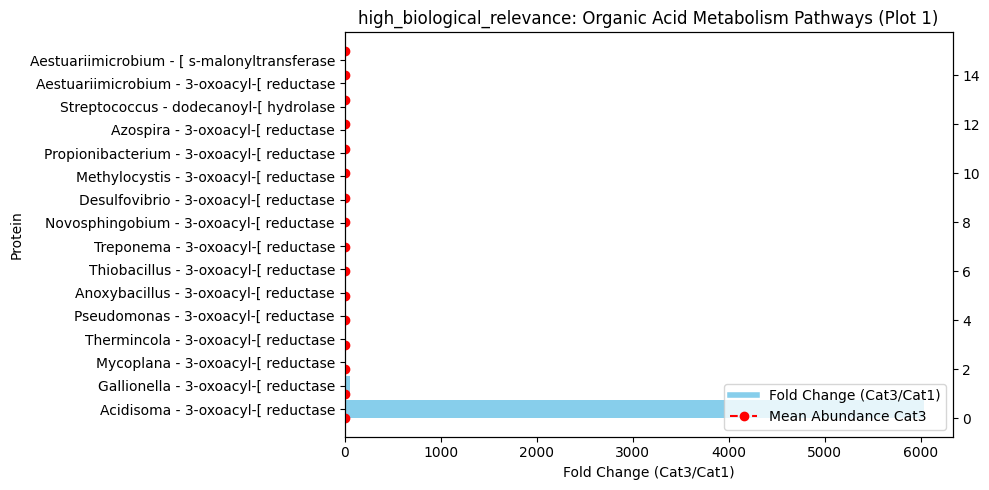

/tmp/ipykernel_22042/4000784589.py:80: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko-" (-> marker='o'). The keyword argument will take precedence.



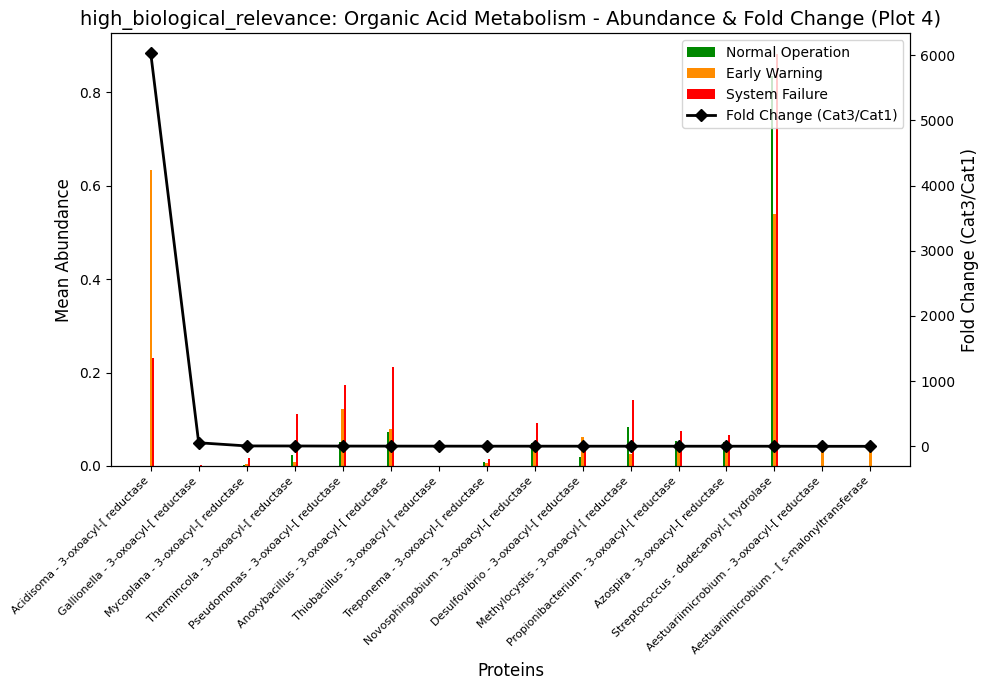

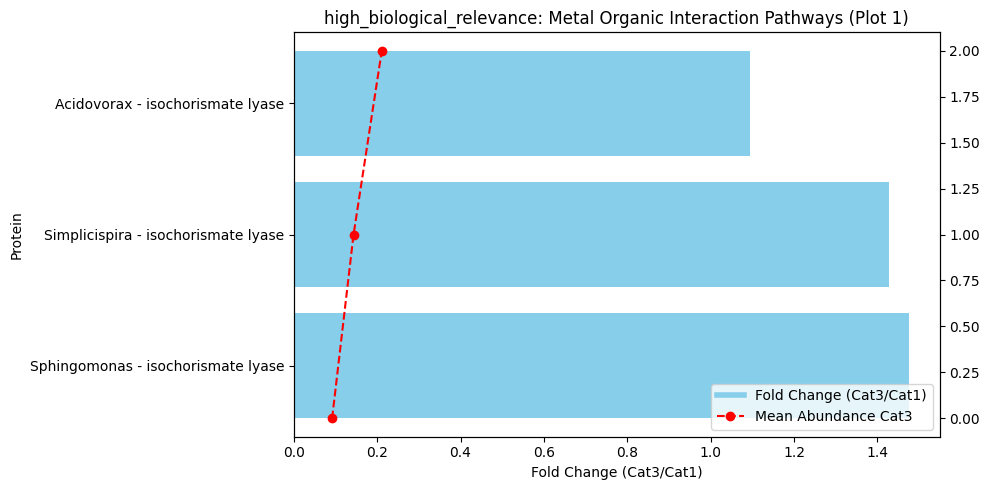

/tmp/ipykernel_22042/4000784589.py:80: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko-" (-> marker='o'). The keyword argument will take precedence.



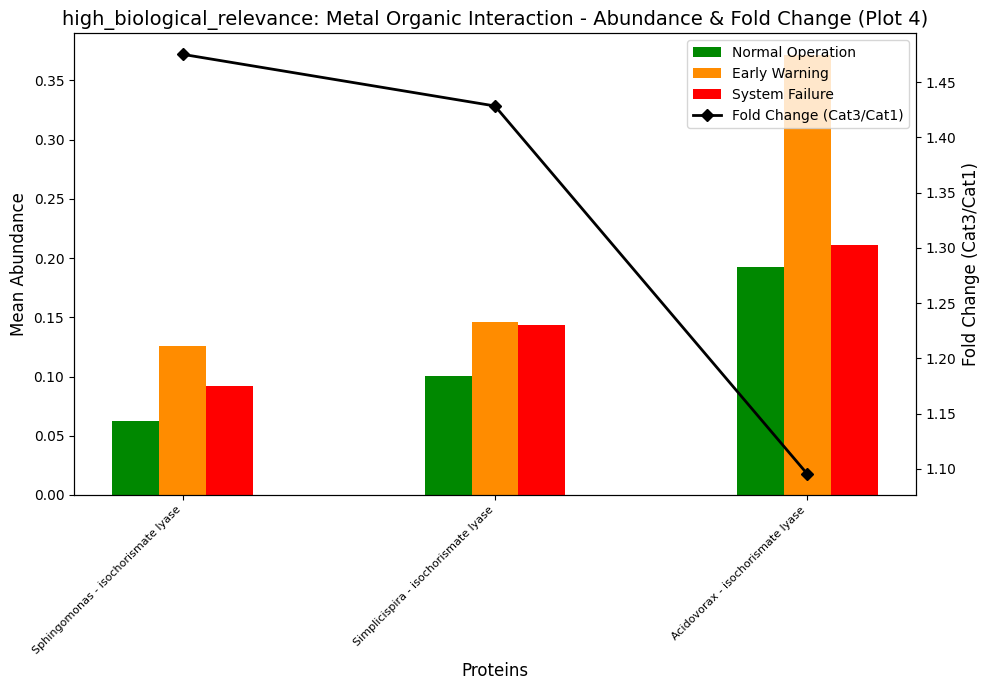

In [ ]:

plot_pathway_analysis(pathway_stats, pathway_categories,  df_name="high_biological_relevance", num_items=25)


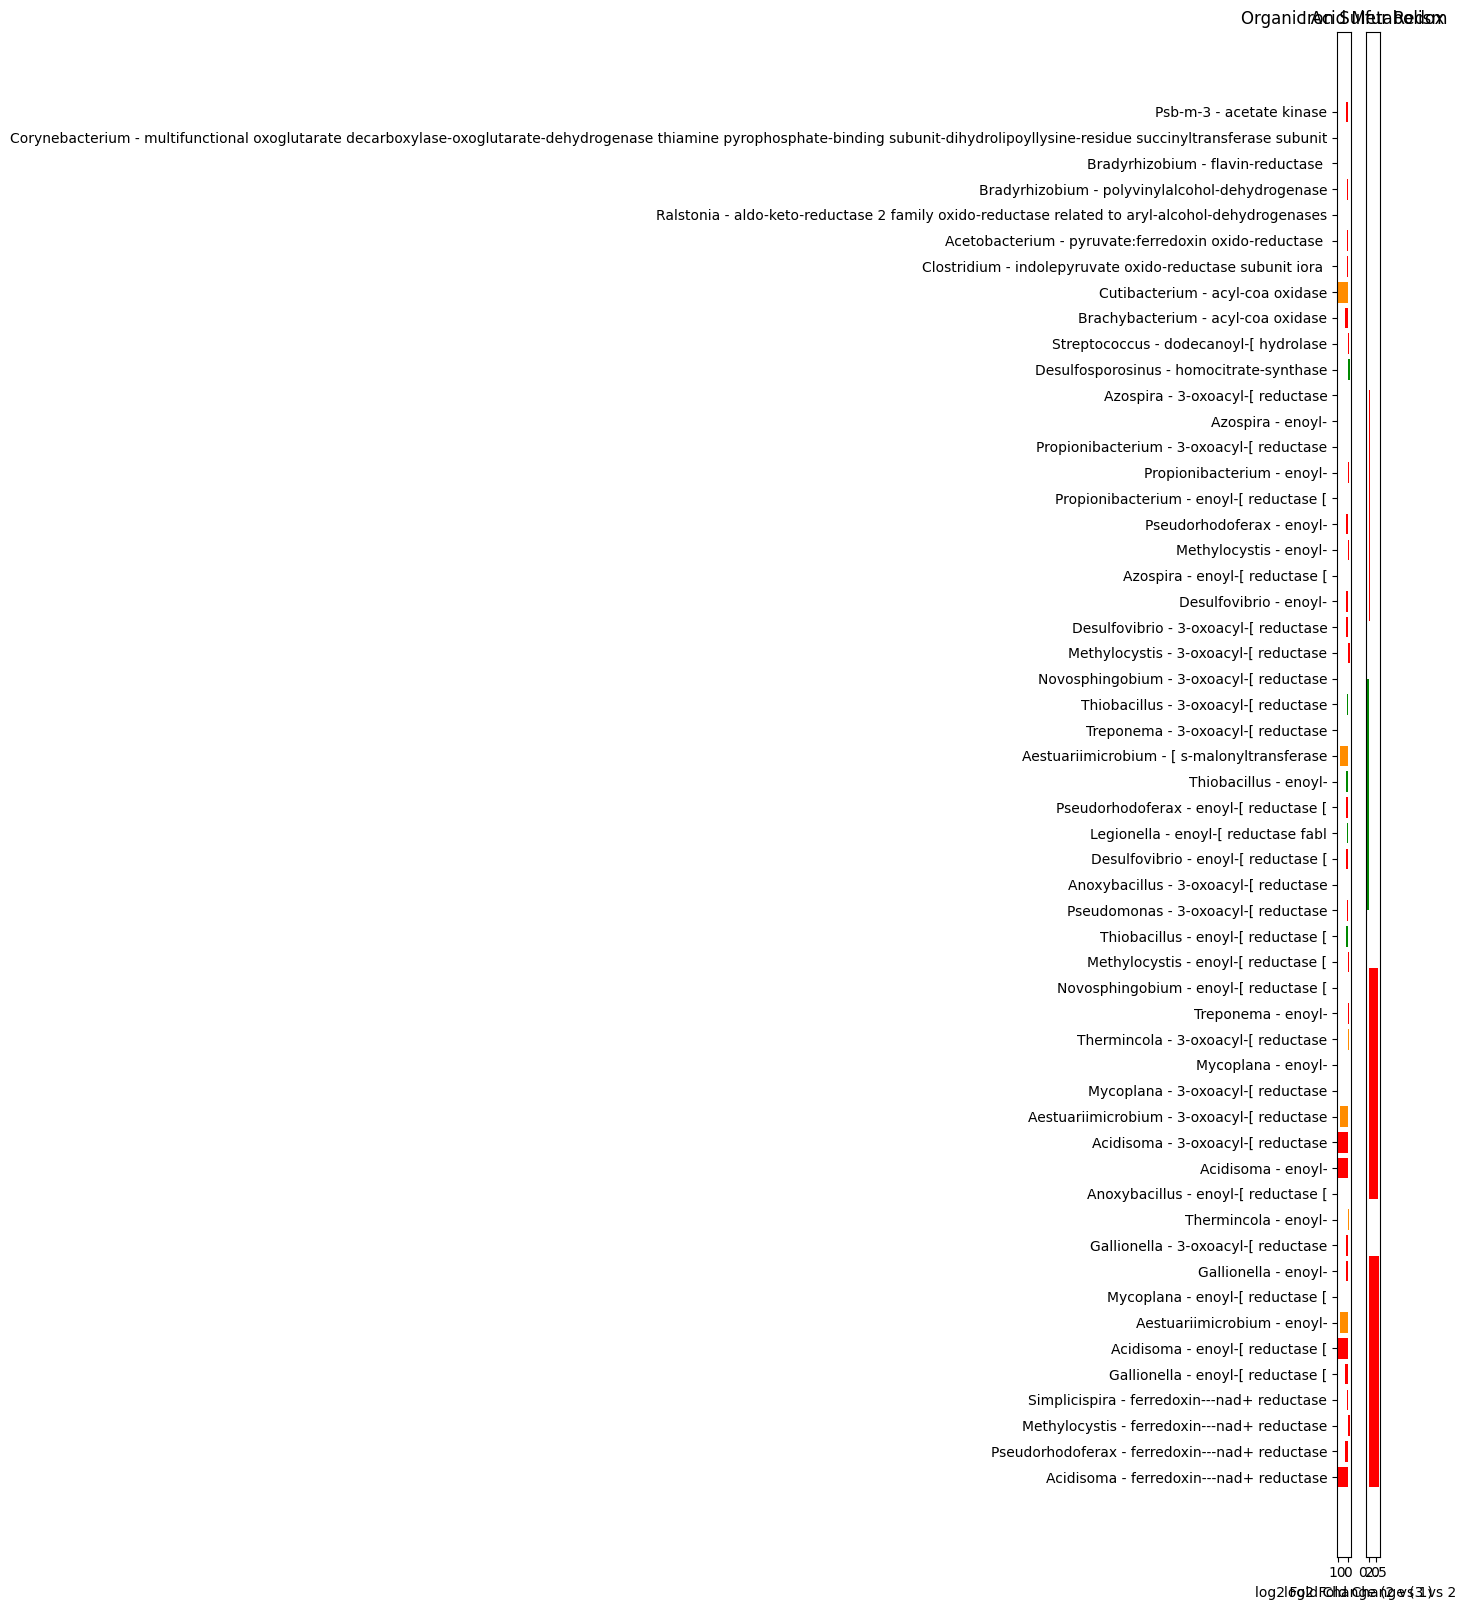

In [ ]:
def plot_mirrored_pathway_comparison(df, pathway_categories, cat1='organic_acid_metabolism', cat2='iron_sulfur_redox'):
    # Build lookup for categories
    category_terms = {k: v for k, v in pathway_categories.items()}
    
    def match_pathways(row, terms):
        return any(term.lower() in str(row['pathways']).lower() for term in terms)
    
    # Filter rows
    df_cat1 = df[df.apply(lambda row: match_pathways(row, category_terms.get(cat1, [])), axis=1)].copy()
    df_cat2 = df[df.apply(lambda row: match_pathways(row, category_terms.get(cat2, [])), axis=1)].copy()
    
    # Format y labels
    df_cat1['label'] = df_cat1['Genus'] + ' - ' + df_cat1['protein_name']
    df_cat2['label'] = df_cat2['Genus'] + ' - ' + df_cat2['protein_name']
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, max(len(df_cat1), len(df_cat2))*0.3))
    
    # Left
    ax1.barh(df_cat1['label'], df_cat1['log2fc_2vs1'], color=df_cat1['Category'].map({1: '#008800', 2: '#FF8C00', 3: '#FF0000'}))
    ax1.set_title(cat1.replace('_', ' ').title())
    ax1.set_xlabel('log2 Fold Change (2 vs 1)')
    ax1.invert_xaxis()
    
    # Right
    ax2.barh(df_cat2['label'], df_cat2['log2fc_3vs2'], color=df_cat2['Category'].map({1: '#008800', 2: '#FF8C00', 3: '#FF0000'}))
    ax2.set_title(cat2.replace('_', ' ').title())
    ax2.set_xlabel('log2 Fold Change (3 vs 2)')
    ax2.set_yticks([])
    
    # Layout
    plt.tight_layout()
    plt.show()

plot_mirrored_pathway_comparison(high_synergy_markers, pathway_categories) #cat1='organic_acid_metabolism', cat2='iron_sulfur_redox')

## 5.6. Functional Pathway Clustering Analysis
Hierarchical Clustering:

Groups pathways based on their abundance patterns
Creates a dendrogram to visualize relationships
Automatically determines optimal number of clusters


Correlation-based Analysis:

Identifies pathways that behave similarly across samples
Creates correlation heatmap to visualize relationships
Helps identify functional modules


Feature Creation:

Generates new features based on cluster statistics:

Mean abundance per cluster
Total abundance per cluster
Pathway diversity within clusters

Reduce dimensionality while maintaining biological meaning
Identify functional modules that might be working together
Create more robust features for our ML analysis


In [ ]:
def cluster_pathways(df, n_clusters=None, corr_threshold=0.7):
    """
    Cluster pathways based on their functional similarity

    Parameters:
    df: DataFrame with pathways as rows and samples as columns
    n_clusters: Number of clusters (if None, determined automatically)
    corr_threshold: Correlation threshold for considering pathways related
    """
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df.T).T

    # Calculate correlation matrix
    corr_matrix = np.corrcoef(scaled_data)

    # Create linkage matrix for hierarchical clustering
    linkage_matrix = hierarchy.linkage(pdist(scaled_data), method='ward')

    if n_clusters is None:
        # Automatically determine number of clusters using elbow method
        last = linkage_matrix[-10:, 2]
        acceleration = np.diff(last, 2)
        n_clusters = len(last) - np.argmax(acceleration) + 1

    # Perform clustering
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clustering.fit_predict(scaled_data)

    # Create cluster summary
    cluster_summary = pd.DataFrame({
        'pathway': df.index,
        'cluster': cluster_labels
    })

    return cluster_labels, linkage_matrix, corr_matrix, cluster_summary

def analyze_pathway_clusters(df, cluster_labels):
    """
    Analyze the characteristics of each pathway cluster
    """
    cluster_stats = {}

    for cluster in np.unique(cluster_labels):
        # Get pathways in this cluster
        cluster_paths = df.index[cluster_labels == cluster]
        cluster_data = df.loc[cluster_paths]

        # Calculate statistics
        cluster_stats[cluster] = {
            'size': len(cluster_paths),
            'mean_abundance': cluster_data.mean().mean(),
            'std_abundance': cluster_data.mean().std(),
            'pathways': list(cluster_paths),
            'correlation': np.corrcoef(cluster_data),
            'total_abundance': cluster_data.sum().mean()
        }

    return cluster_stats

## 5.7. Pathway Clustering Linkage_matrix

In [ ]:
def plot_pathway_clusters(df, linkage_matrix, corr_matrix, cluster_labels, cluster_stats):
    """
    Create visualizations for pathway clusters
    """
    # Plot dendrogram
    plt.figure(figsize=(15, 10))
    plt.title('Pathway Clustering Dendrogram')
    hierarchy.dendrogram(linkage_matrix, labels=df.index, leaf_rotation=90)
    plt.tight_layout()
    plt.show()

    # Plot correlation heatmap
    plt.figure(figsize=(12, 12))
    sns.heatmap(pd.DataFrame(corr_matrix, index=df.index, columns=df.index),
                cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title('Pathway Correlation Heatmap')
    plt.tight_layout()
    plt.show()

    # Plot cluster sizes and abundances
    plt.figure(figsize=(12, 6))
    clusters = list(cluster_stats.keys())
    sizes = [stats['size'] for stats in cluster_stats.values()]
    abundances = [stats['mean_abundance'] for stats in cluster_stats.values()]

    ax1 = plt.gca()
    ax2 = ax1.twinx()

    ax1.bar(clusters, sizes, alpha=0.6, color='skyblue')
    ax1.set_ylabel('Number of Pathways')

    ax2.plot(clusters, abundances, 'ro-')
    ax2.set_ylabel('Mean Abundance')

    plt.title('Cluster Sizes and Abundances')
    plt.tight_layout()
    plt.show()

def create_cluster_features(df, cluster_labels):
    """
    Create new features based on pathway clusters
    """
    n_clusters = len(np.unique(cluster_labels))
    cluster_features = pd.DataFrame(index=df.columns)

    for cluster in range(n_clusters):
        # Get pathways in this cluster
        cluster_paths = df.index[cluster_labels == cluster]

        # Calculate mean abundance for cluster
        cluster_features[f'cluster_{cluster}'] = df.loc[cluster_paths].mean()

        # Calculate total abundance for cluster
        cluster_features[f'cluster_{cluster}_total'] = df.loc[cluster_paths].sum()

        # Calculate diversity within cluster
        cluster_features[f'cluster_{cluster}_diversity'] = (df.loc[cluster_paths] > 0).sum()

    return cluster_features

# Calling the fUNCTION
cluster_labels, linkage_matrix, corr_matrix, cluster_summary = cluster_pathways(Picrust_Result)
cluster_stats = analyze_pathway_clusters(Picrust_Result, cluster_labels)
plot_pathway_clusters(Picrust_Result, linkage_matrix, corr_matrix, cluster_labels, cluster_stats)
cluster_features = create_cluster_features(Picrust_Result, cluster_labels)

# 6. Metal Involvement by Genus across Risk Categories
The plot_metal_involvement function creates a heatmap showing the relationship between bacterial genera and the specific metals they interact with, weighted by the combined score from prioritized markers.

In [ ]:
def plot_metal_involvement(prioritized_markers):
    """
    Creates a heatmap showing metal involvement by genus across risk categories,
    using the actual metal names from the data.
    """
    # Process metal involvement data
    metal_data = []

    for _, row in prioritized_markers.iterrows():
        if isinstance(row['metals_involved'], str) and row['metals_involved']:
            # Use the correct delimiter based on the data format (comma or semicolon)
            metals = [m.strip() for m in row['metals_involved'].split(';')]
            for metal in metals:
                metal_data.append({
                    'Genus': row['Genus'],
                    'metal': metal,  # Keep the original metal name
                    'Category 1': row['mean_cat1'],
                    'Category 2': row['mean_cat2'],
                    'Category 3': row['mean_cat3'],
                    'combined_score': row['combined_score']
                })

    # Convert to DataFrame
    metal_df = pd.DataFrame(metal_data)

    # Group by genus and metal
    grouped = metal_df.groupby(['Genus', 'metal']).agg({
        'Category 1': 'mean',
        'Category 2': 'mean',
        'Category 3': 'mean',
        'combined_score': 'mean'
    }).reset_index()

    # Create a pivot table for the heatmap
    pivot = grouped.pivot_table(
        index='Genus',
        columns='metal',
        values='combined_score',
        aggfunc='mean'
    ).fillna(0)

    # Sort by sum of values
    pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]
    pivot = pivot[pivot.sum().sort_values(ascending=False).index]

    # Set up the plot
    plt.figure(figsize=(12, 8))

    # Create heatmap - using a mask for zero values to make them white
    mask = pivot == 0
    sns.heatmap(
        pivot,
        cmap='YlOrRd',
        linewidths=0.5,
        cbar_kws={'label': 'Combined Score'},
        mask=mask
    )

    plt.title('Metal Involvement by Genus', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    # Print a simple dictionary of the metals for reference
    #metal_list = sorted(metal_df['metal'].unique())

    return plt.gcf()
plot_metal_involvement(high_mechanism_relevance)
plt.tight_layout()

https://www.youtube.com/watch?v=jQVNsyAnDMo

https://microreact.org/



# 7. Organic Matter Validation
## 7.1 CORRELATING PROTEIN PRESENCE WITH OM REPRESENTATION (OX_AC)
This step tests whether the chosen OM surrogates influence protein expression patterns. The acetate and oxalate concentrations are treated as physicochemical features and see the correlation with: protein frequency, functional category scores, overall combined score. This allows to evaluate whether acetate or oxalate-rich environments are associated with higher-scoring proteins or specific functional groups.
I have a big gap on the cation anion account and then used mackensy, [2012] method from the usgs to check Ec measured Vs calculated and cation Vs ions. It is a big gap still, but I have a lot of OM so I could no assume as normally that OM is CH4 so I attribute it to small organic acids and put acetate and oxalate as OM representatives, I have a small study of small acids form on failure analysis and also report of a mass that has a magnetic consistency, so I infere that those muss be some organic metalic compound but only accounted for AC- and Ox-2, I thought better to chose this other compounds Fe rich but I don't know how to do it actually. So in my bacteria I actually found lots of them with Ac- metabolism whiles I was looking at the families I realise no only oxobacter accendants, but others similar, also got important biofilm formers, there is also halogen related and should be, big deal of difference make the material and location cause water treatment, unfortunately the annotations are no to be taken as parameters but can serve as annotations. This part would validate assumptions about:

Organic acid presence (by showing metabolic capability)
Metal-organic complex formation (through siderophore and metal-binding pathways)
Biofilm formation potential (which can influence local chemistry)

Validate acetate/oxalate assumptions by showing if these metabolic pathways are actually present
Look for other potential organic acid pathways might want to consider
Identify metal-organic interaction pathways that could explain magnetic mass observation

In [ ]:
# Merge metadata with protein scoring on similar column
merged = results.merge(env_data[['sample_id', 'acetate_conc', 'oxalate_conc']], on='sample_id', how='left')

# OPTIONAL: Correlation matrix (for numerical analysis)
correlation_matrix = merged[['combined_score', 'functional_mechanisms_score', 'acetate_conc', 'oxalate_conc']].corr()
print("Correlation matrix:\n", correlation_matrix)

sns.lmplot(data=merged, x='acetate_conc', y='functional_mechanisms_score', hue='corrosion_relevance')
plt.title("Acetate vs Functional Score by Corrosion Relevance")
plt.show()


In [ ]:
def analyze_organic_metal_pathways(df):
    """
    Analyze pathways related to organic acid metabolism and metal interactions

    Parameters:
    df: pandas DataFrame with pathways as index and samples as columns
    """
    # Define specific pathway categories
    pathway_categories = {
        'organic_acid_metabolism': [
            'acetate', 'acetic acid', 'acetyl',
            'oxalate', 'oxalic acid',
            'organic acid', 'fatty acid',
            'carboxylic acid'
        ],

        'metal_organic_interaction': [
            'siderophore', 'metal binding',
            'iron complex', 'metal transport',
            'metallophore', 'metal organic'
        ],

        'biofilm_formation': [
            'biofilm', 'exopolysaccharide',
            'extracellular matrix', 'adhesion'
        ],

        'halogen_related': [
            'halogen', 'chloride', 'bromide',
            'halide', 'dehalogenation'
        ]
    }

    # Analyze each category
    def get_category_pathways(terms):
        return df.index[df.index.str.lower().str.contains('|'.join(terms), regex=True)]

    pathway_data = {}
    pathway_stats = {}

    for category, terms in pathway_categories.items():
        pathways = get_category_pathways(terms)
        if len(pathways) > 0:
            pathway_data[category] = df.loc[pathways]

            # Calculate comprehensive statistics
            pathway_stats[category] = pd.DataFrame({
                'mean_abundance': pathway_data[category].mean(axis=1),
                'std_abundance': pathway_data[category].std(axis=1),
                'cv': pathway_data[category].std(axis=1) / pathway_data[category].mean(axis=1) * 100,
                'presence': (pathway_data[category] > 0).mean(axis=1) * 100,  # % of samples with pathway
                'relative_abundance': pathway_data[category].mean(axis=1) / df.mean(axis=1).mean() * 100
            }).sort_values('mean_abundance', ascending=False)

    return pathway_data, pathway_stats

def analyze_pathway_relationships(pathway_data):
    """
    Analyze relationships between different pathway categories
    """
    # Calculate mean abundance for each category across samples
    category_means = pd.DataFrame({
        category: data.mean(axis=0)
        for category, data in pathway_data.items()
    })

    # Calculate correlations
    correlations = category_means.corr()

    # Identify potential functional relationships
    high_correlations = correlations.unstack()
    high_correlations = high_correlations[high_correlations != 1.0]
    high_correlations = high_correlations[abs(high_correlations) > 0.5]

    return category_means, correlations, high_correlations.sort_values(ascending=False)

def plot_pathway_analysis(pathway_stats, pathway_data):
    """
    Create visualizations for pathway analysis
    """
    for category, stats in pathway_stats.items():
        if len(stats) > 0:
            # Create subplot with dual axis
            fig, ax1 = plt.subplots(figsize=(12, min(8, max(4, len(stats)*0.3))))
            ax2 = ax1.twinx()

            # Plot abundance and relative abundance
            sns.barplot(data=stats.head(10).reset_index(),
                       x='relative_abundance',
                       y='index',
                       color='skyblue',
                       ax=ax1)

            stats.head(10)['presence'].plot(
                marker='o',
                color='red',
                ax=ax2
            )

            ax1.set_title(f'{category.replace("_", " ").title()} Pathways')
            ax1.set_xlabel('Relative Abundance (%)')
            ax2.set_xlabel('Presence (%)')

            plt.tight_layout()
            plt.show()

# calling the function
pathway_data, pathway_stats = analyze_organic_metal_pathways(Picrust_Result)category_means, correlations, high_corr = analyze_pathway_relationships(pathway_data)
plot_pathway_analysis(pathway_stats, pathway_data)

SyntaxError: invalid syntax (126627734.py, line 108)